In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%%html
<style>
.cell-output-ipywidget-background {
    background-color: transparent !important;
}
:root {
    --jp-widgets-color: var(--vscode-editor-foreground);
    --jp-widgets-font-size: var(--vscode-editor-font-size);
}  
</style>

In [3]:
import asyncio
from itertools import cycle, islice
from lib import models
from lib.grpo import GRPO
from lib.pack import packed_tensors_from_tokenized_results, plot_packed_tensors
from lib.recipe import ComponentConfig, TuneRecipeConfig
from lib.tasks import ChatCompletionParams, get_task_results
from lib.temporal_clue import get_temporal_clue_tasks
from lib.tokenize import TaskResultTokenizer
from lib.tune import clear_iteration_dirs, get_iteration, get_last_iteration_dir, last_tune_log, tune, Verbosity
from lib.utils import rsync_dir
from lib.vllm import start_vllm, kill_vllm_workers
import polars as pl
import random
import torch
from transformers import AutoTokenizer
import wandb

run_name = "026"
run = wandb.init(
    project="rl-experiments",
    name=run_name,
    id=run_name,
    resume="allow",
    config={"task": "temporal-clue"},
)

tasks = list(get_temporal_clue_tasks())
val_tasks = tasks[:64]
test_tasks = tasks[64:128]
train_tasks = tasks[128:]
random.seed(42)
random.shuffle(train_tasks)
len(val_tasks), len(test_tasks), len(train_tasks)

wandb: Currently logged in as: bradhilton to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


(64, 64, 2860)

In [4]:
# GRPO params
wandb.config["clip_epsilon"] = clip_epsilon = 0.2
wandb.config["entropy_coef"] = entropy_coef = 0.0
wandb.config["kl_coef"] = kl_coef = 0.0
wandb.config["tanh"] = tanh = True

expected_tokens = 300  # Expected completion tokens per task sample
wandb.config["lr"] = lr = 6e-5
wandb.config["betas"] = betas = (0.9, 0.999)  # (0.9, 0.99)
wandb.config["weight_decay"] = weight_decay = 0.01  # 0.1
model = models.theta_8b()
wandb.config["model"] = model.base_model
num_iterations = 1_000
output_dir = f"./models/{run_name}"
wandb.config["samples_per_task"] = samples_per_task = 50
wandb.config["seq_len"] = seq_len = 16384
wandb.config["stride"] = stride = 32
wandb.config["tasks_per_iter"] = tasks_per_iter = 64
sync_dir = output_dir  # symlink_shm(output_dir) or output_dir
tokenizer = AutoTokenizer.from_pretrained(model.base_model)
verbosity: Verbosity = 2

$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0002 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0002 --port=8001 --api-key=default
INFO 02-21 03:55:26 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 03:55:28 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 03:55:28 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0002', config='', host=None, port=8001, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None, chat_template_content_format='auto', response_role

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.22s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:06,  3.24s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.09s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.00s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.91s/it]



INFO 02-21 03:55:54 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 03:55:55 worker.py:267] Memory profiling takes 0.92 seconds
INFO 02-21 03:55:55 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 03:55:55 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 03:55:55 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 03:55:55 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 03:56:54 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 60.75 seconds
INFO 02-21 03:56:55 api_server.py:756] Using supplied chat template:
INFO 02-21 03:56:55 api_server.py:756] None
INFO 02-21 03:56:55 launcher.py:21] Available routes are:
INFO 02-21 03:56:55 launcher.py:29] Route: /

INFO:     Started server process [15719]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8001 (Press CTRL+C to quit)


INFO 02-21 03:57:01 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 03:57:01 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 03:57:01 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:38190 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:51<00:00, 65.63it/s, completion_tokens=34, prompt_tokens=1168, reward=0.362, token_logprobs=110210]
Deleted iteration directory ./models/026/0001


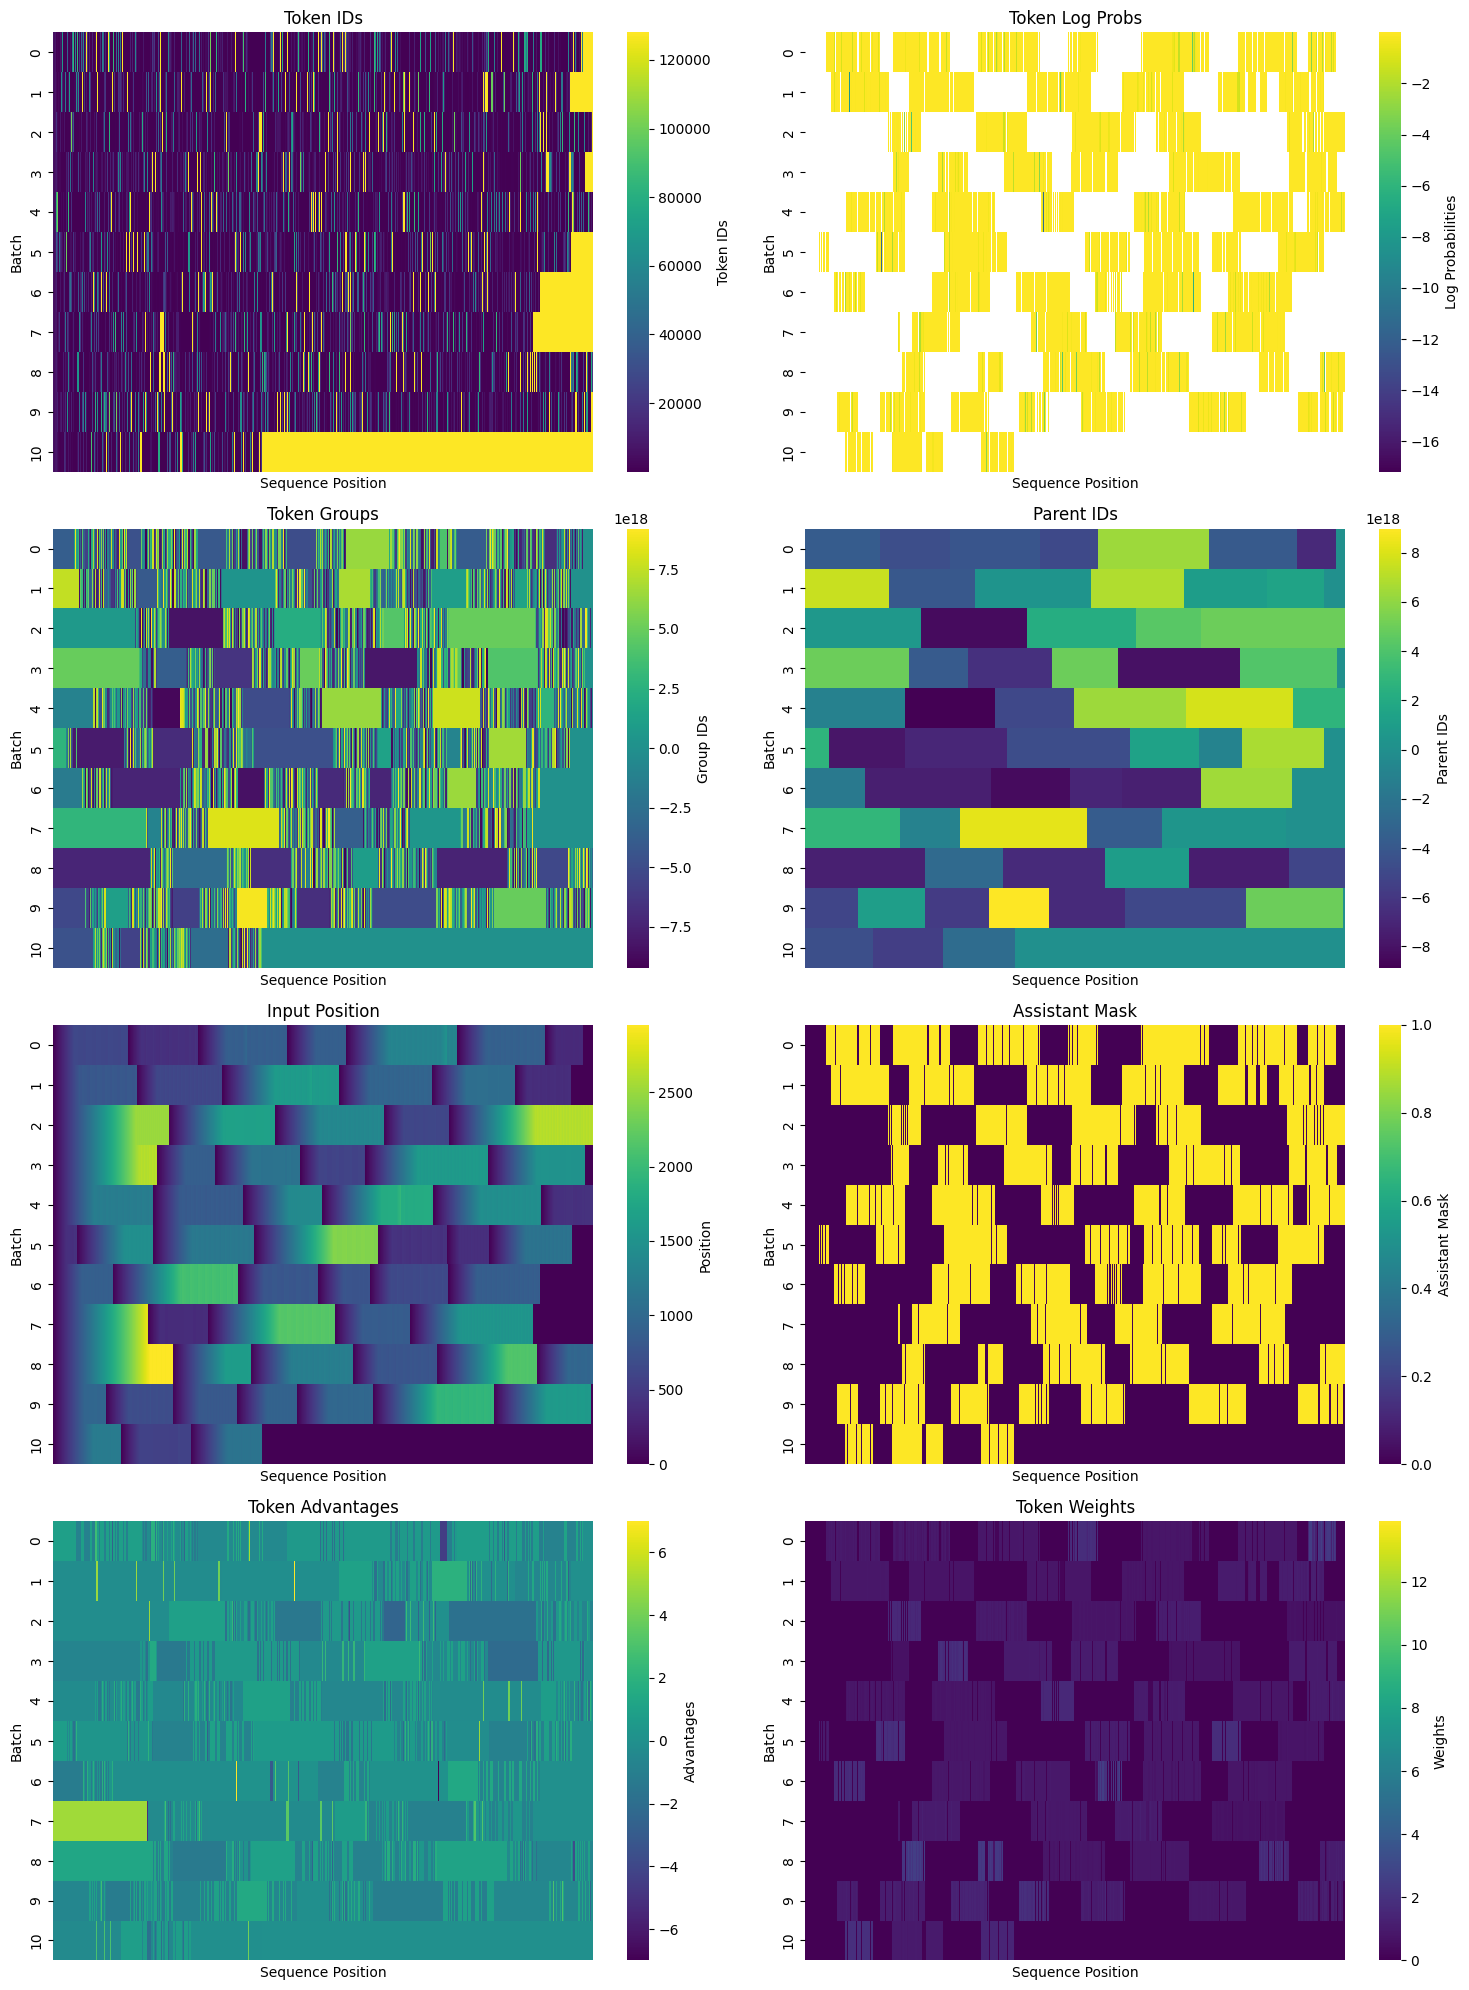

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0002
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740110363.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.57 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0006: 100%|██████████| 5/5 [02:13<00:00, 25.59s/it, entropy=0.154, kl_div=nan, loss=0.000604, policy=0.000604] INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.10 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #3 model files to ./models/026/0003
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0003 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0003 --port=8000 --api-key=default
INFO 02-21 04:02:42 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:02:43 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:02:43 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0003', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.27it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.09s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.47s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.61s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.38s/it]



INFO 02-21 04:03:06 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:03:06 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 04:03:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:03:06 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:03:07 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:03:07 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:03:54 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.43 seconds
INFO 02-21 04:03:55 api_server.py:756] Using supplied chat template:
INFO 02-21 04:03:55 api_server.py:756] None
INFO 02-21 04:03:55 launcher.py:21] Available routes are:
INFO 02-21 04:03:55 launcher.py:29] Route: /

INFO:     Started server process [17708]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:04:01 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 04:04:01 metrics.py:455] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 04:04:01 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:50968 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:37<00:00, 81.43it/s, completion_tokens=35, prompt_tokens=1142, reward=0.387, token_logprobs=112063]
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completi

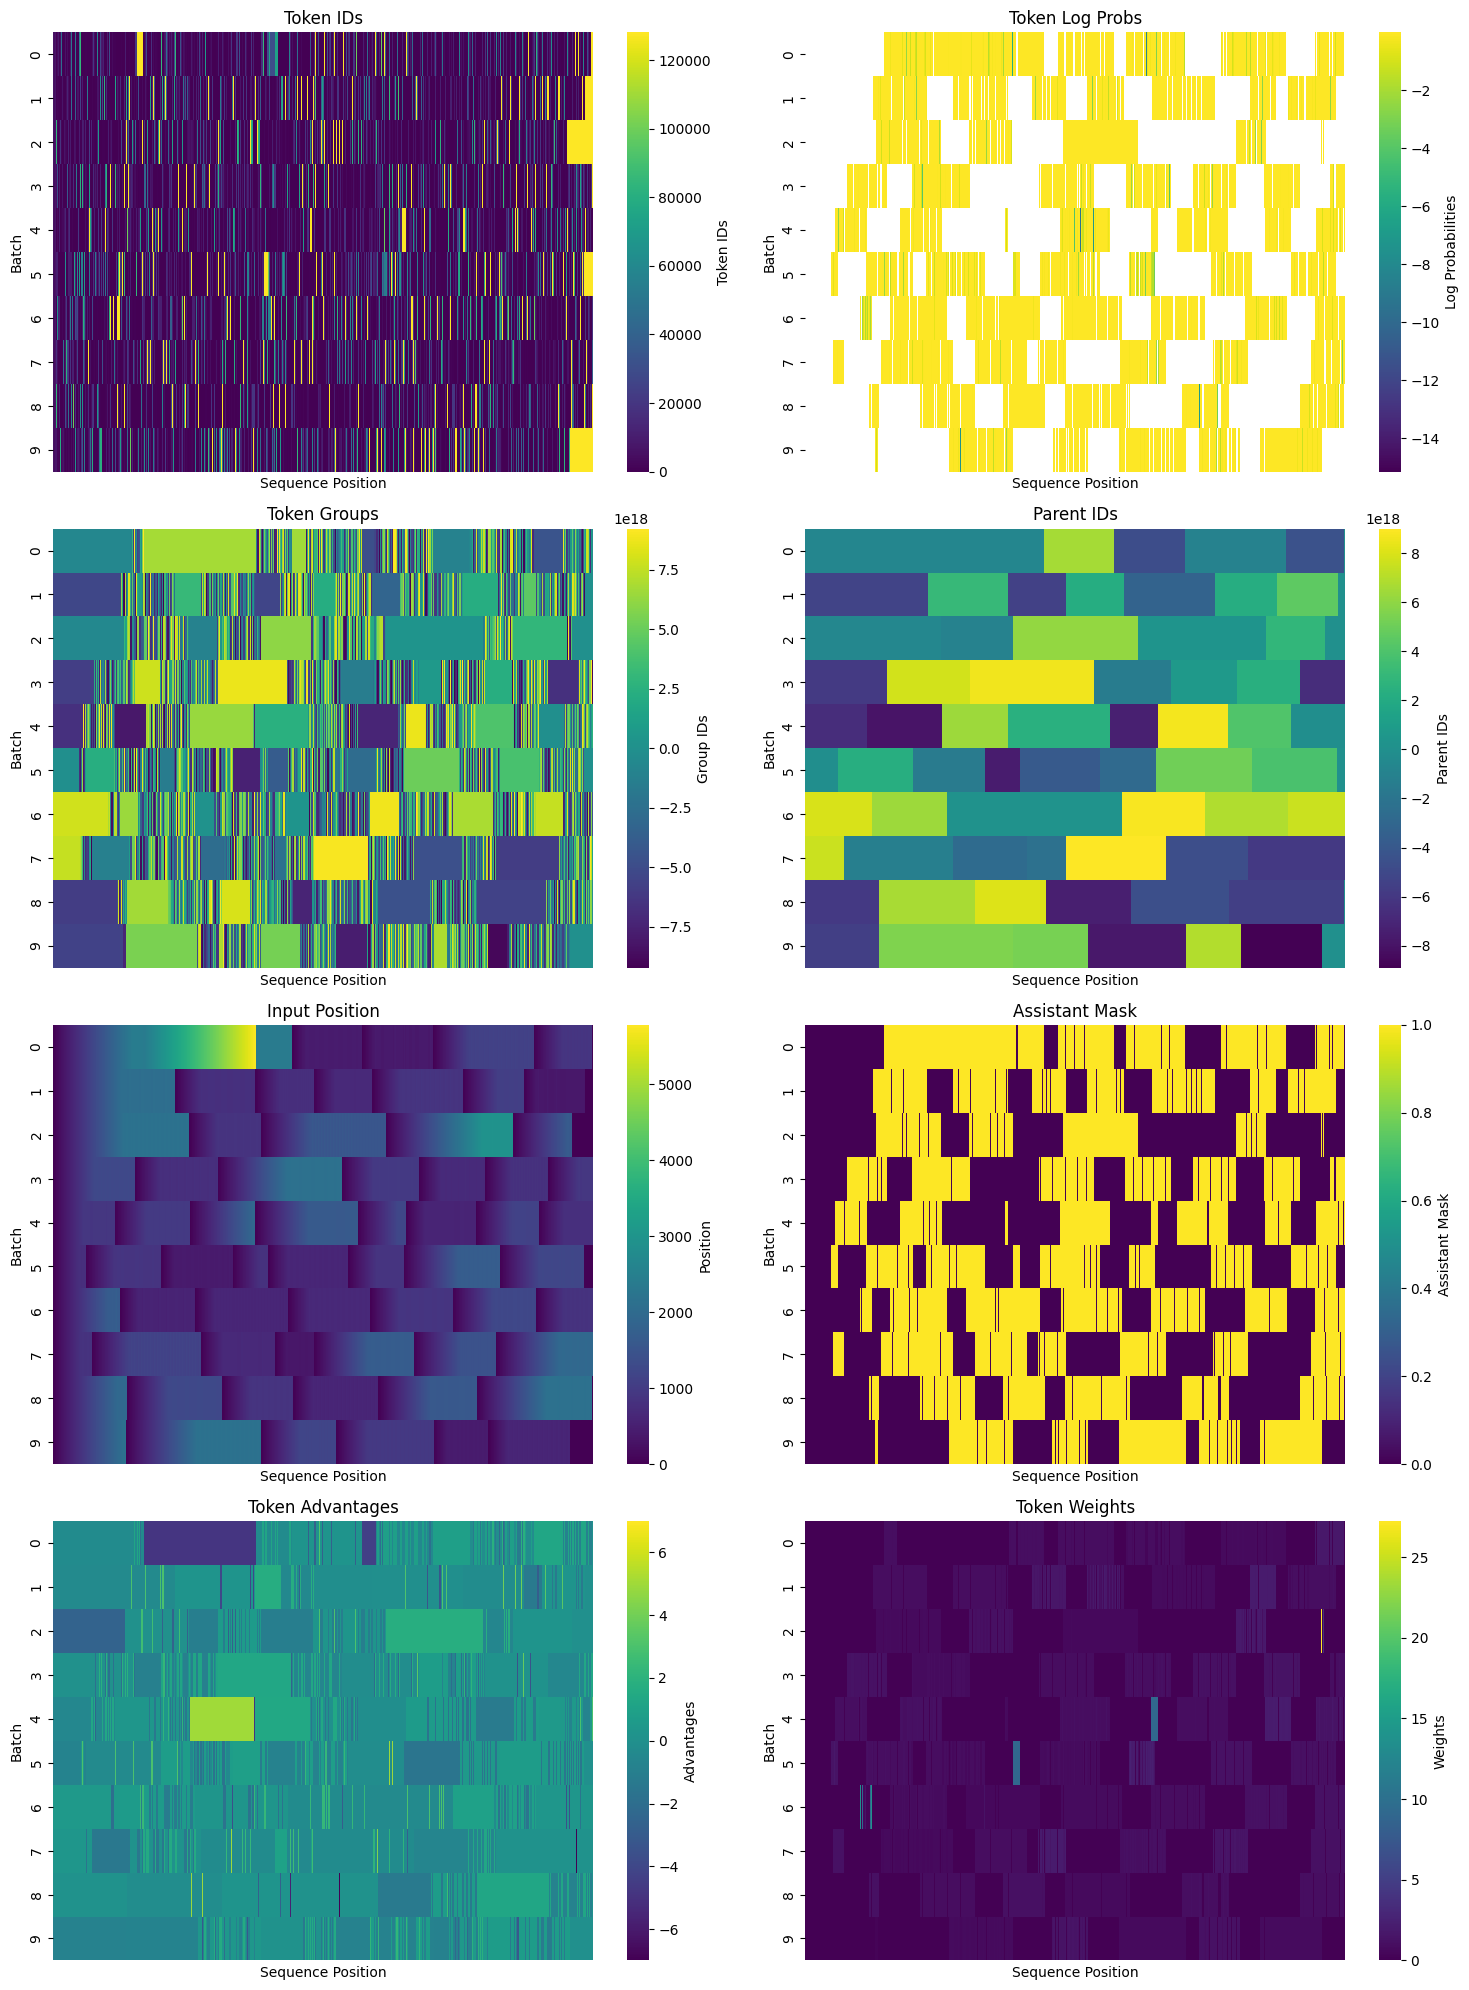

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0003
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740110769.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.57 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0041: 100%|██████████| 5/5 [02:13<00:00, 25.48s/it, entropy=0.208, kl_div=nan, loss=0.00413, policy=0.00413]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.64 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #4 model files to ./models/026/0004
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0004 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0004 --port=8000 --api-key=default
INFO 02-21 04:09:27 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:09:28 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:09:28 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0004', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.03it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:04,  2.45s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.72s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.54s/it]



INFO 02-21 04:09:48 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:09:49 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 04:09:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:09:49 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:09:49 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:09:49 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:10:35 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.05 seconds
INFO 02-21 04:10:36 api_server.py:756] Using supplied chat template:
INFO 02-21 04:10:36 api_server.py:756] None
INFO 02-21 04:10:36 launcher.py:21] Available routes are:
INFO 02-21 04:10:36 launcher.py:29] Route: /

INFO:     Started server process [19614]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:10:43 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 04:10:43 metrics.py:455] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 04:10:43 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:46916 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:22<00:00, 35.70it/s, completion_tokens=33, prompt_tokens=1145, reward=0.42, token_logprobs=107054]
Deleted iteration directory ./models/026/0002
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion t

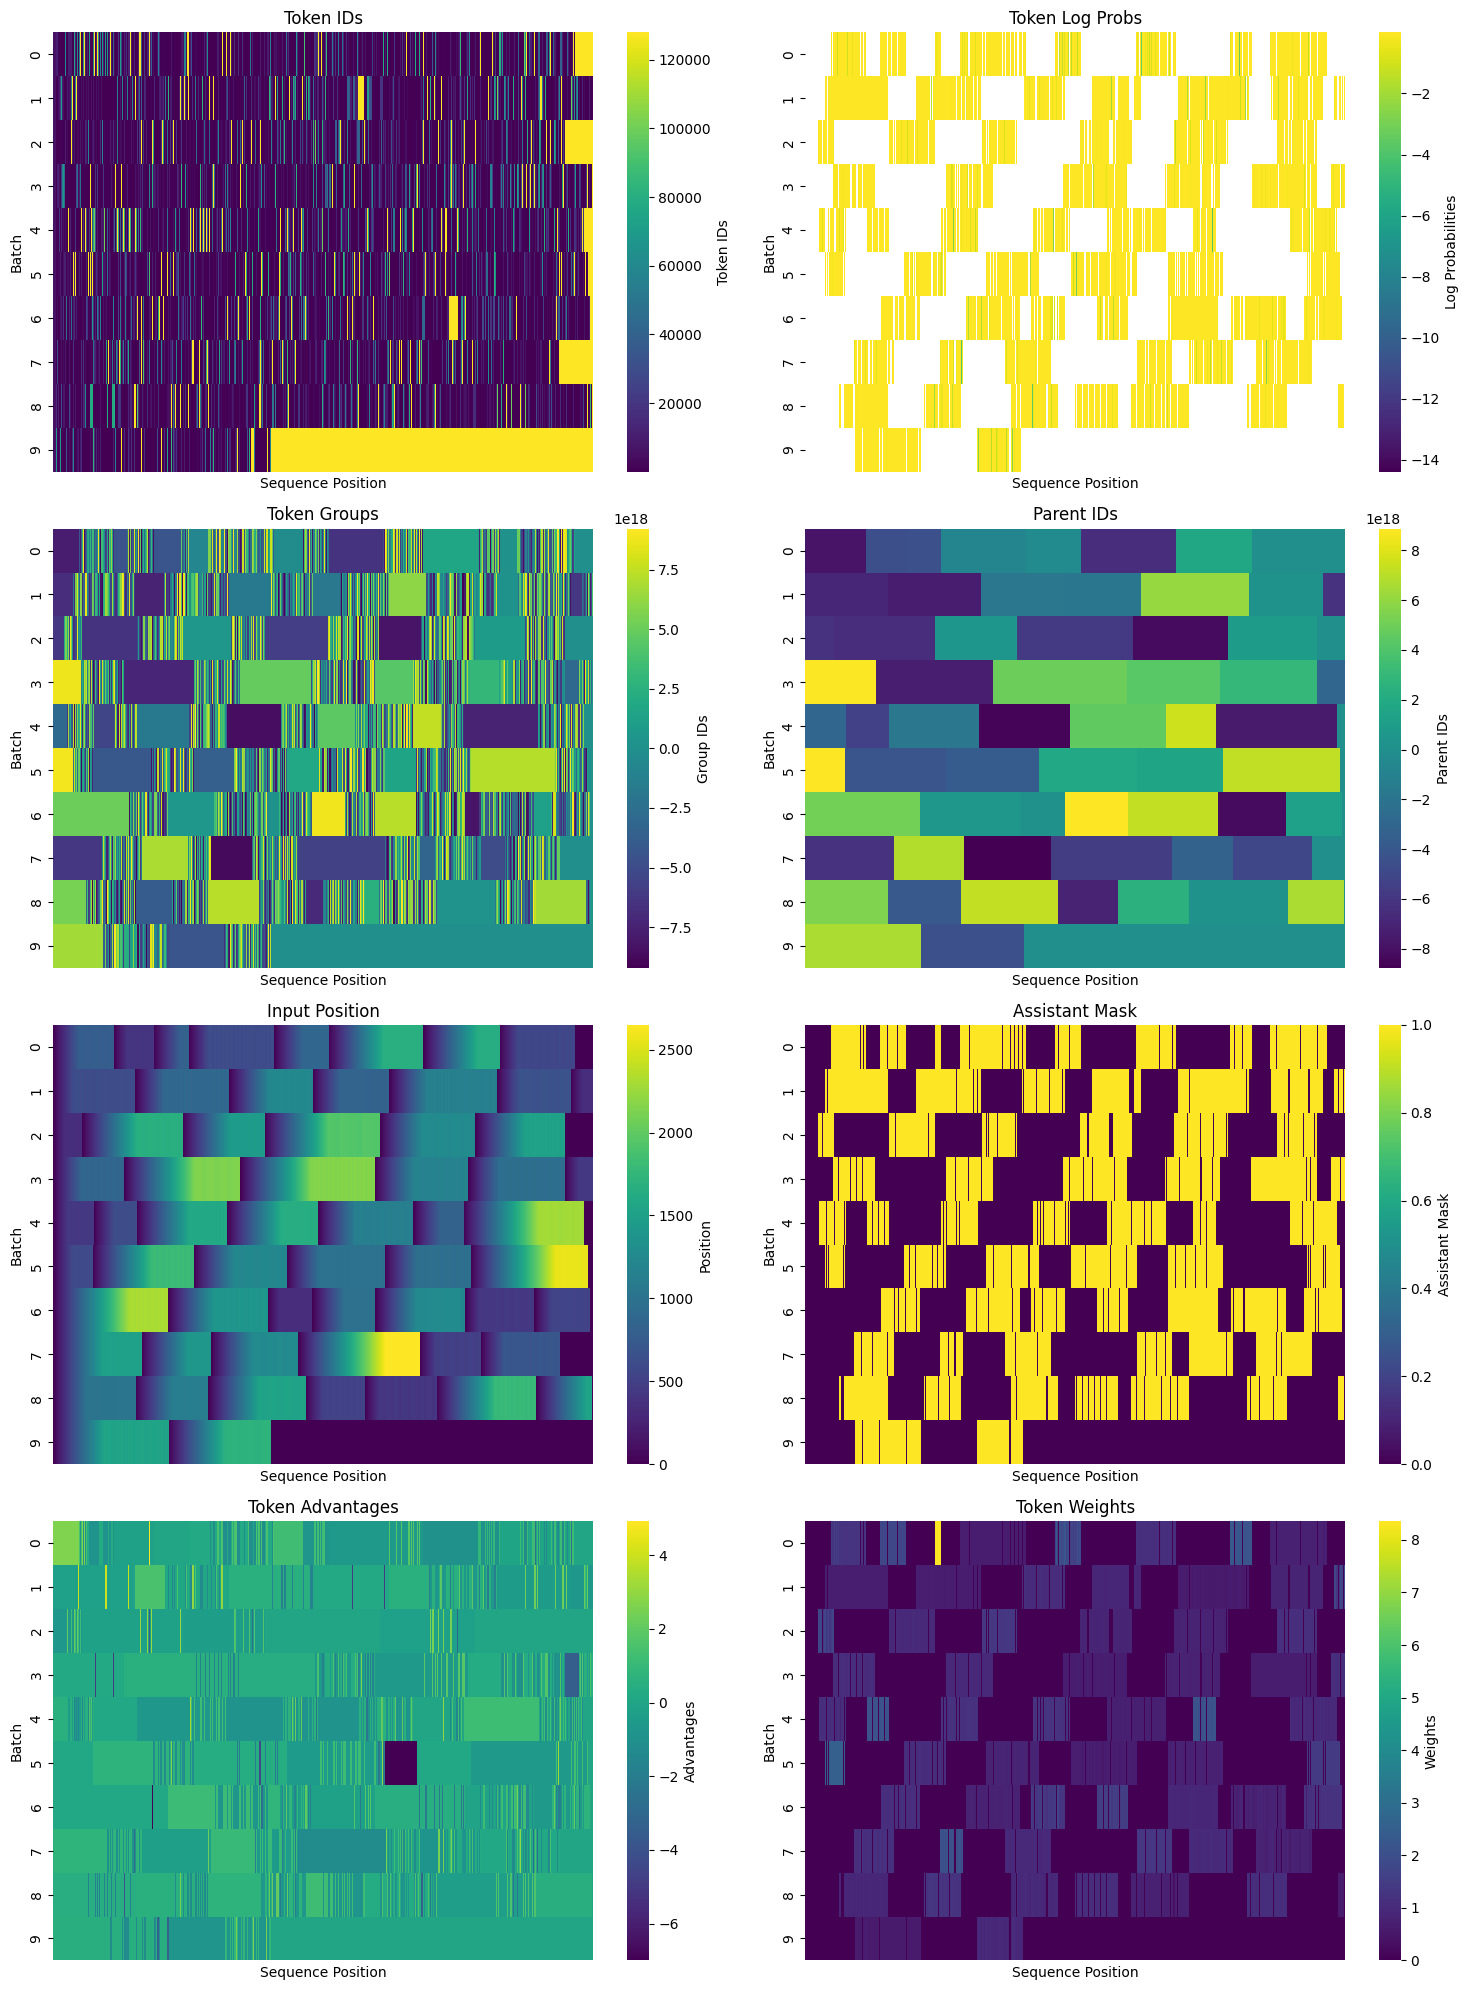

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0004
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740111275.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.11 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0034: 100%|██████████| 5/5 [02:13<00:00, 25.48s/it, entropy=0.287, kl_div=nan, loss=-0.00342, policy=-0.00342]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.23 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #5 model files to ./models/026/0005
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0005 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0005 --port=8000 --api-key=default
INFO 02-21 04:17:56 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:17:57 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:17:57 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0005', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.28s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.63s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.75s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.40s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.32s/it]



INFO 02-21 04:18:24 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:18:25 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 04:18:25 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:18:25 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:18:25 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:18:25 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:19:14 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.13 seconds
INFO 02-21 04:19:15 api_server.py:756] Using supplied chat template:
INFO 02-21 04:19:15 api_server.py:756] None
INFO 02-21 04:19:15 launcher.py:21] Available routes are:
INFO 02-21 04:19:15 launcher.py:29] Route: /

INFO:     Started server process [21526]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:19:17 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:45292 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:52<00:00, 128.76it/s, completion_tokens=33, prompt_tokens=1297, reward=0.422, token_logprobs=104124]
Deleted iteration directory ./models/026/0004
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion

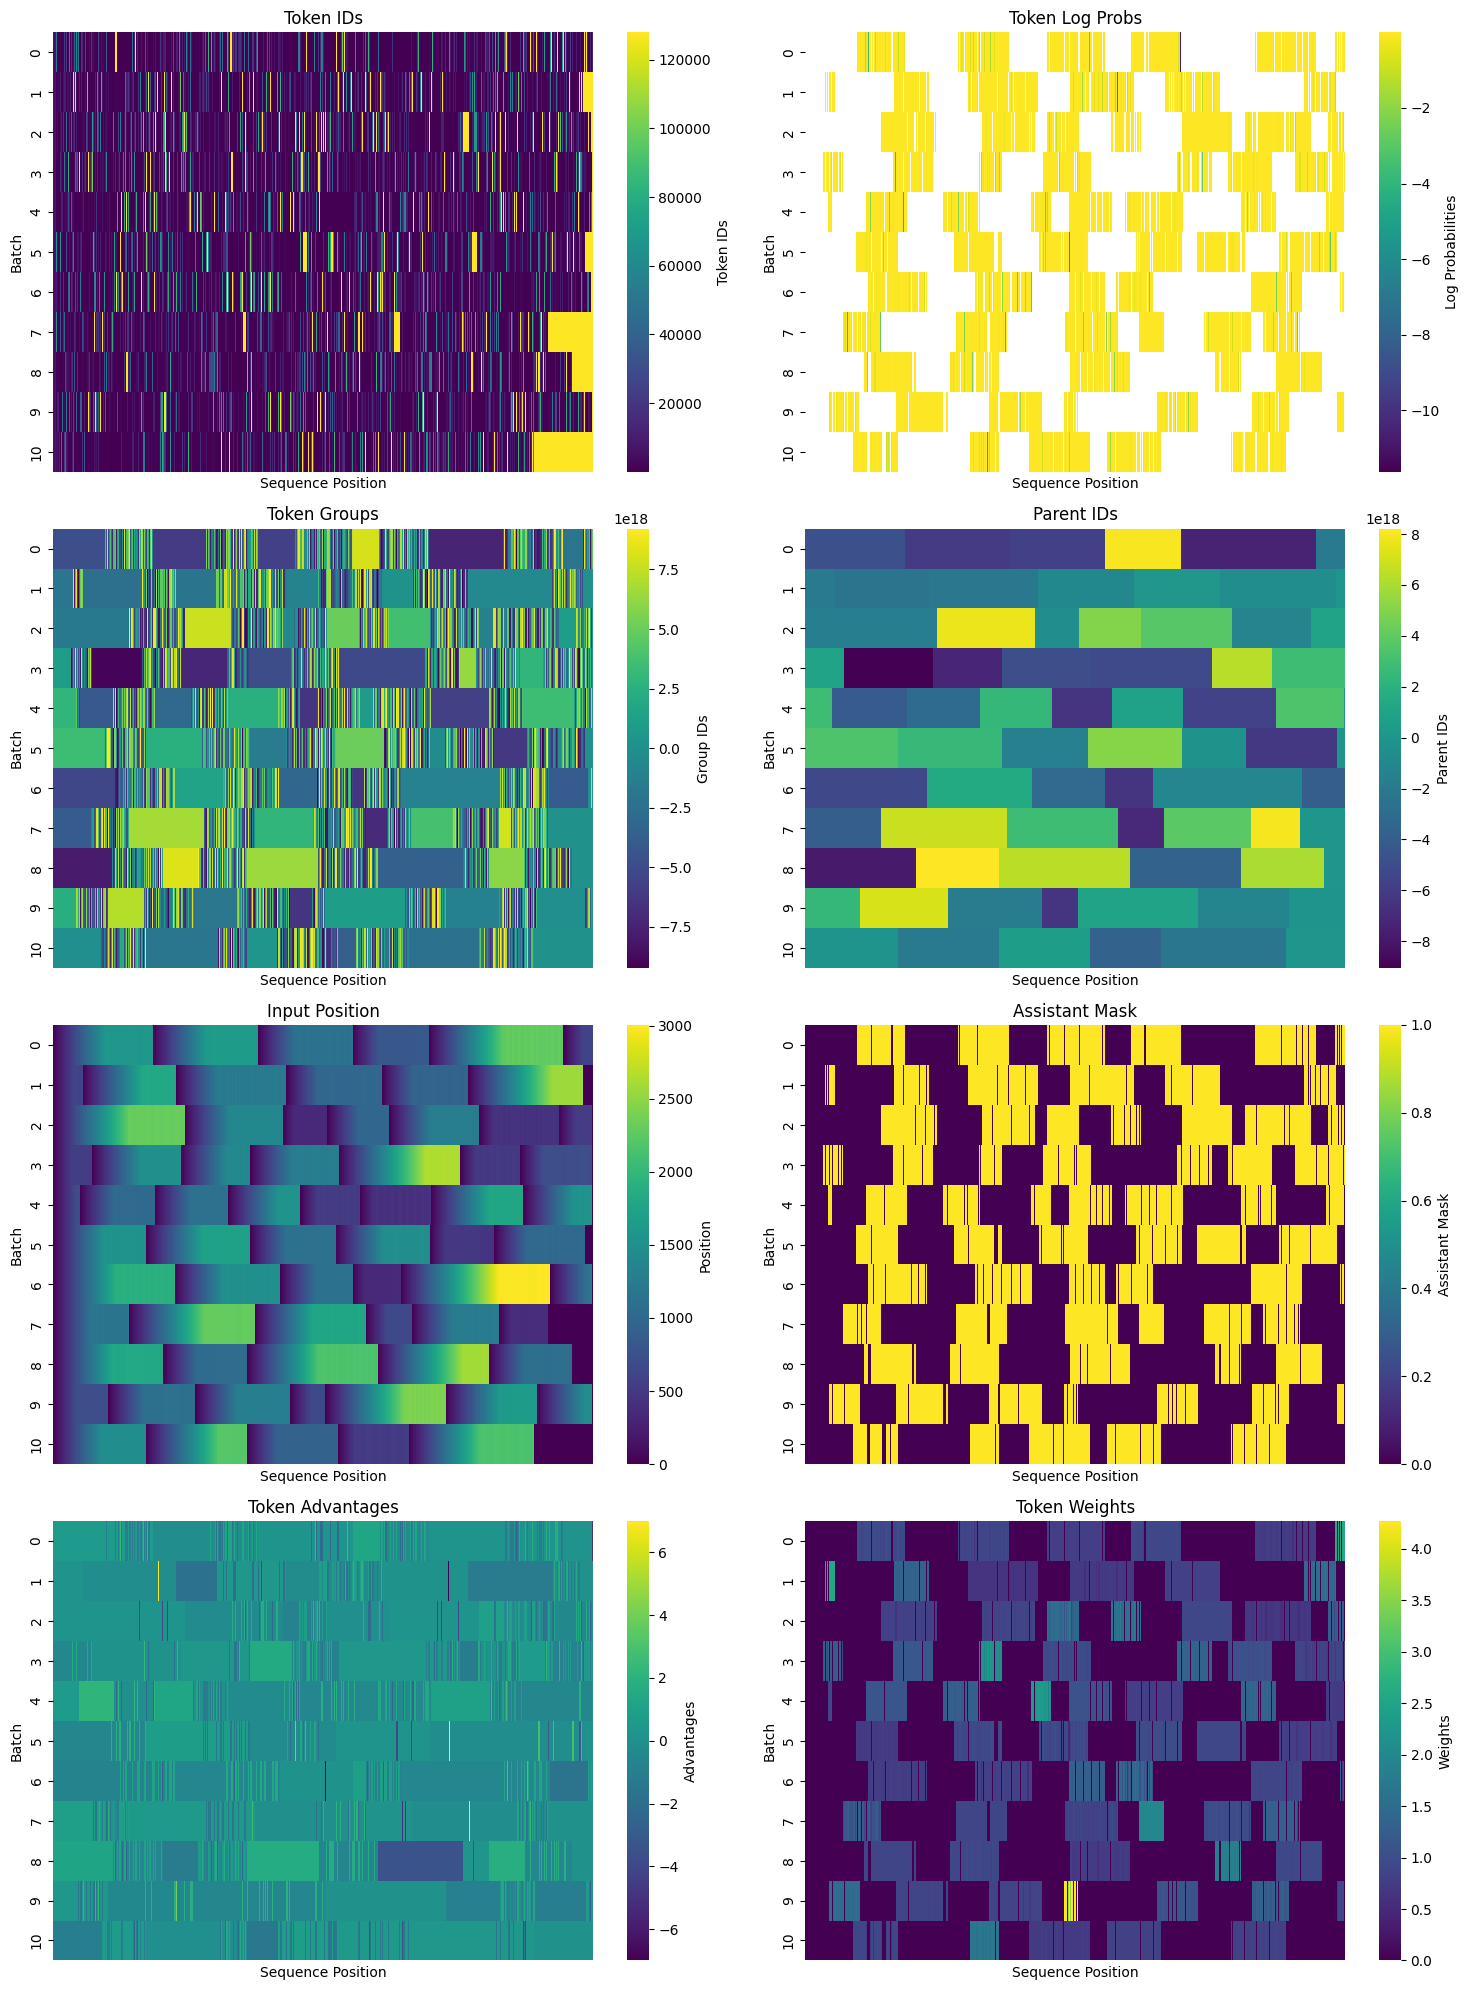

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0005
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740111700.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.92 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0064: 100%|██████████| 5/5 [02:16<00:00, 25.78s/it, entropy=0.301, kl_div=nan, loss=-0.00636, policy=-0.00636]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.67 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #6 model files to ./models/026/0006
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0006 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0006 --port=8000 --api-key=default
INFO 02-21 04:25:02 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:25:02 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:25:02 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0006', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:04,  1.41s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.58s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.28s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.11s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:12<00:00,  3.07s/it]



INFO 02-21 04:25:29 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:25:30 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 04:25:30 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:25:30 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:25:30 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:25:30 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:26:13 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.04 seconds
INFO 02-21 04:26:14 api_server.py:756] Using supplied chat template:
INFO 02-21 04:26:14 api_server.py:756] None
INFO 02-21 04:26:14 launcher.py:21] Available routes are:
INFO 02-21 04:26:14 launcher.py:29] Route: /

INFO:     Started server process [23417]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:26:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 04:26:21 metrics.py:455] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 04:26:21 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:39614 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:35<00:00, 69.11it/s, completion_tokens=34, prompt_tokens=1287, reward=0.386, token_logprobs=110291]
Deleted iteration directory ./models/026/0003
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

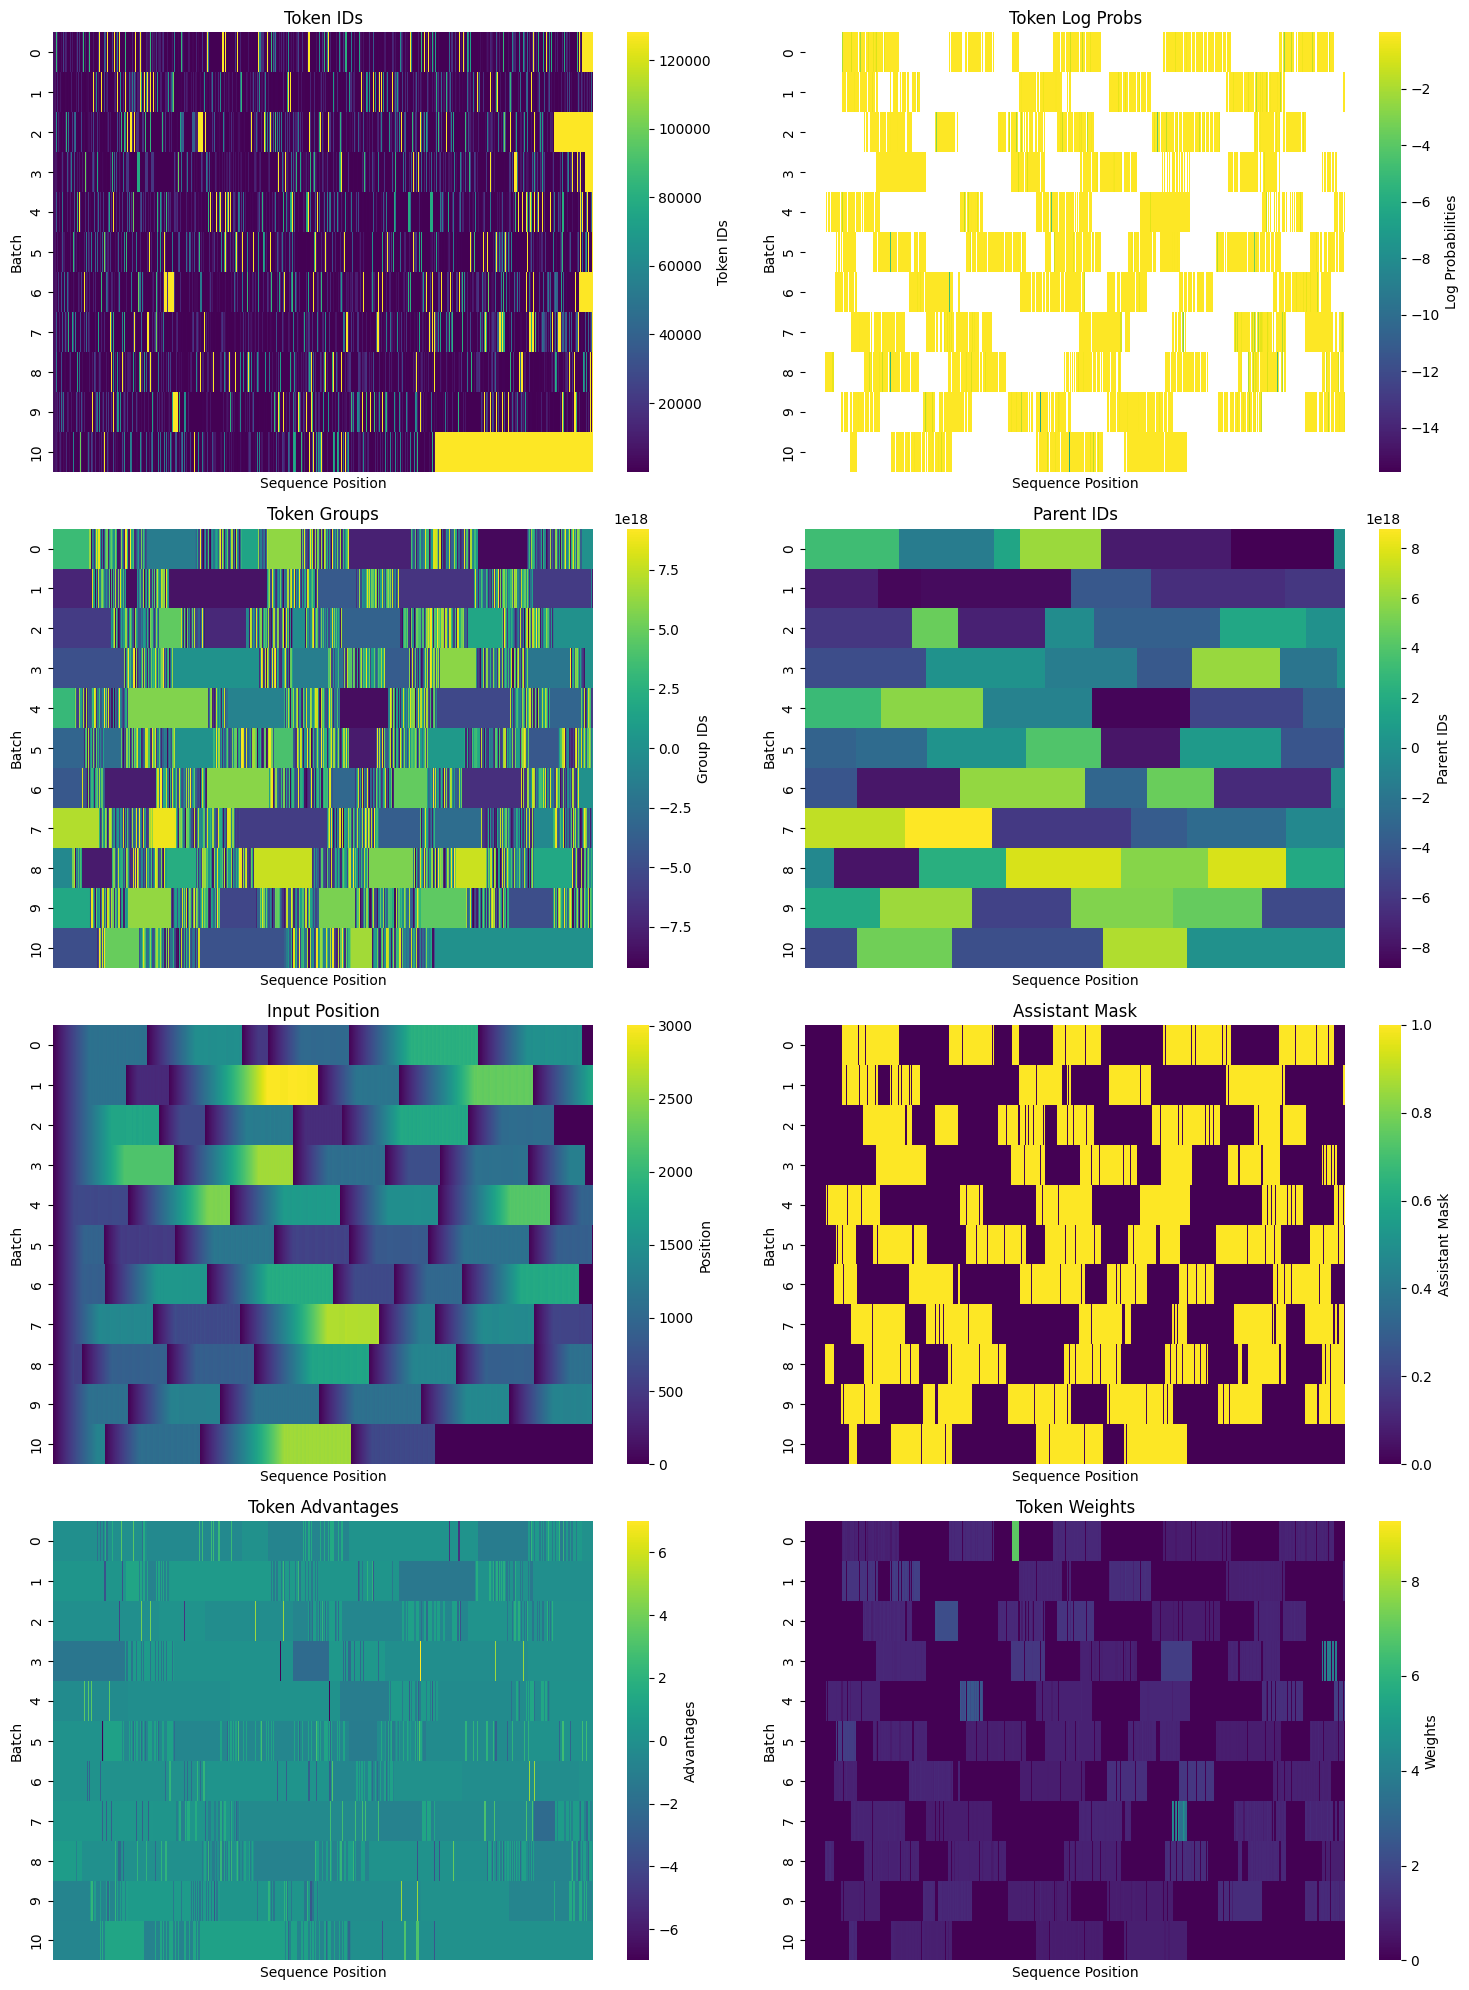

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0006
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740112168.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.11 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0020: 100%|██████████| 5/5 [02:14<00:00, 25.60s/it, entropy=0.262, kl_div=nan, loss=-0.002, policy=-0.002]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.64 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #7 model files to ./models/026/0007
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0007 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0007 --port=8000 --api-key=default
INFO 02-21 04:32:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:32:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:32:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0007', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.22it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.50s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.64s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.41s/it]



INFO 02-21 04:33:05 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:33:06 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 04:33:06 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:33:06 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:33:06 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:33:06 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:33:52 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.01 seconds
INFO 02-21 04:33:53 api_server.py:756] Using supplied chat template:
INFO 02-21 04:33:53 api_server.py:756] None
INFO 02-21 04:33:53 launcher.py:21] Available routes are:
INFO 02-21 04:33:53 launcher.py:29] Route: /

INFO:     Started server process [25317]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:33:56 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:42596 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:05<00:00, 51.68it/s, completion_tokens=35, prompt_tokens=1171, reward=0.393, token_logprobs=112837]
Deleted iteration directory ./models/026/0006


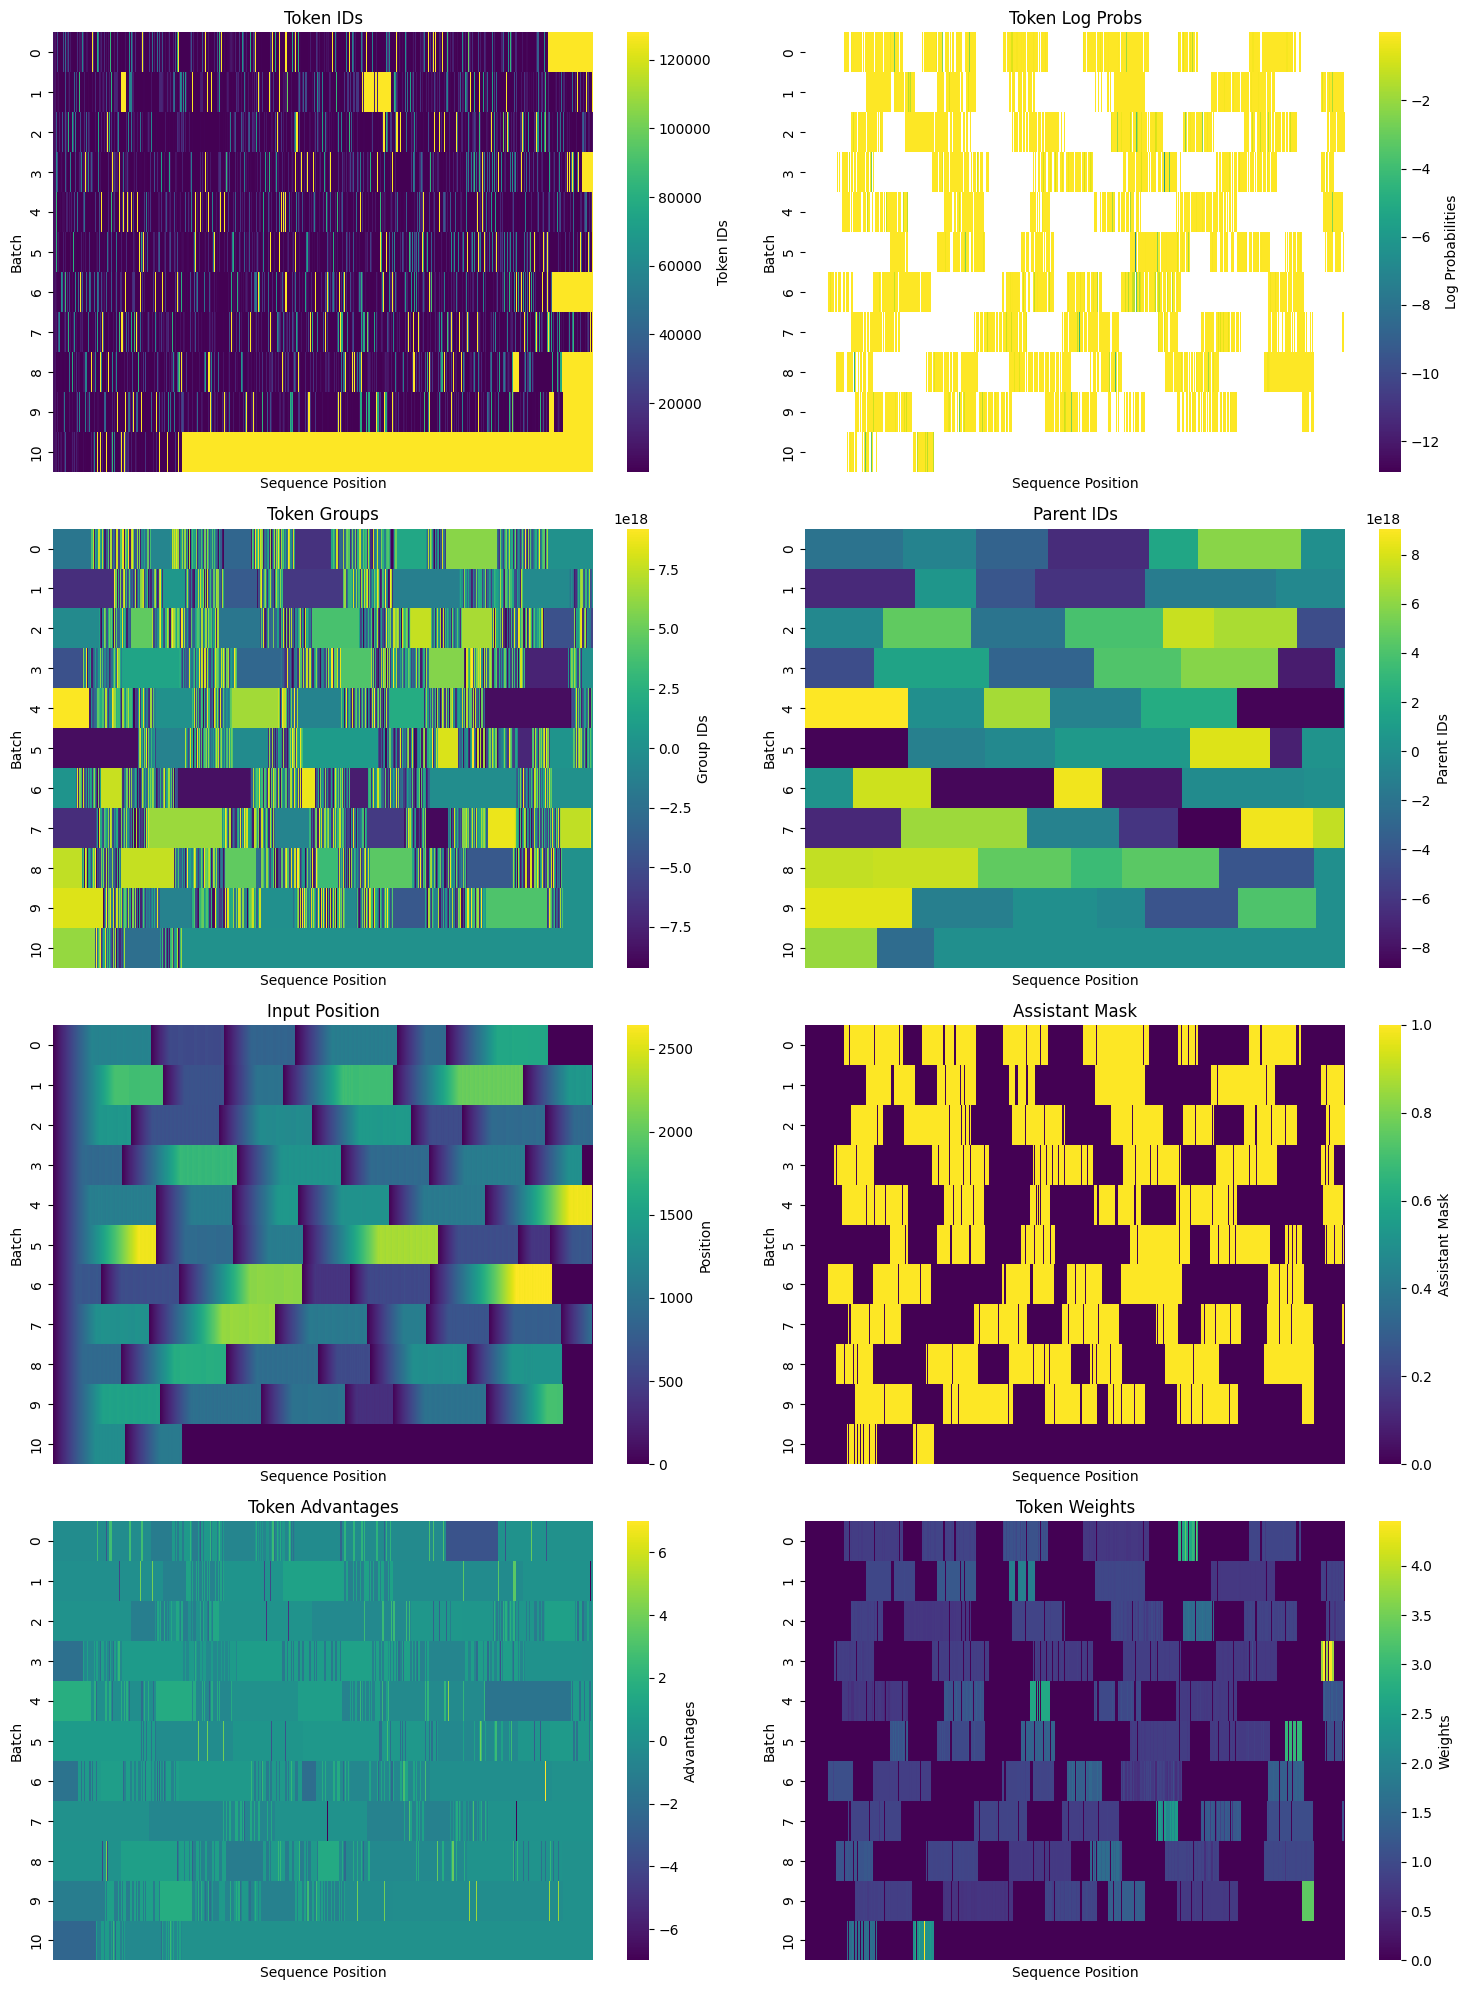

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0007
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740112649.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 38.35 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0013: 100%|██████████| 5/5 [02:18<00:00, 25.88s/it, entropy=0.264, kl_div=nan, loss=0.00131, policy=0.00131]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.80 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #8 model files to ./models/026/0008
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0008 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0008 --port=8000 --api-key=default
INFO 02-21 04:41:07 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:41:08 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:41:08 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0008', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.06s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.80s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.88s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.87s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.73s/it]



INFO 02-21 04:41:31 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:41:32 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 04:41:32 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:41:32 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:41:32 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:41:32 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:42:17 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.46 seconds
INFO 02-21 04:42:18 api_server.py:756] Using supplied chat template:
INFO 02-21 04:42:18 api_server.py:756] None
INFO 02-21 04:42:18 launcher.py:21] Available routes are:
INFO 02-21 04:42:18 launcher.py:29] Route: /

INFO:     Started server process [27224]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:42:25 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 04:42:25 metrics.py:455] Avg prompt throughput: 1.5 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 04:42:25 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:46172 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:49<00:00, 28.19it/s, completion_tokens=35, prompt_tokens=1168, reward=0.399, token_logprobs=112870]
Deleted iteration directory ./models/026/0007
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

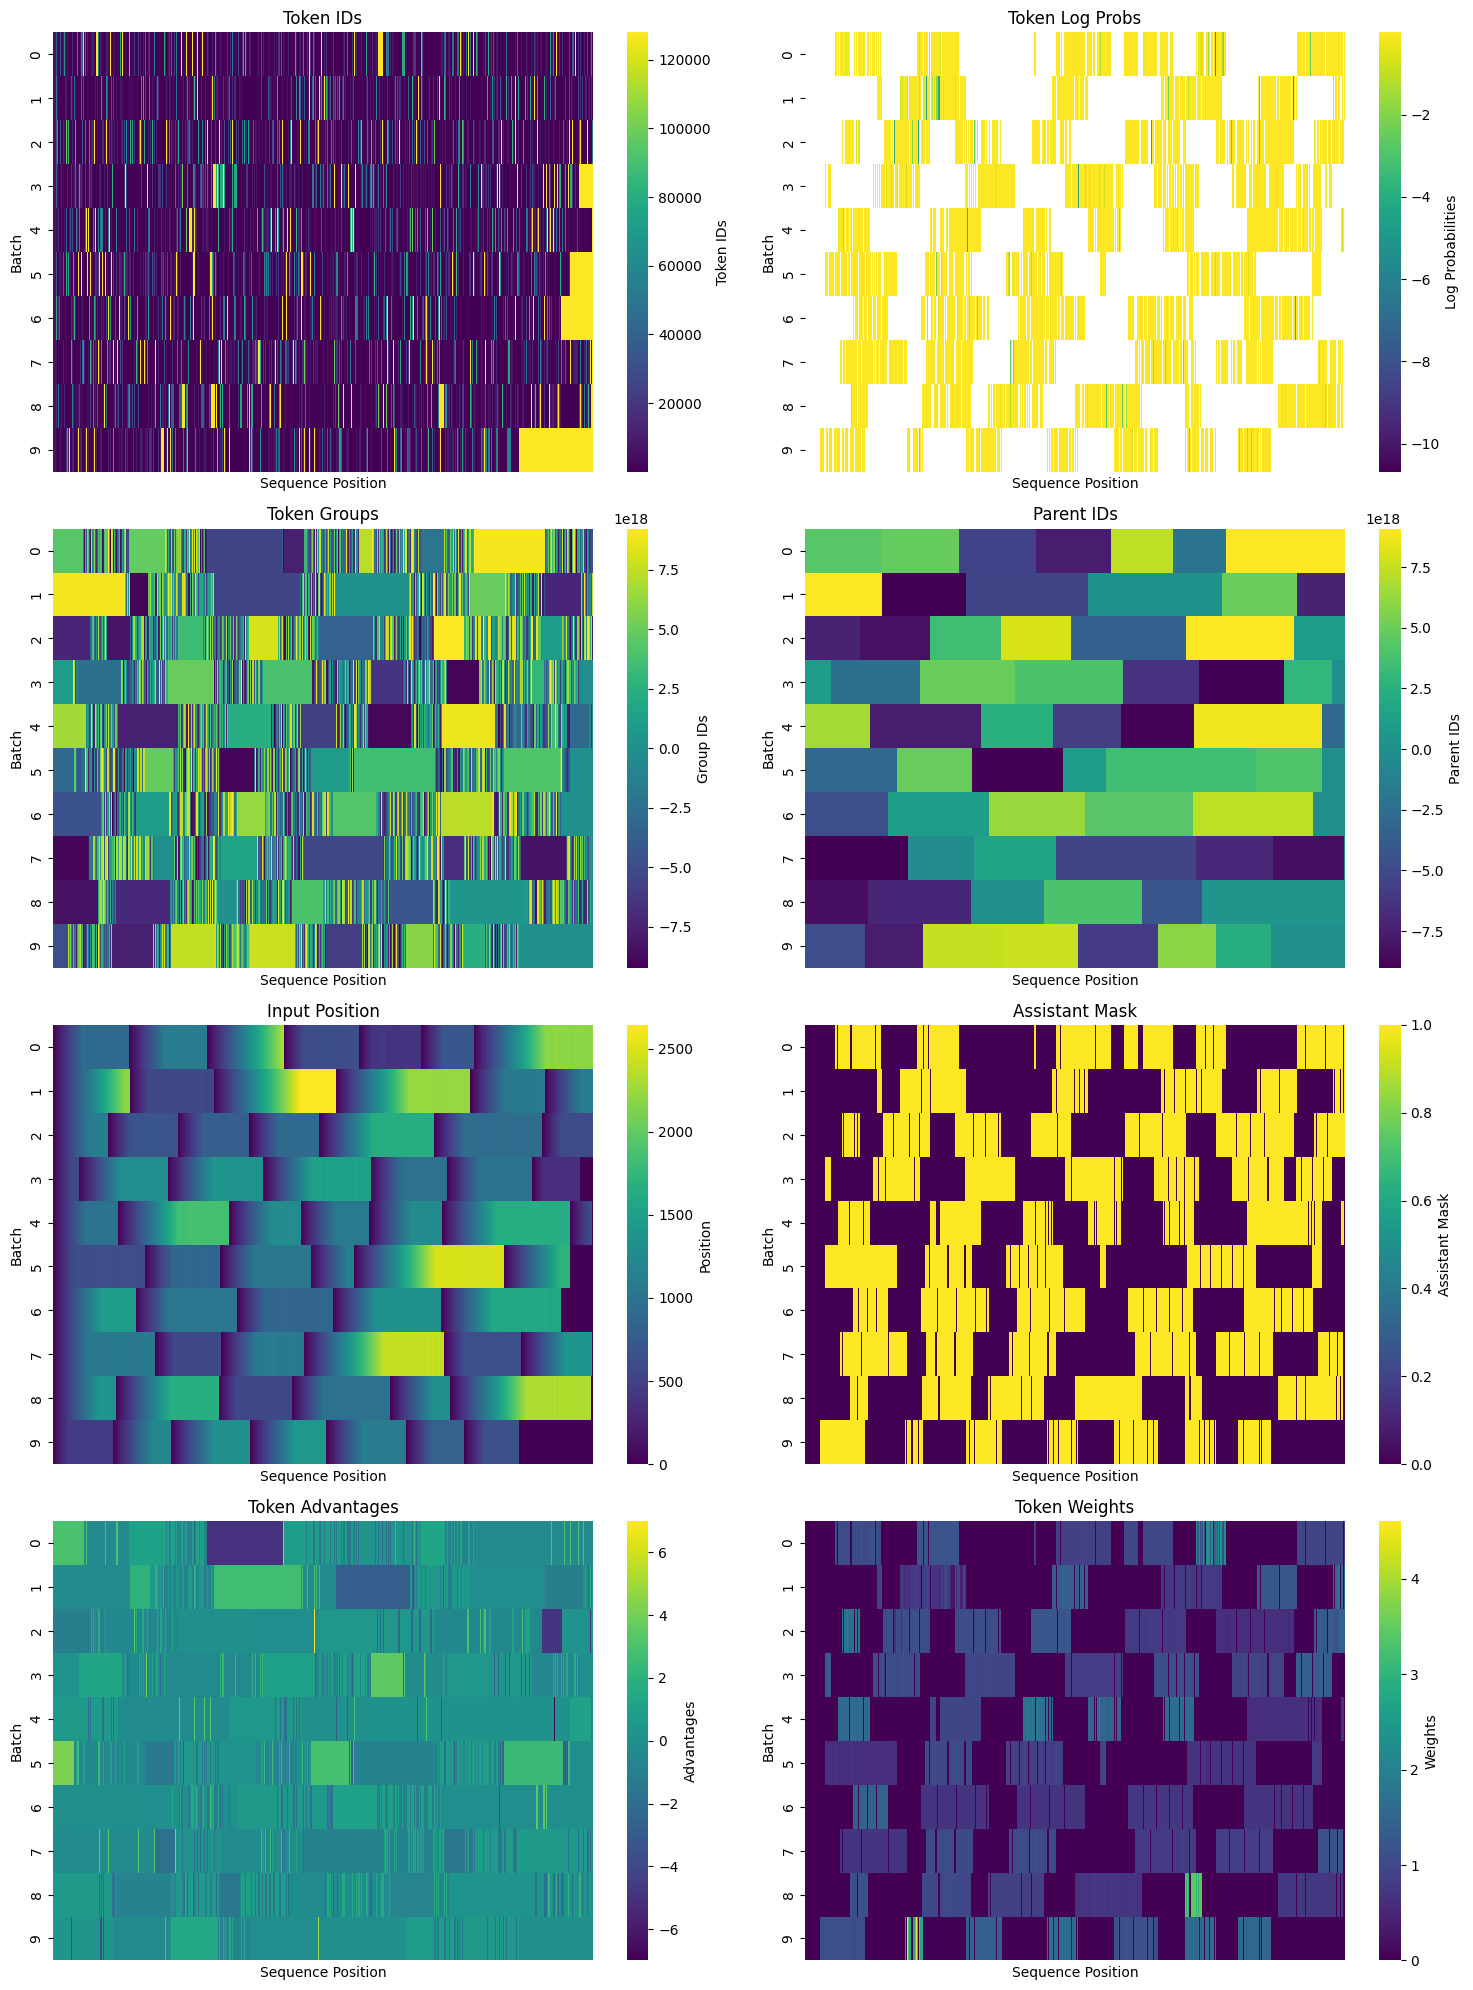

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0008
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740113145.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.15 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0023: 100%|██████████| 5/5 [02:18<00:00, 25.95s/it, entropy=0.199, kl_div=nan, loss=-0.00235, policy=-0.00235]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.90 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #9 model files to ./models/026/0009
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0009 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0009 --port=8000 --api-key=default
INFO 02-21 04:49:07 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:49:08 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:49:08 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0009', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=None

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.19s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:06,  3.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.01s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.95s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.85s/it]



INFO 02-21 04:49:35 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:49:36 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 04:49:36 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:49:36 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:49:36 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:49:36 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:50:25 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 50.88 seconds
INFO 02-21 04:50:26 api_server.py:756] Using supplied chat template:
INFO 02-21 04:50:26 api_server.py:756] None
INFO 02-21 04:50:26 launcher.py:21] Available routes are:
INFO 02-21 04:50:26 launcher.py:29] Route: /

INFO:     Started server process [29135]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:50:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59410 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:24<00:00, 116.67it/s, completion_tokens=36, prompt_tokens=1252, reward=0.389, token_logprobs=114968]
Deleted iteration directory ./models/026/0008
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion

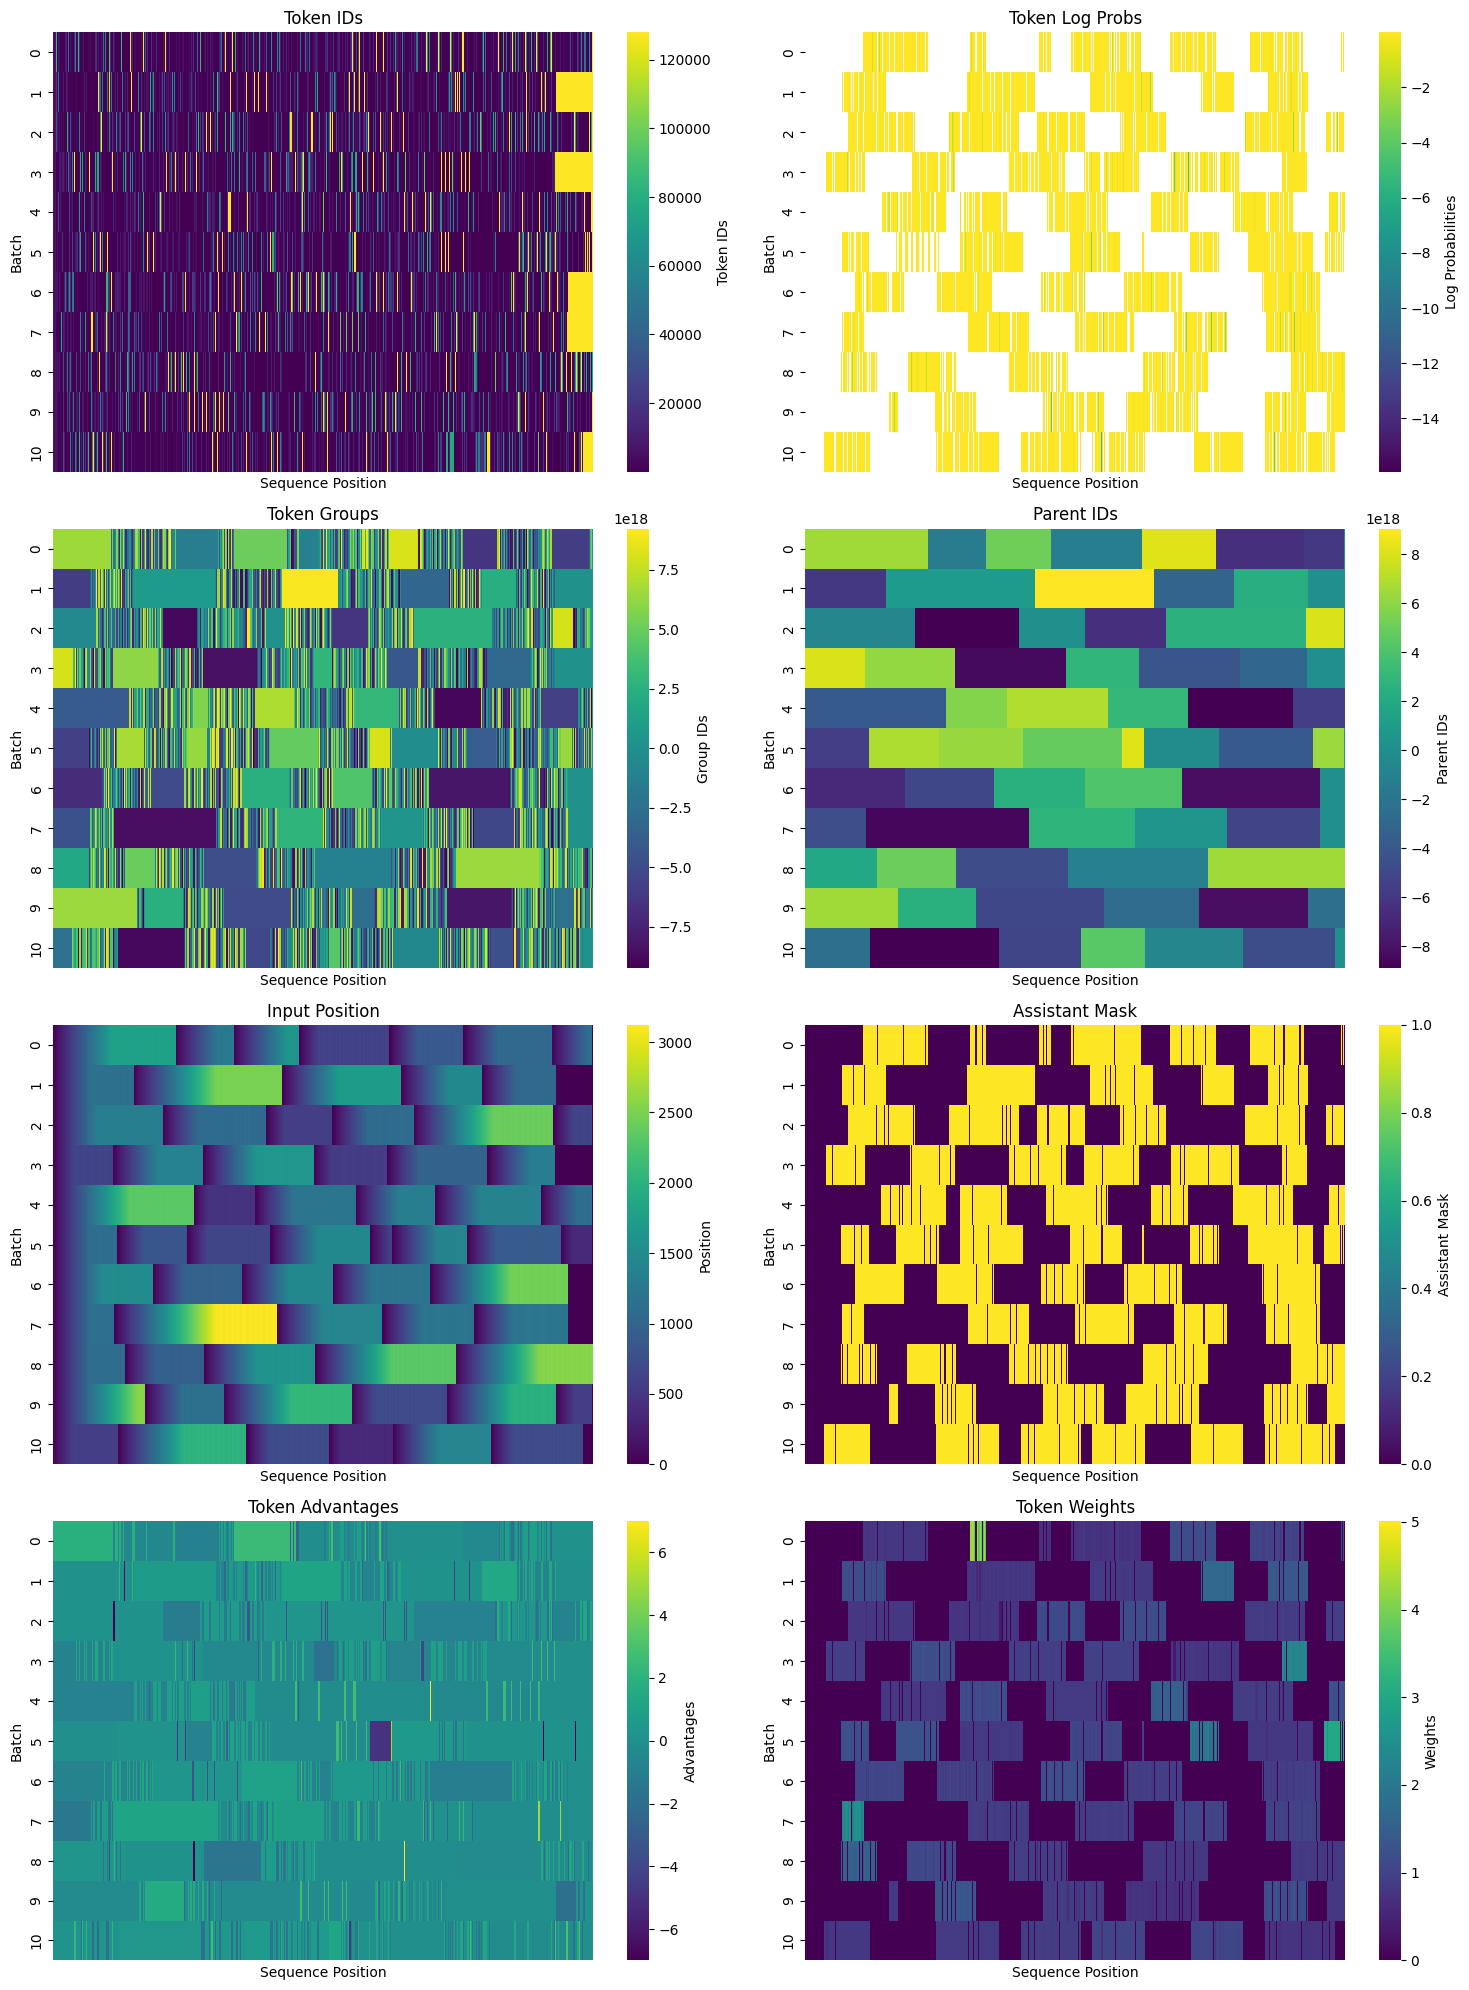

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0009
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740113607.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.28 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0009: 100%|██████████| 5/5 [02:14<00:00, 25.62s/it, entropy=0.121, kl_div=nan, loss=-0.000935, policy=-0.000935]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.40 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #10 model files to ./models/026/0010
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0010 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0010 --port=8000 --api-key=default
INFO 02-21 04:56:48 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 04:56:49 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 04:56:49 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0010', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.09it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:04,  2.42s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.72s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.53s/it]



INFO 02-21 04:57:15 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 04:57:16 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 04:57:16 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 04:57:16 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 04:57:16 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 04:57:16 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 04:58:00 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.60 seconds
INFO 02-21 04:58:01 api_server.py:756] Using supplied chat template:
INFO 02-21 04:58:01 api_server.py:756] None
INFO 02-21 04:58:01 launcher.py:21] Available routes are:
INFO 02-21 04:58:01 launcher.py:29] Route: /

INFO:     Started server process [31073]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 04:58:05 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:57128 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:20<00:00, 65.01it/s, completion_tokens=35, prompt_tokens=1260, reward=0.39, token_logprobs=112889]
Deleted iteration directory ./models/026/0005
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion t

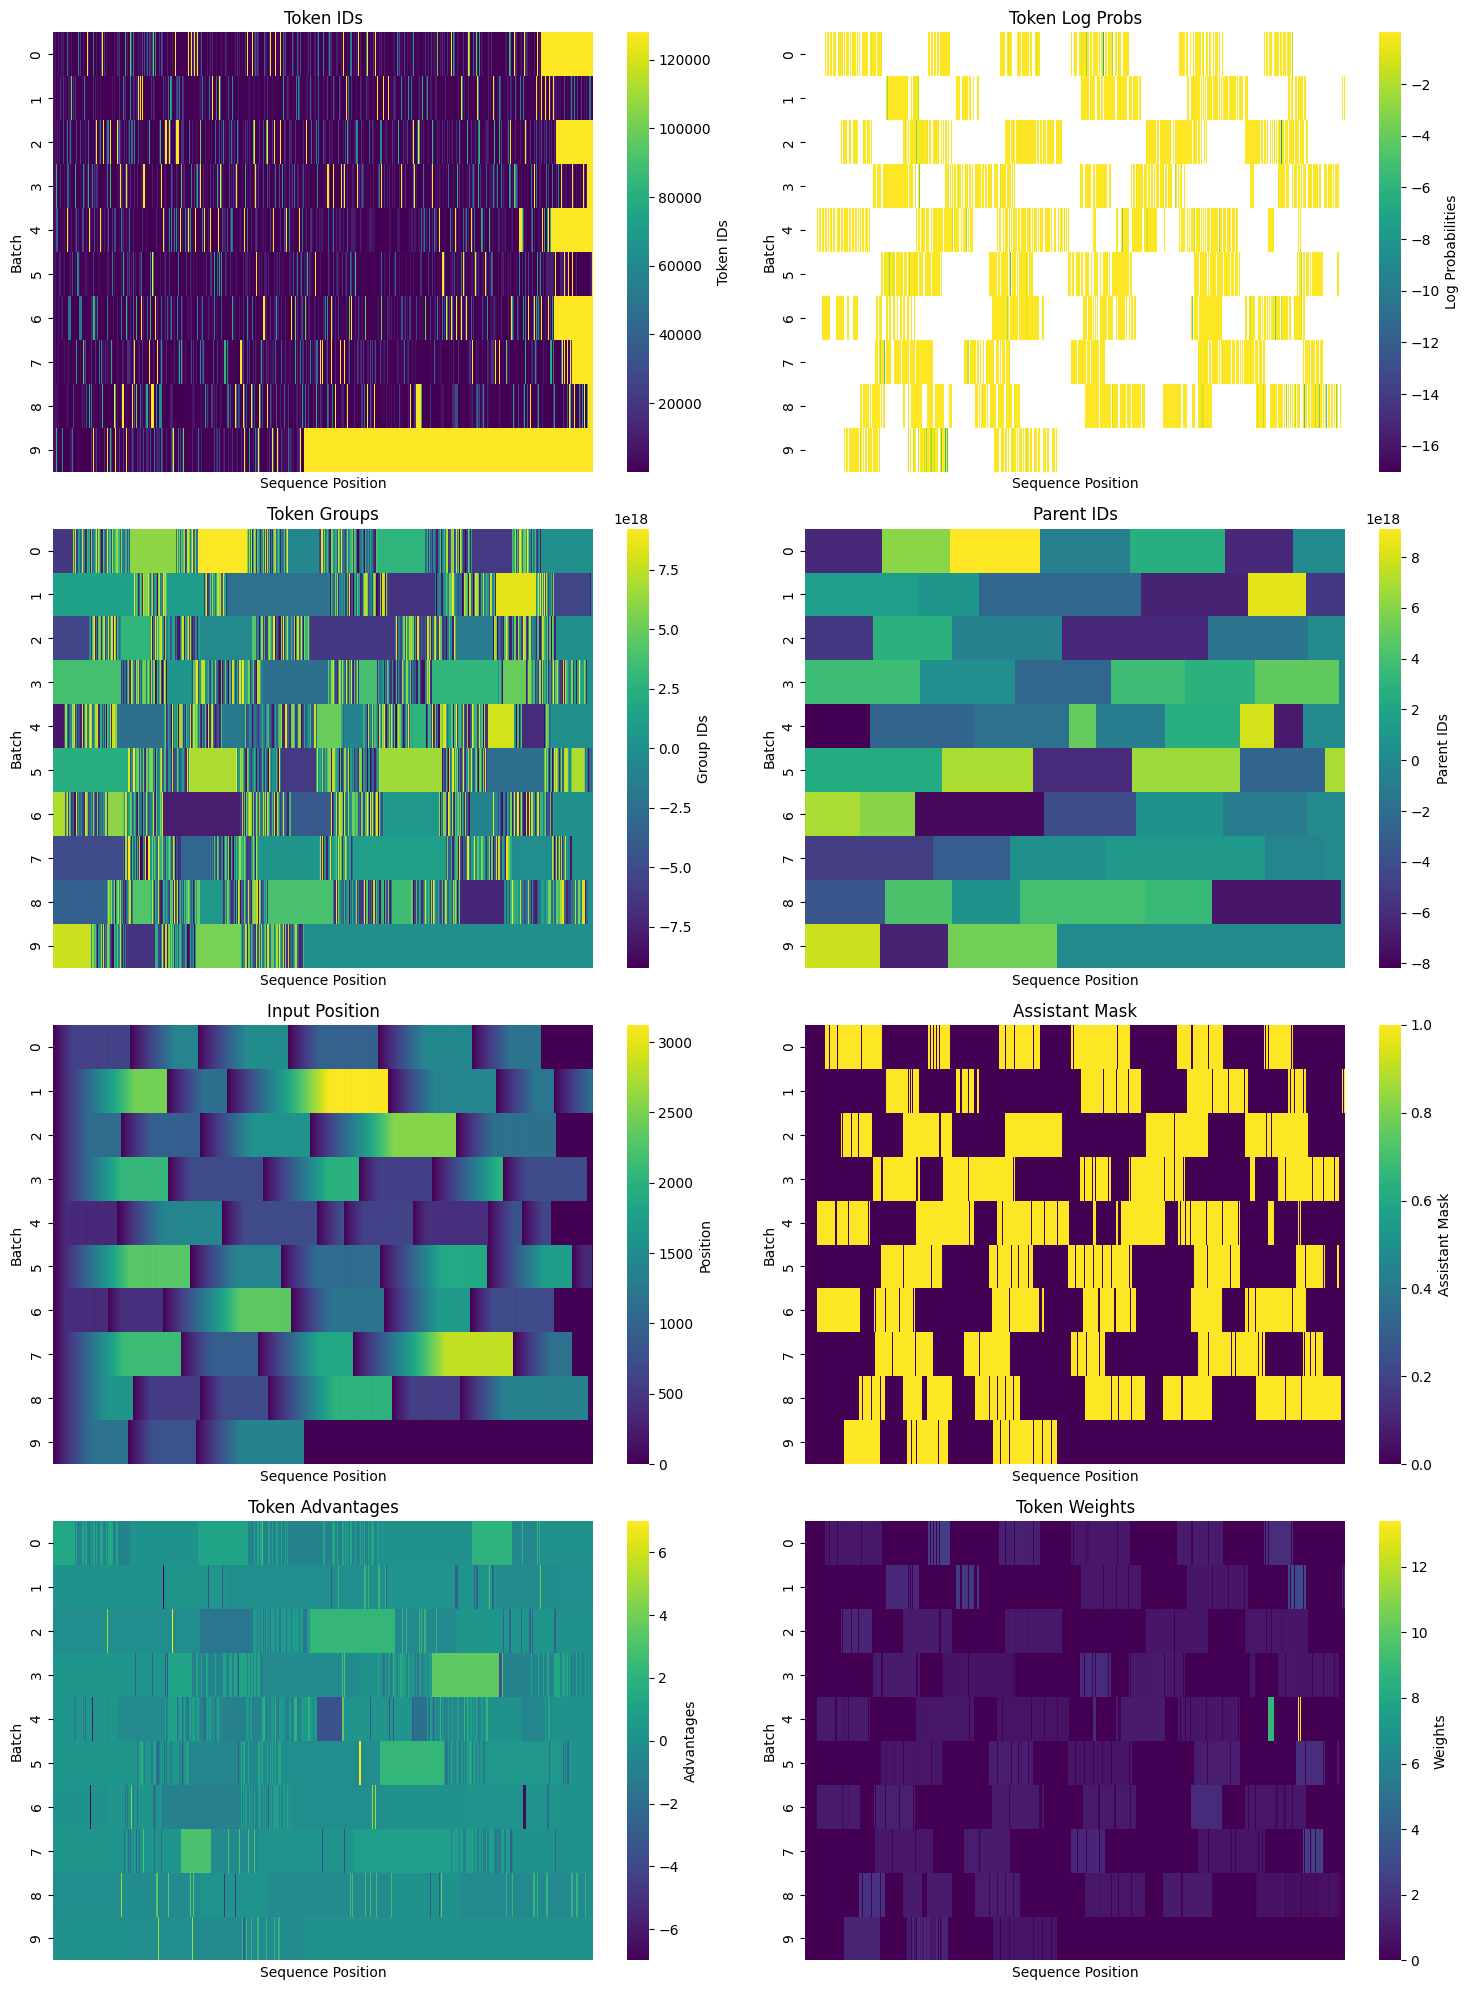

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0010
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740114061.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 38.90 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0029: 100%|██████████| 5/5 [02:18<00:00, 25.97s/it, entropy=0.156, kl_div=nan, loss=0.00292, policy=0.00292]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.39 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #11 model files to ./models/026/0011
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0011 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0011 --port=8000 --api-key=default
INFO 02-21 05:04:43 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:04:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:04:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0011', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.29s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:06,  3.38s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:09<00:03,  3.20s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.07s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.00s/it]



INFO 02-21 05:05:11 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:05:12 worker.py:267] Memory profiling takes 0.87 seconds
INFO 02-21 05:05:12 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:05:12 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:05:12 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:05:12 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:06:04 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 53.30 seconds
INFO 02-21 05:06:05 api_server.py:756] Using supplied chat template:
INFO 02-21 05:06:05 api_server.py:756] None
INFO 02-21 05:06:05 launcher.py:21] Available routes are:
INFO 02-21 05:06:05 launcher.py:29] Route: /

INFO:     Started server process [32998]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:06:07 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:50062 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:34<00:00, 98.96it/s, completion_tokens=35, prompt_tokens=1275, reward=0.414, token_logprobs=111076]
Deleted iteration directory ./models/026/0010
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

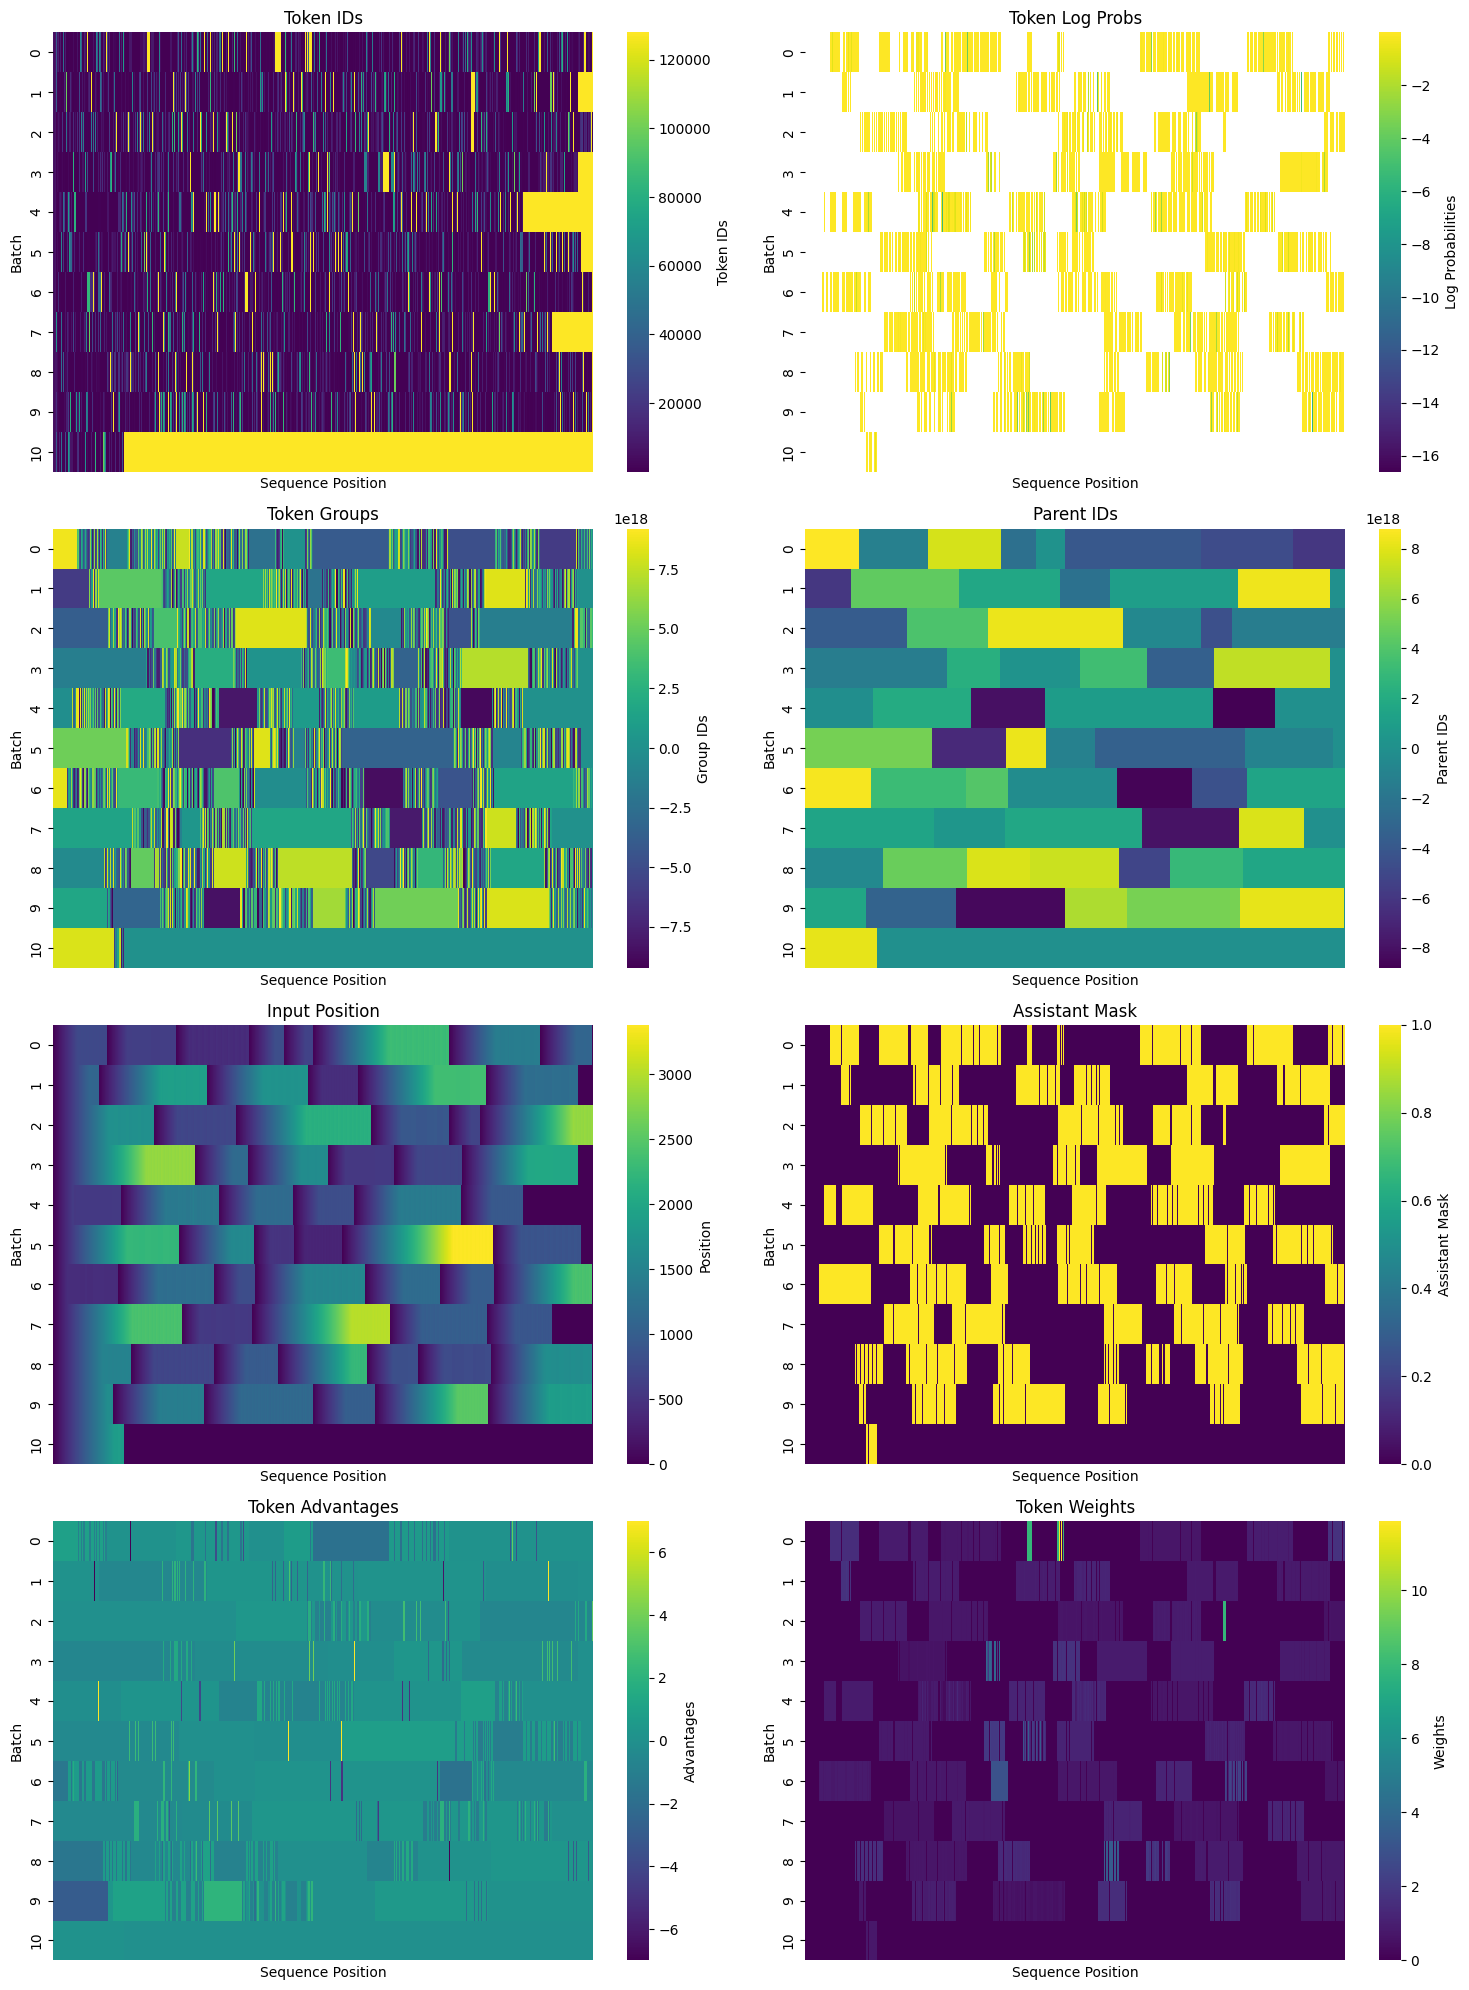

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0011
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740114556.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 36.12 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0030: 100%|██████████| 5/5 [02:21<00:00, 26.40s/it, entropy=0.198, kl_div=nan, loss=-0.00301, policy=-0.00301]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.25 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #12 model files to ./models/026/0012
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0012 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0012 --port=8000 --api-key=default
INFO 02-21 05:12:59 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:13:00 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:13:00 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0012', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:04,  2.41s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.67s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.75s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.56s/it]



INFO 02-21 05:13:21 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:13:22 worker.py:267] Memory profiling takes 0.90 seconds
INFO 02-21 05:13:22 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:13:22 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:13:22 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:13:22 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:14:11 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 49.89 seconds
INFO 02-21 05:14:11 api_server.py:756] Using supplied chat template:
INFO 02-21 05:14:11 api_server.py:756] None
INFO 02-21 05:14:11 launcher.py:21] Available routes are:
INFO 02-21 05:14:11 launcher.py:29] Route: /

INFO:     Started server process [34902]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:14:16 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:33434 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:54<00:00, 64.61it/s, completion_tokens=34, prompt_tokens=1282, reward=0.445, token_logprobs=110130]
Deleted iteration directory ./models/026/0009
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

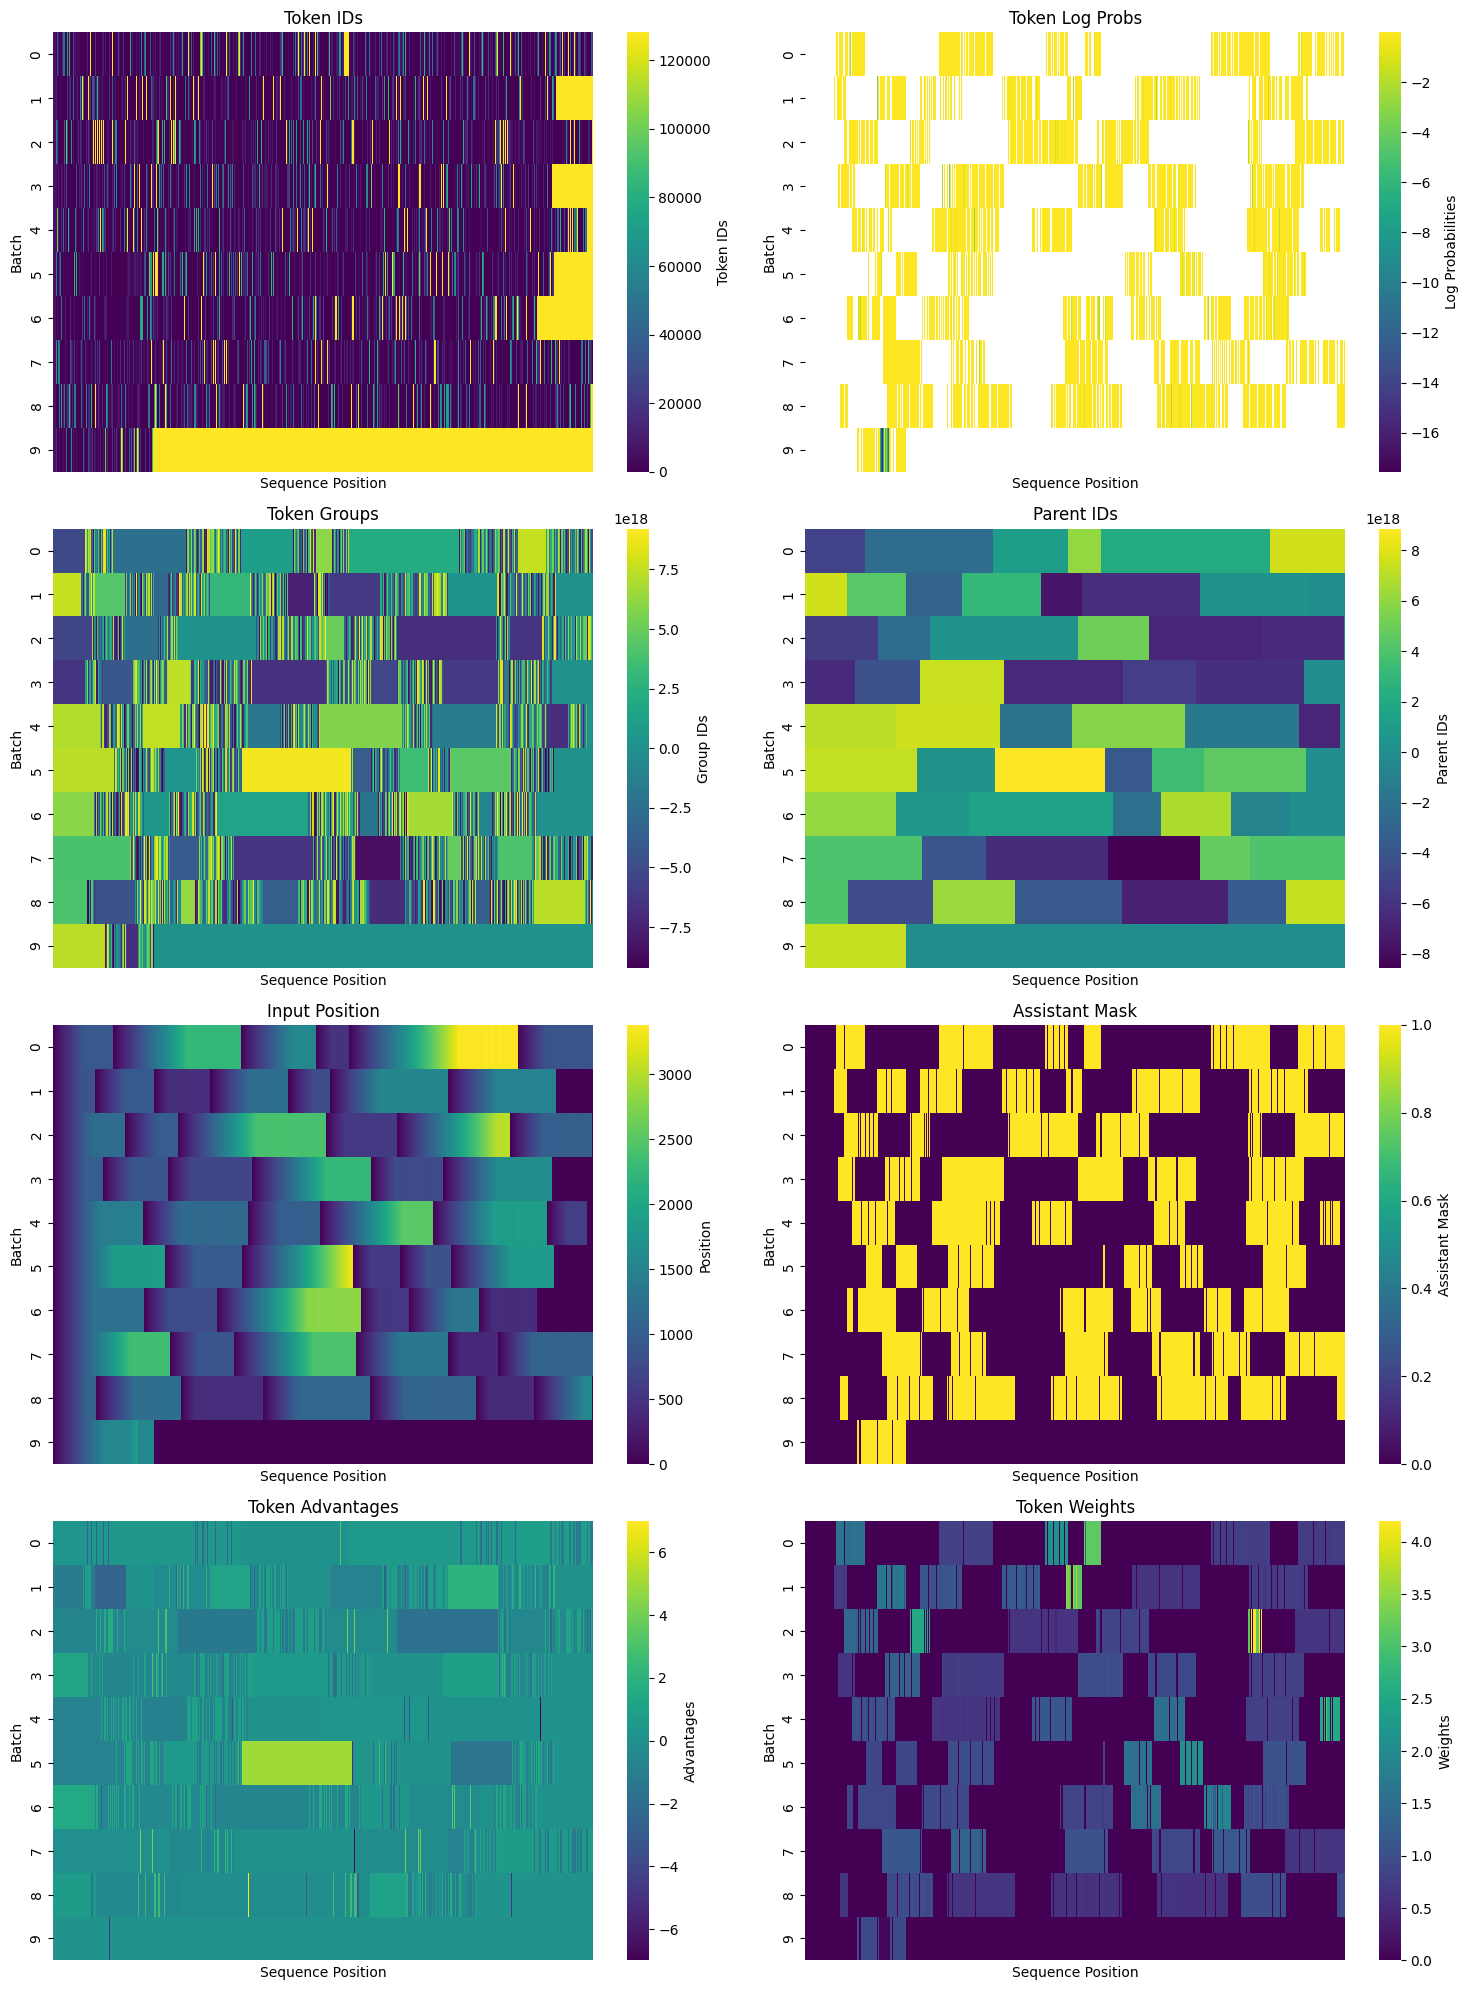

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0012
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740115002.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 31.28 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: -0.0039: 100%|██████████| 5/5 [02:21<00:00, 26.11s/it, entropy=0.124, kl_div=nan, loss=-0.00389, policy=-0.00389]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.83 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #13 model files to ./models/026/0013
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0013 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0013 --port=8000 --api-key=default
INFO 02-21 05:20:22 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:20:23 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:20:23 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0013', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.10s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:05,  2.67s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.80s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.82s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.67s/it]



INFO 02-21 05:20:44 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:20:45 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 05:20:45 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:20:45 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:20:45 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:20:45 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:21:36 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 52.53 seconds
INFO 02-21 05:21:37 api_server.py:756] Using supplied chat template:
INFO 02-21 05:21:37 api_server.py:756] None
INFO 02-21 05:21:37 launcher.py:21] Available routes are:
INFO 02-21 05:21:37 launcher.py:29] Route: /

INFO:     Started server process [36843]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:21:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 05:21:42 metrics.py:455] Avg prompt throughput: 1.9 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 05:21:42 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:60588 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:11<00:00, 132.46it/s, completion_tokens=34, prompt_tokens=1131, reward=0.434, token_logprobs=108087]
Deleted iteration directory ./models/026/0011
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion

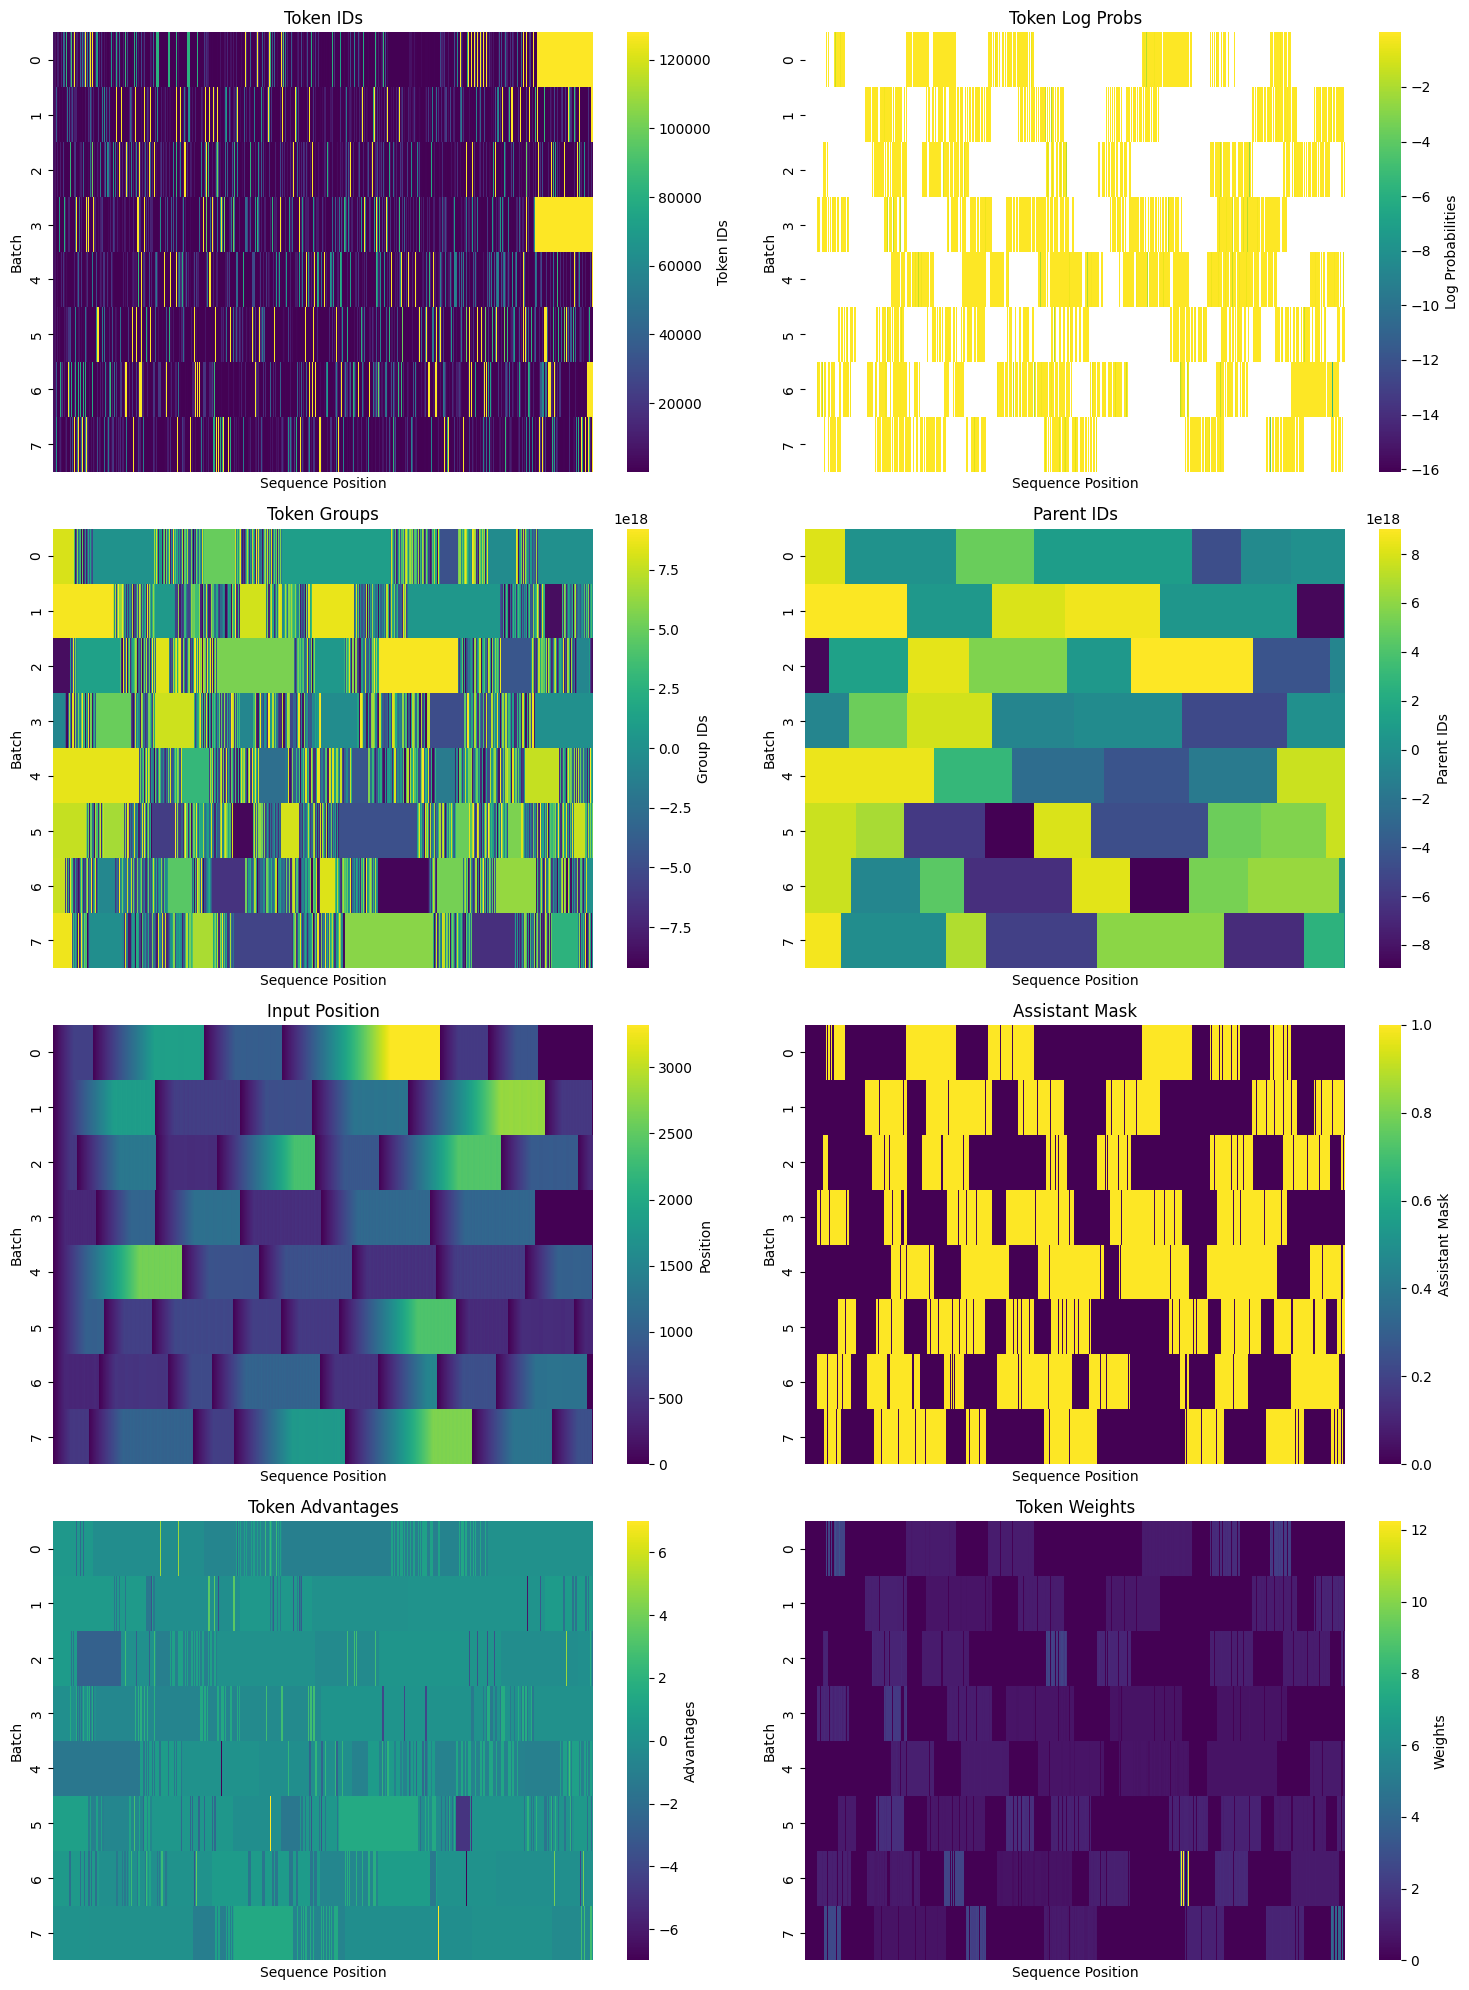

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0013
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 8
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740115465.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 39.55 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: -0.0006: 100%|██████████| 4/4 [01:52<00:00, 26.42s/it, entropy=0.0978, kl_div=nan, loss=-0.000555, policy=-0.000555]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.69 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sa

Saved iteration #14 model files to ./models/026/0014
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0014 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0014 --port=8000 --api-key=default
INFO 02-21 05:27:44 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:27:45 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:27:45 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0014', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.40it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.07s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.48s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.62s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.38s/it]



INFO 02-21 05:28:06 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:28:07 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 05:28:07 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:28:07 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:28:07 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:28:07 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:28:52 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 46.22 seconds
INFO 02-21 05:28:53 api_server.py:756] Using supplied chat template:
INFO 02-21 05:28:53 api_server.py:756] None
INFO 02-21 05:28:53 launcher.py:21] Available routes are:
INFO 02-21 05:28:53 launcher.py:29] Route: /

INFO:     Started server process [39321]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:28:55 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:60570 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:36<00:00, 97.94it/s, completion_tokens=35, prompt_tokens=1220, reward=0.385, token_logprobs=110620]
Deleted iteration directory ./models/026/0012
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

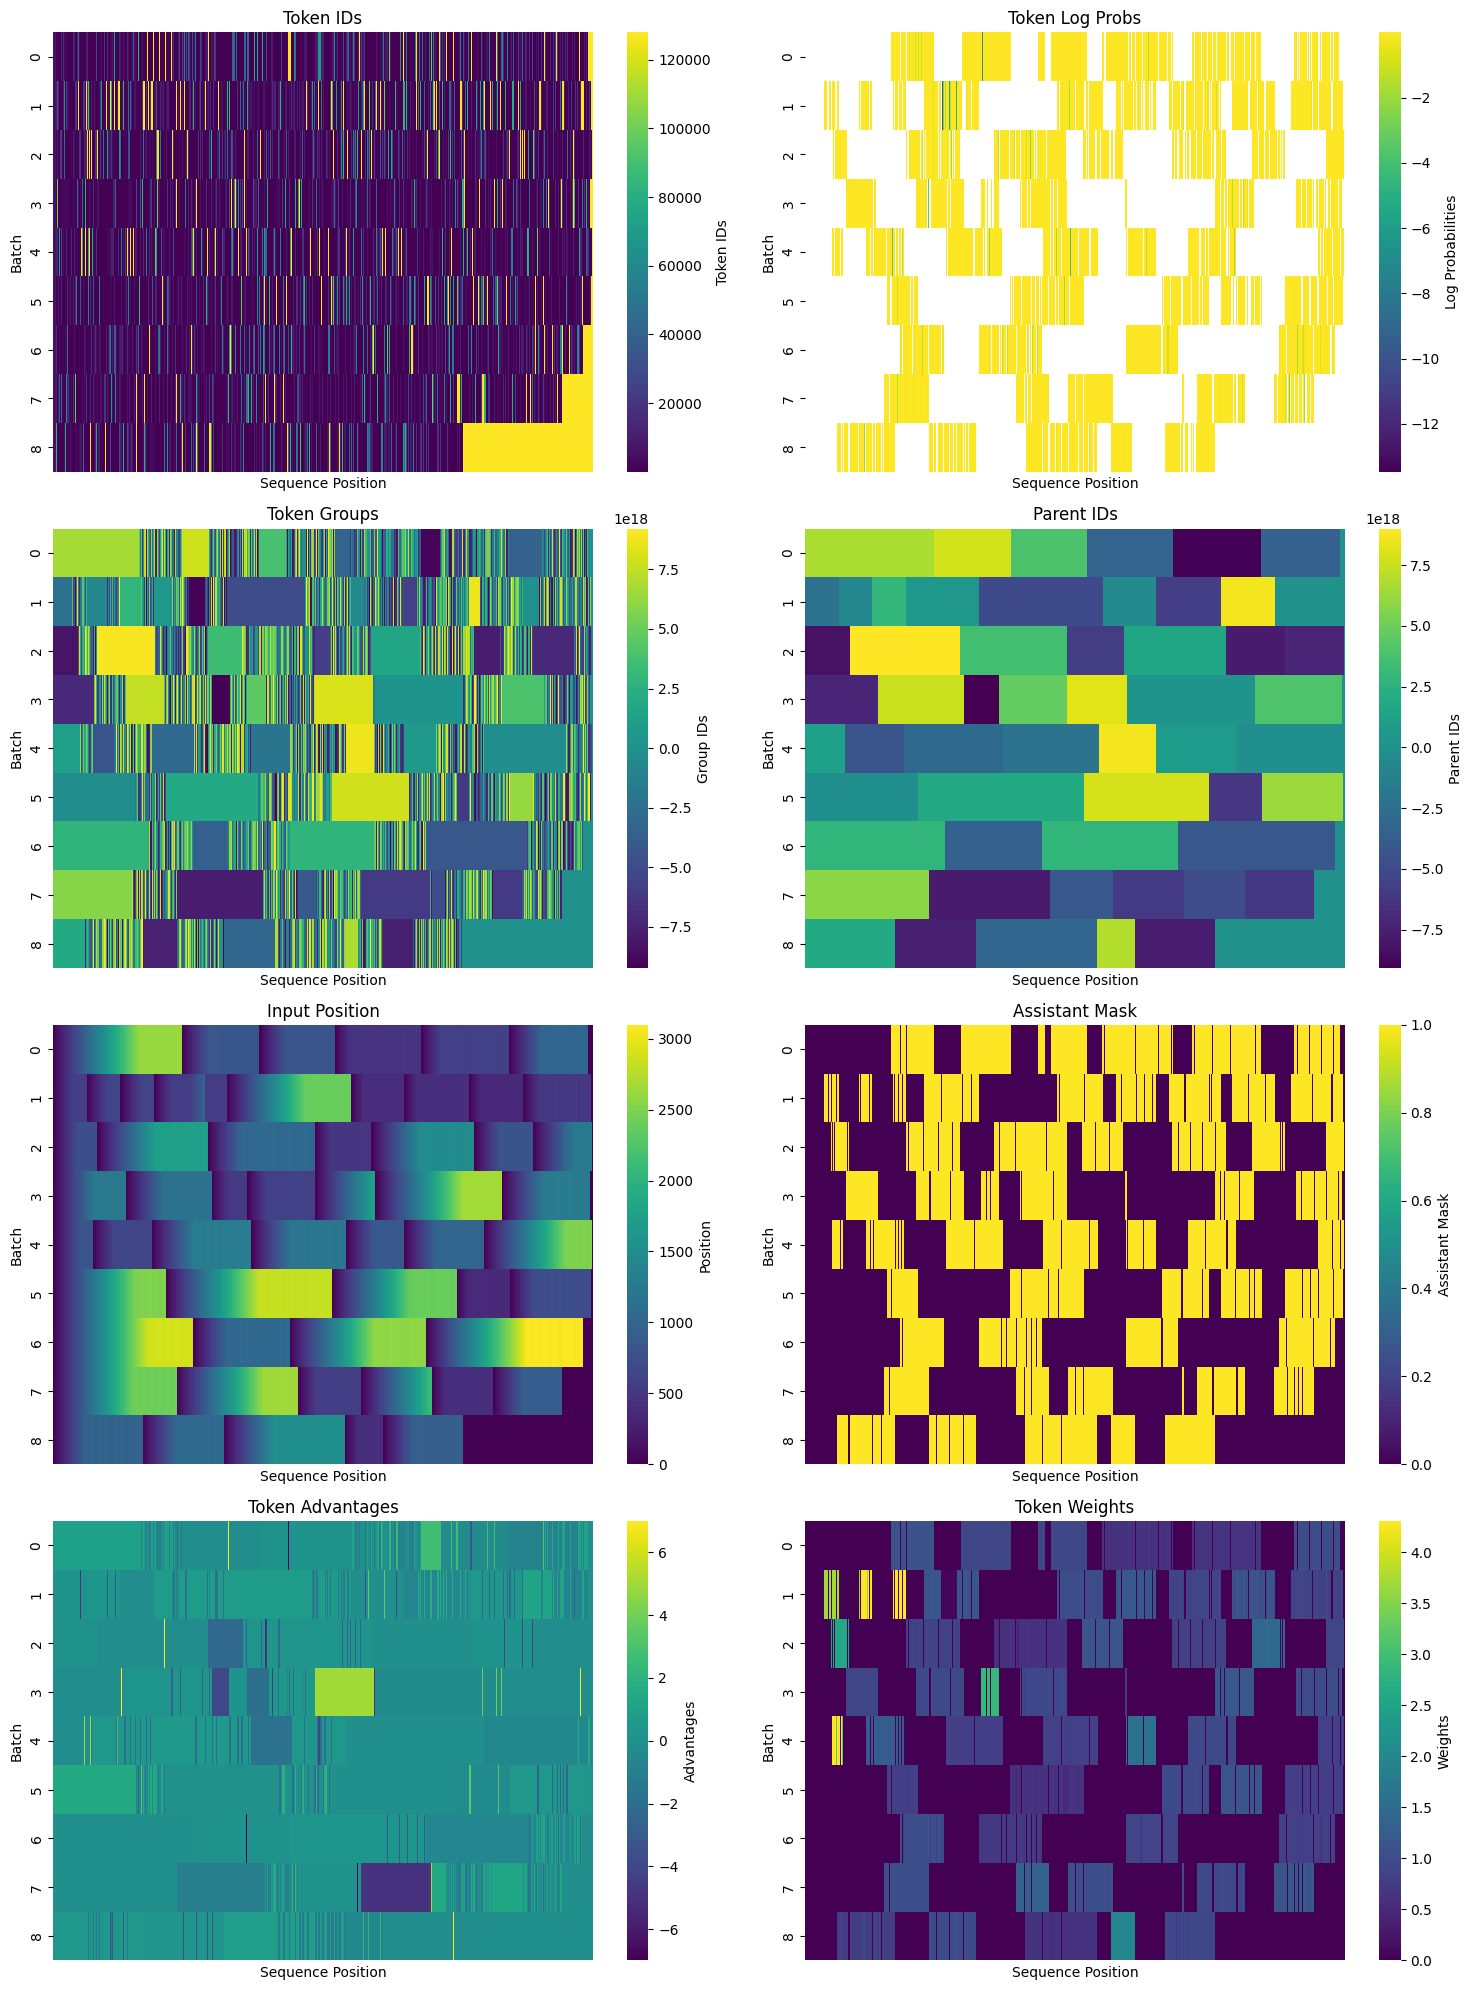

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0014
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740115917.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.74 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: -0.0020: 100%|██████████| 4/4 [01:50<00:00, 26.27s/it, entropy=0.121, kl_div=nan, loss=-0.002, policy=-0.002]     INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.27 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #15 model files to ./models/026/0015
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0015 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0015 --port=8000 --api-key=default
INFO 02-21 05:34:57 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:34:59 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:34:59 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0015', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.42it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.06s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.46s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.61s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.37s/it]



INFO 02-21 05:35:20 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:35:21 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 05:35:21 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:35:21 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:35:21 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:35:21 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:36:05 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.29 seconds
INFO 02-21 05:36:06 api_server.py:756] Using supplied chat template:
INFO 02-21 05:36:06 api_server.py:756] None
INFO 02-21 05:36:06 launcher.py:21] Available routes are:
INFO 02-21 05:36:06 launcher.py:29] Route: /

INFO:     Started server process [41260]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:36:08 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:43644 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:25<00:00, 99.02it/s, completion_tokens=36, prompt_tokens=1343, reward=0.375, token_logprobs=114805]
Deleted iteration directory ./models/026/0013
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

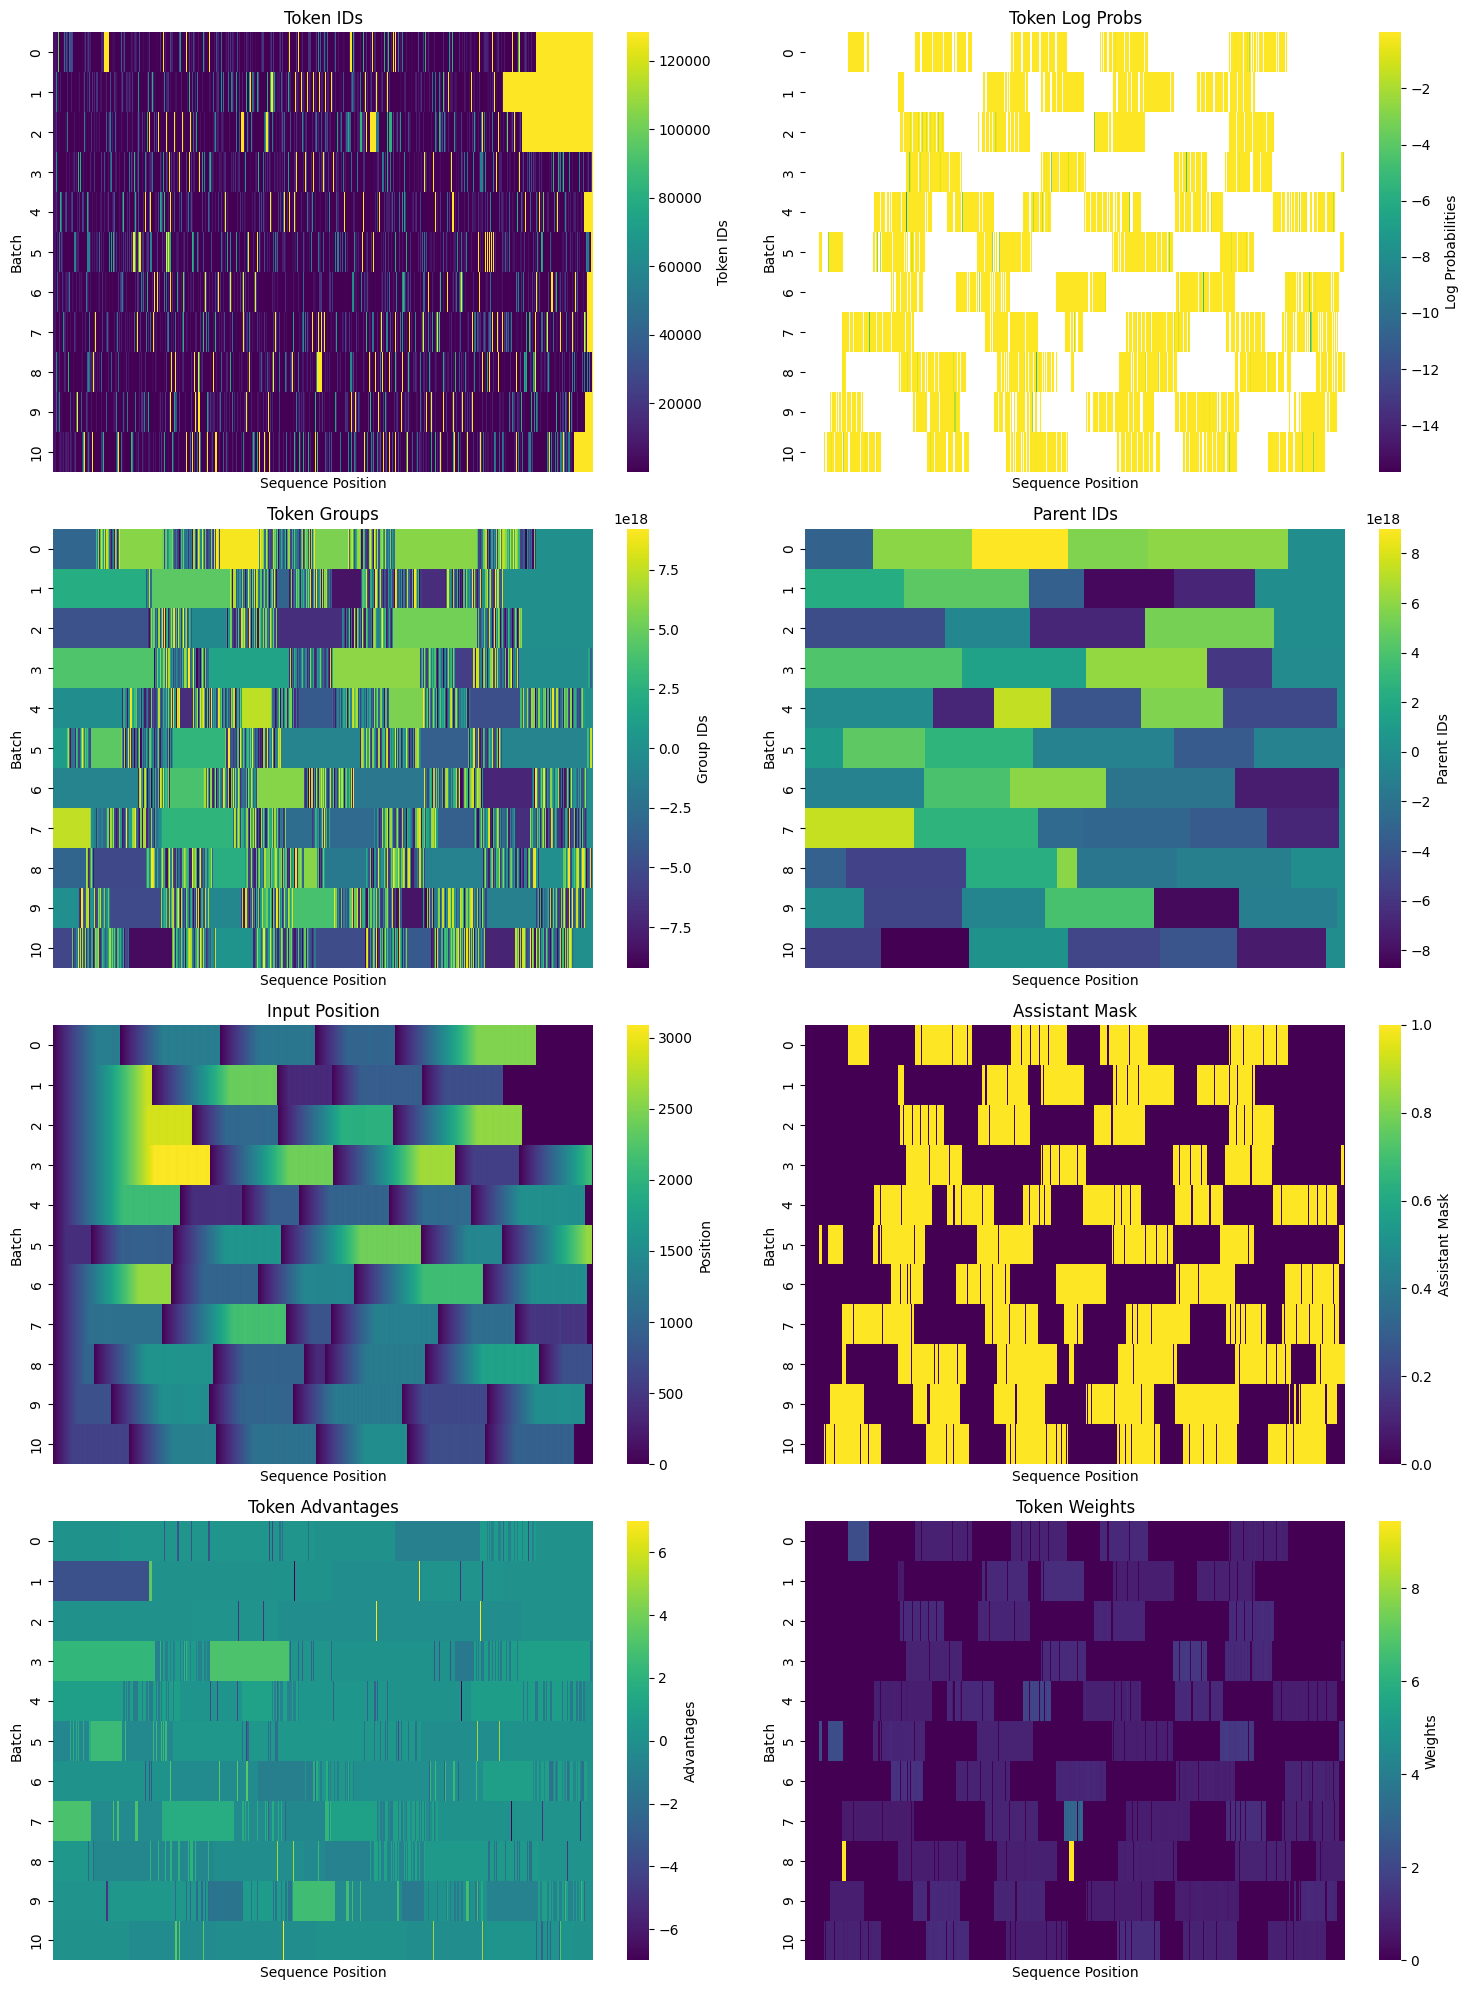

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0015
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 11
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740116341.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.32 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0087: 100%|██████████| 5/5 [02:15<00:00, 25.57s/it, entropy=0.148, kl_div=nan, loss=0.0087, policy=0.0087]      INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.59 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #16 model files to ./models/026/0016
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0016 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0016 --port=8000 --api-key=default
INFO 02-21 05:42:26 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:42:27 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:42:27 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0016', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.45it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.08s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.49s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.40s/it]



INFO 02-21 05:42:48 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:42:49 worker.py:267] Memory profiling takes 0.91 seconds
INFO 02-21 05:42:49 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:42:49 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:42:50 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:42:50 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:43:34 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 45.81 seconds
INFO 02-21 05:43:35 api_server.py:756] Using supplied chat template:
INFO 02-21 05:43:35 api_server.py:756] None
INFO 02-21 05:43:35 launcher.py:21] Available routes are:
INFO 02-21 05:43:35 launcher.py:29] Route: /

INFO:     Started server process [43188]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:43:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:59164 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [01:51<00:00, 23.91it/s, completion_tokens=35, prompt_tokens=1174, reward=0.37, token_logprobs=113337]
Deleted iteration directory ./models/026/0015
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion t

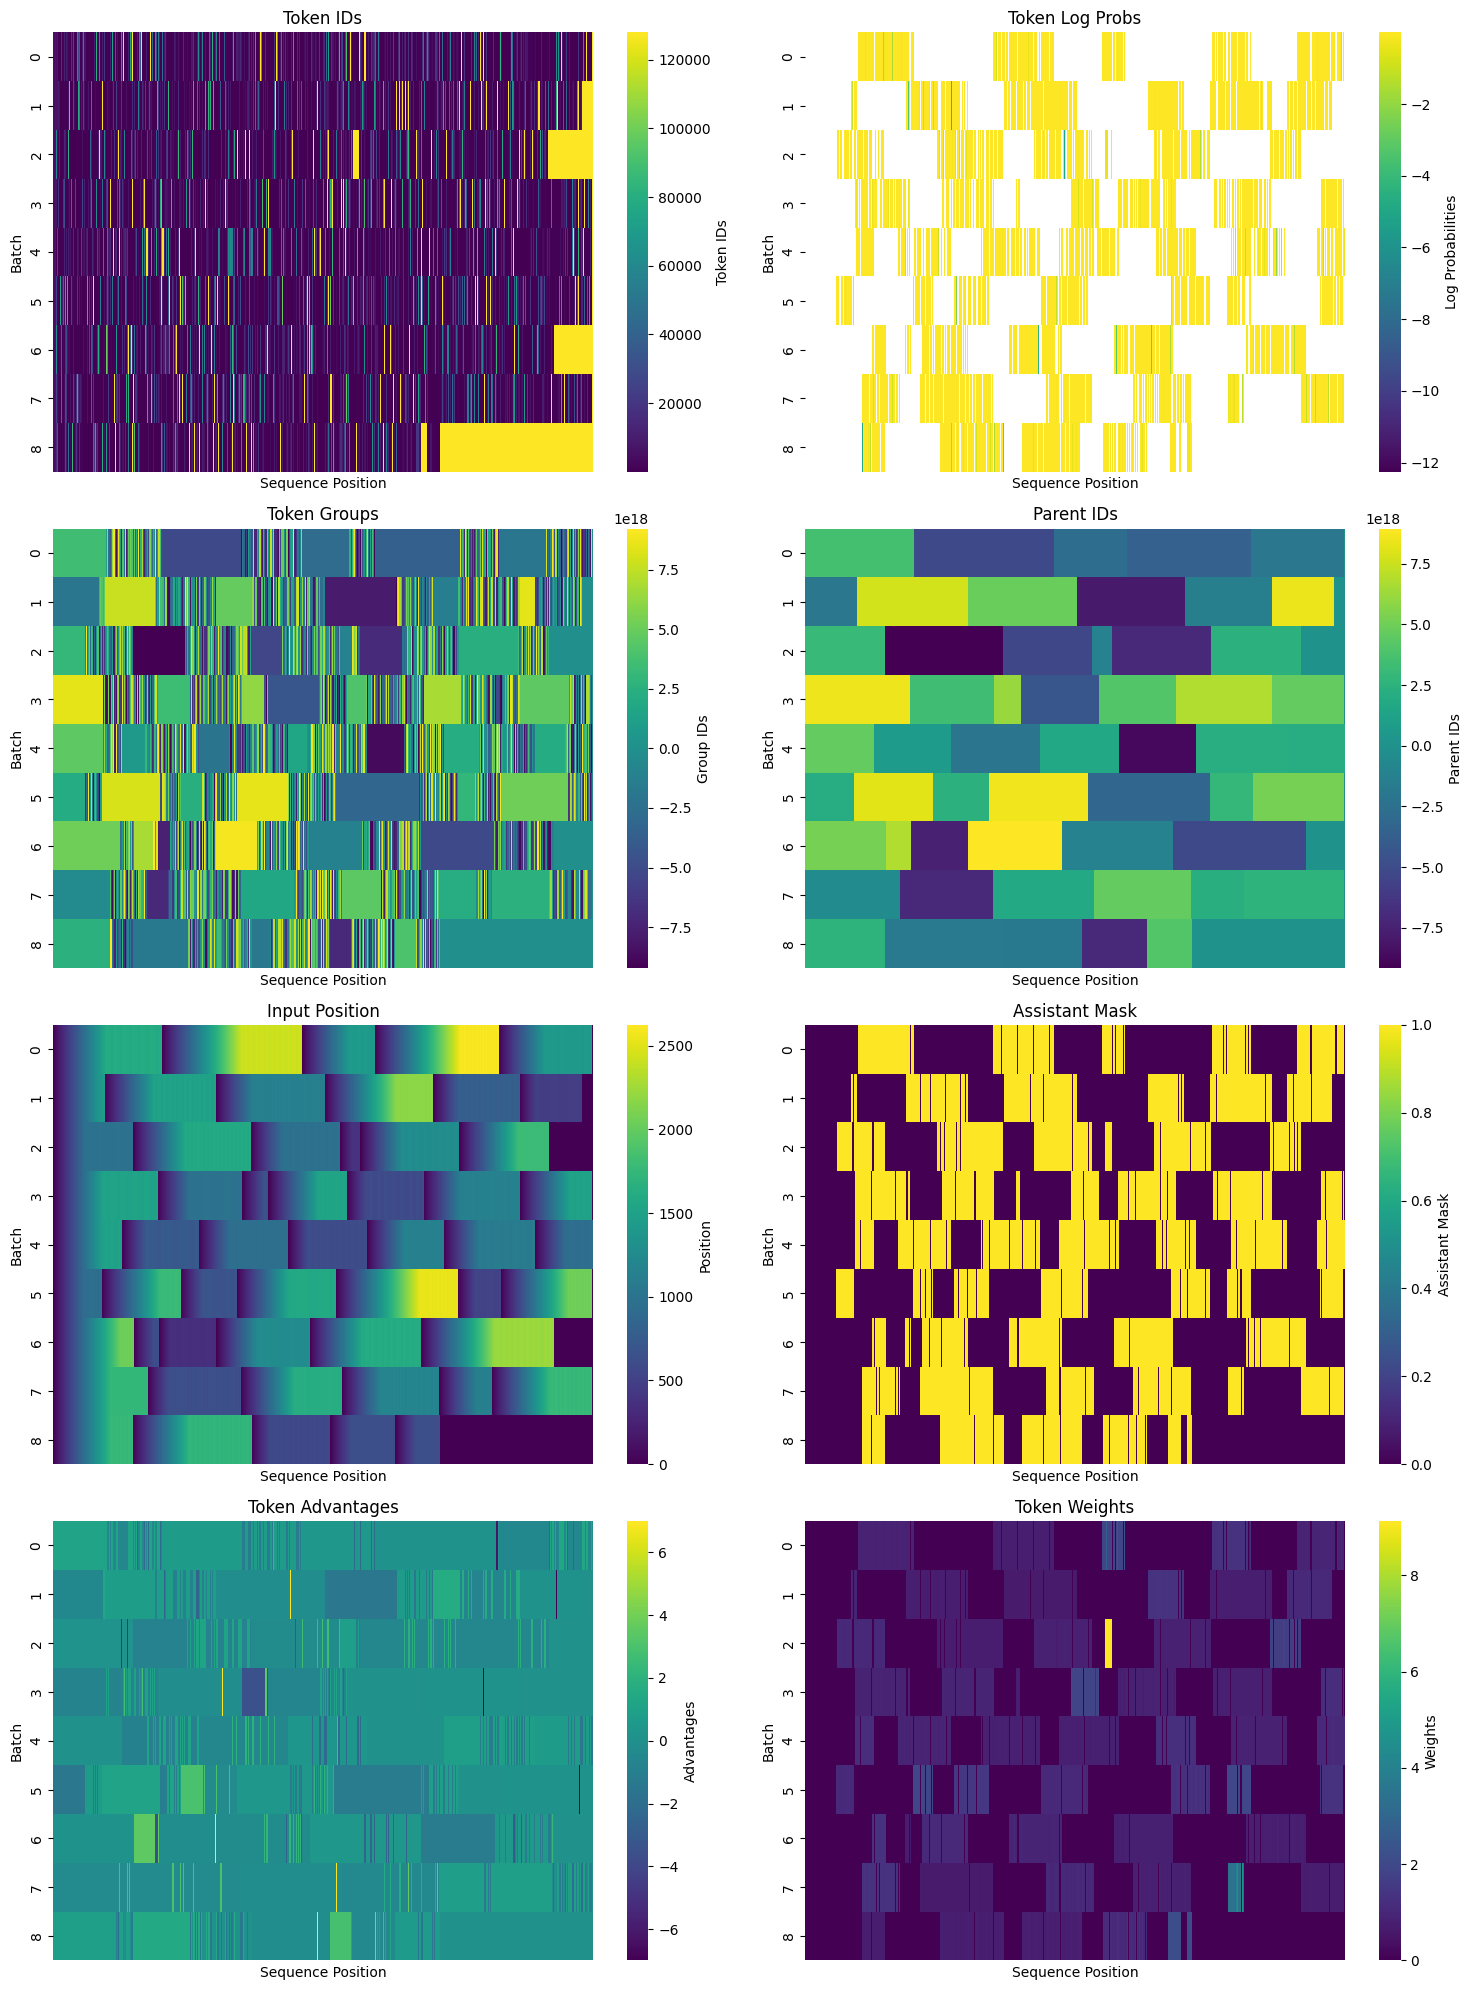

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0016
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740116758.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 29.74 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: 0.0022: 100%|██████████| 4/4 [01:51<00:00, 26.24s/it, entropy=0.185, kl_div=nan, loss=0.00222, policy=0.00222]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.37 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #17 model files to ./models/026/0017
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0017 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0017 --port=8000 --api-key=default
INFO 02-21 05:49:03 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:49:04 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:49:04 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0017', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.27s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.97s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.97s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.93s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.82s/it]



INFO 02-21 05:49:29 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:49:30 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 05:49:30 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:49:30 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:49:30 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:49:30 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:50:17 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.61 seconds
INFO 02-21 05:50:18 api_server.py:756] Using supplied chat template:
INFO 02-21 05:50:18 api_server.py:756] None
INFO 02-21 05:50:18 launcher.py:21] Available routes are:
INFO 02-21 05:50:18 launcher.py:29] Route: /

INFO:     Started server process [45117]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:50:20 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:38420 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:38<00:00, 31.54it/s, completion_tokens=34, prompt_tokens=1236, reward=0.369, token_logprobs=109945]
Deleted iteration directory ./models/026/0016
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

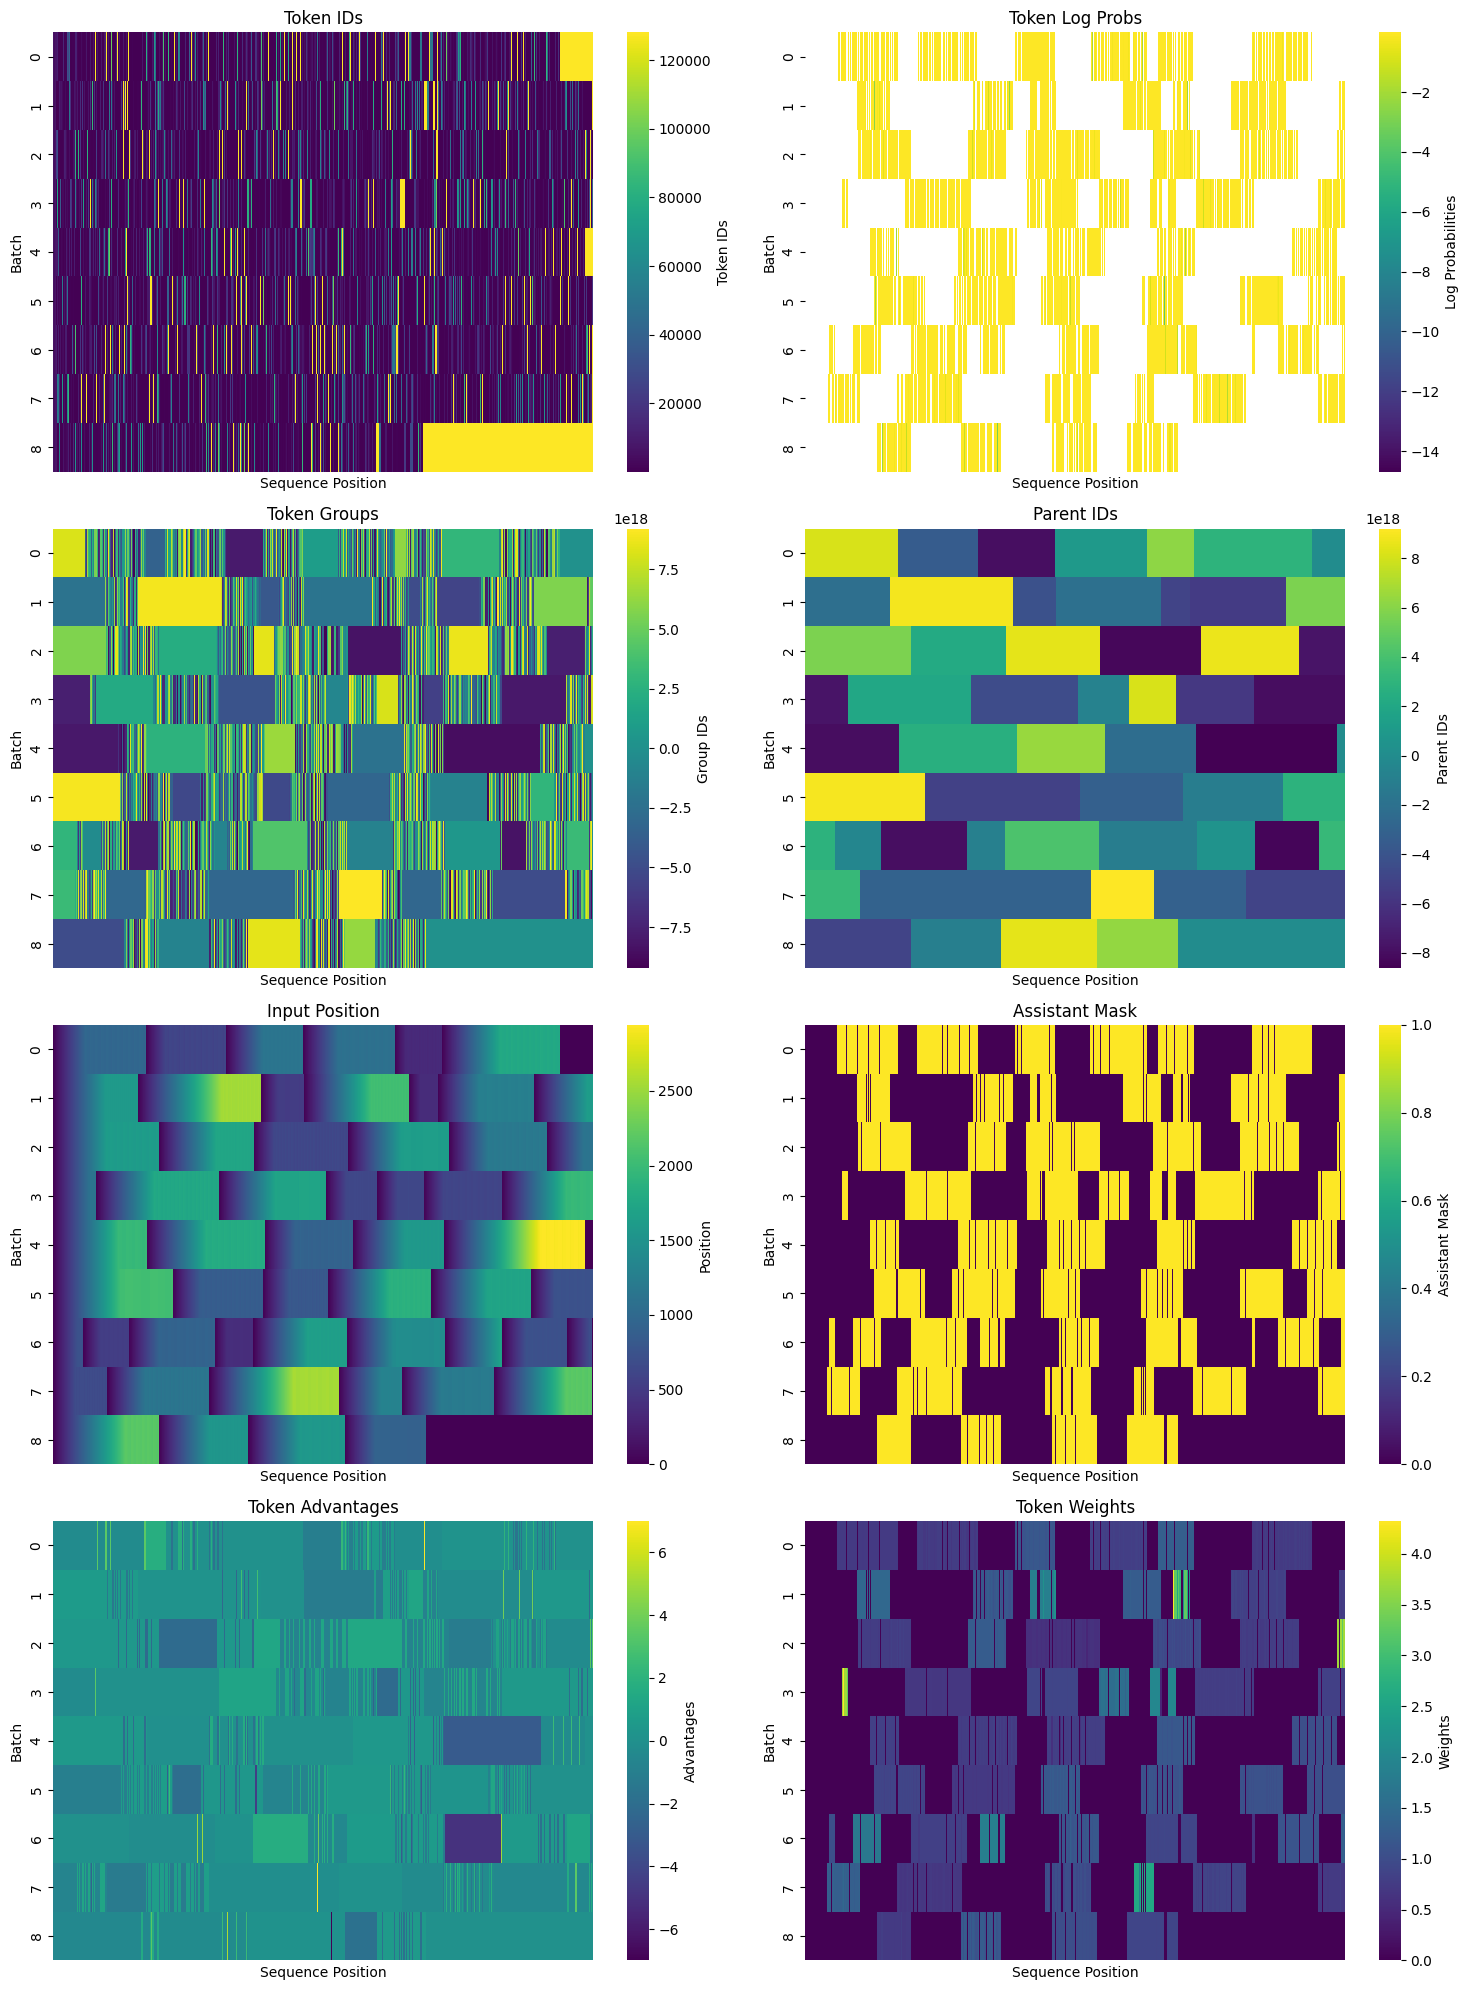

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0017
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740117209.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 29.84 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: 0.0037: 100%|██████████| 4/4 [01:52<00:00, 26.51s/it, entropy=0.0512, kl_div=nan, loss=0.00371, policy=0.00371]  INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.73 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #18 model files to ./models/026/0018
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0018 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0018 --port=8000 --api-key=default
INFO 02-21 05:56:33 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 05:56:34 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 05:56:34 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0018', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:01<00:03,  1.21s/it]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:06<00:07,  3.65s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:10<00:03,  3.92s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.49s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:13<00:00,  3.41s/it]



INFO 02-21 05:57:01 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 05:57:01 worker.py:267] Memory profiling takes 0.88 seconds
INFO 02-21 05:57:01 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 05:57:01 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 05:57:02 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 05:57:02 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 05:57:48 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.35 seconds
INFO 02-21 05:57:49 api_server.py:756] Using supplied chat template:
INFO 02-21 05:57:49 api_server.py:756] None
INFO 02-21 05:57:49 launcher.py:21] Available routes are:
INFO 02-21 05:57:49 launcher.py:29] Route: /

INFO:     Started server process [47046]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 05:57:49 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:44224 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:31<00:00, 56.52it/s, completion_tokens=34, prompt_tokens=1311, reward=0.384, token_logprobs=110140]
Deleted iteration directory ./models/026/0017
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

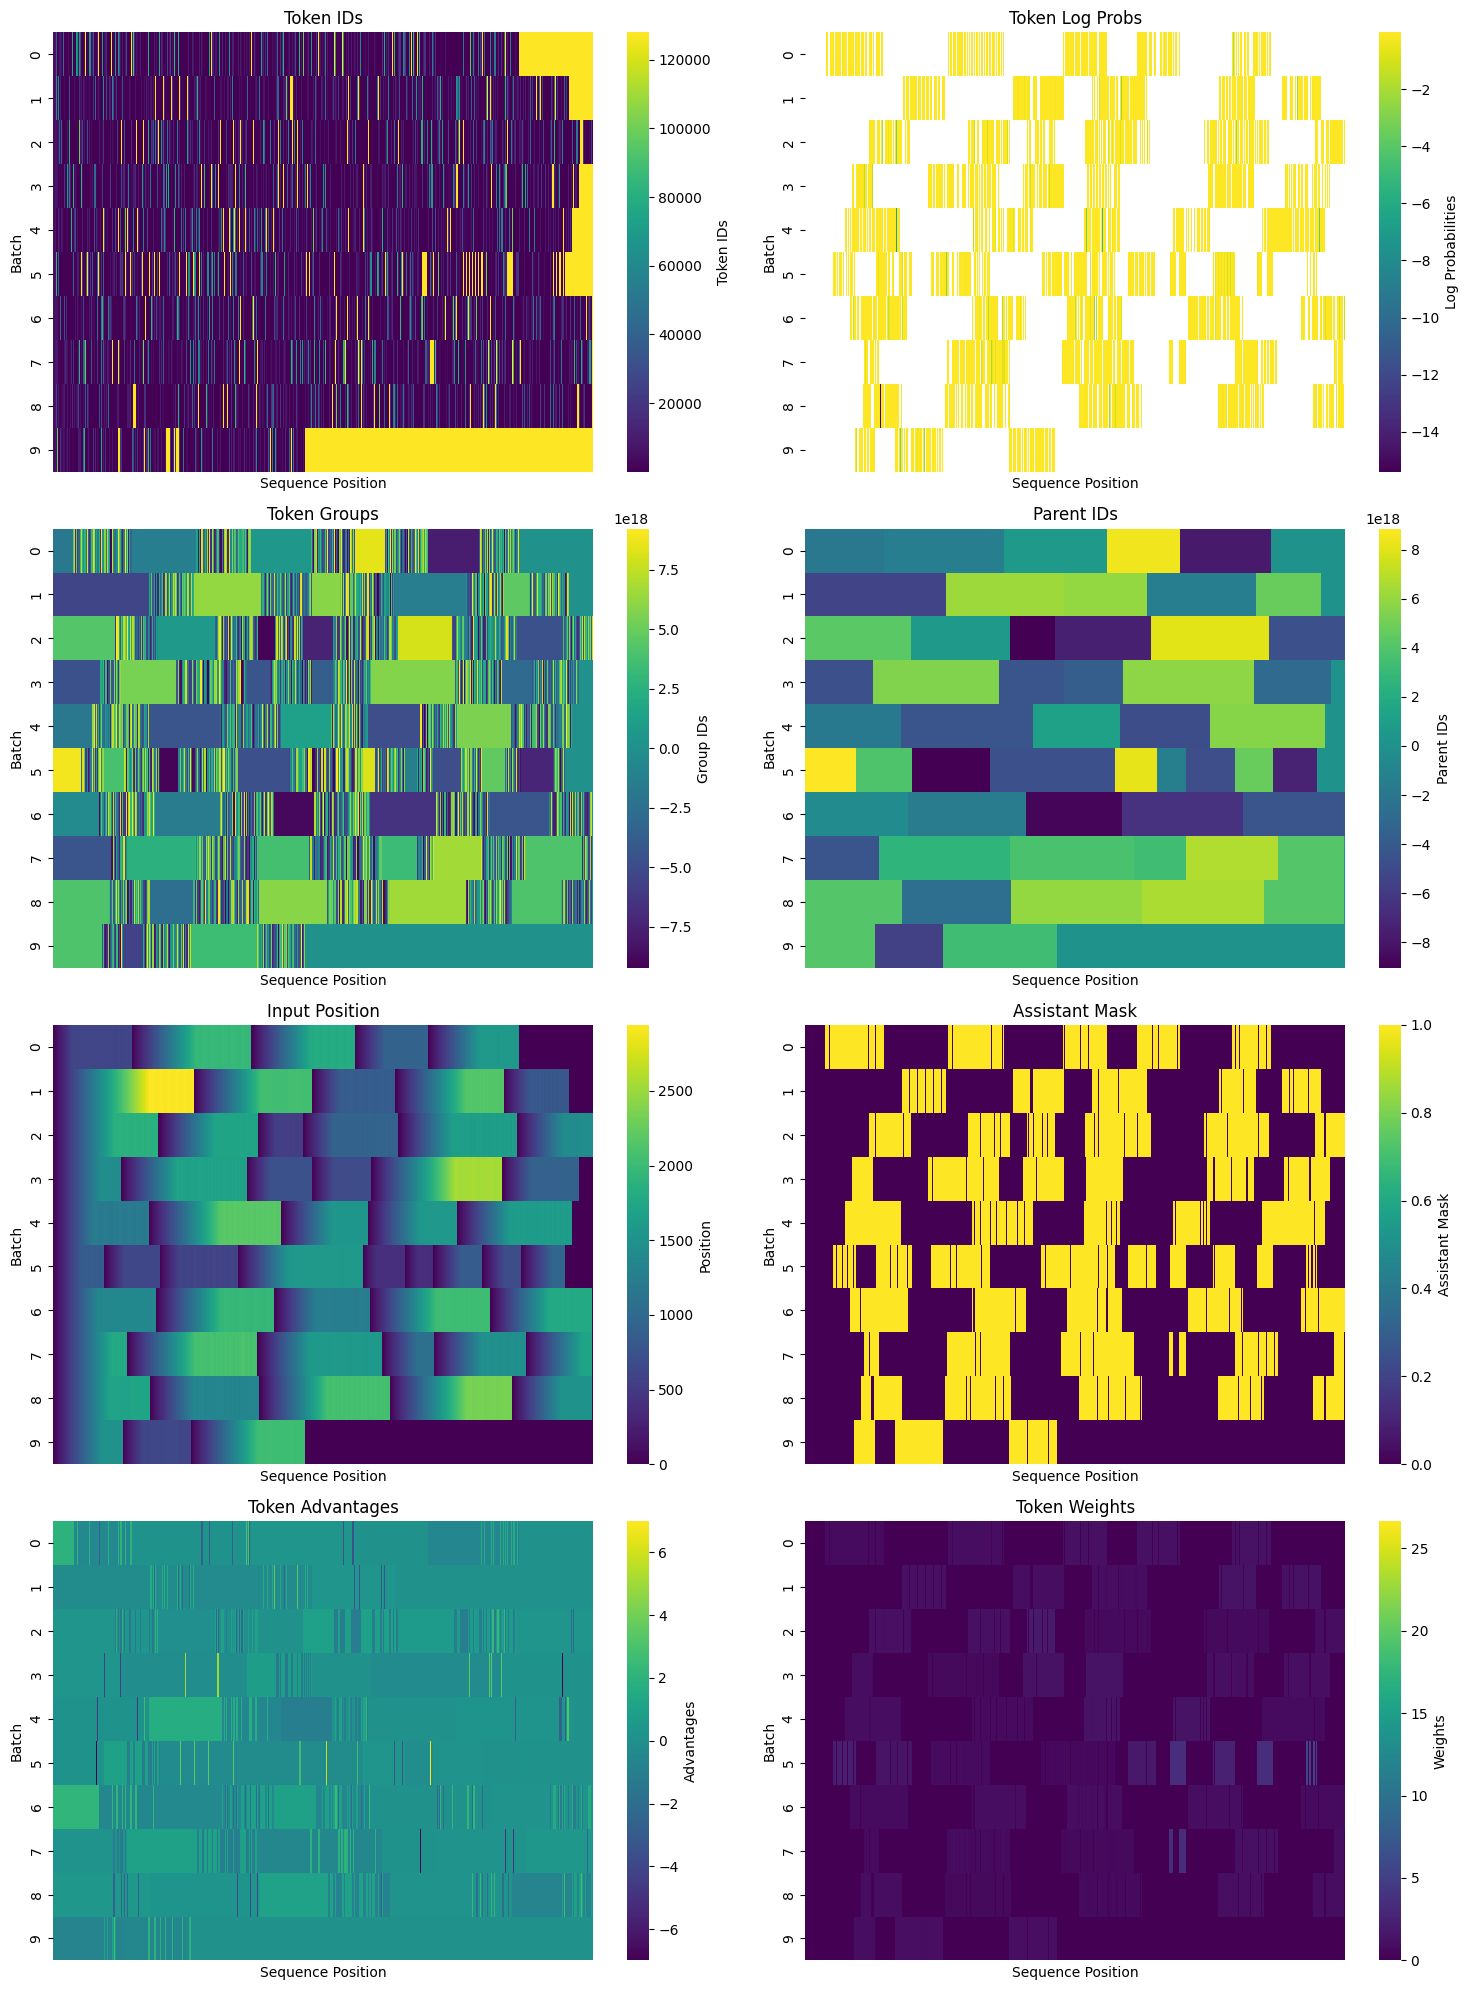

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0018
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 10
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_

Writing logs to models/026/logs/log_1740117657.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 21.70 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|5|Loss: 0.0040: 100%|██████████| 5/5 [02:15<00:00, 25.67s/it, entropy=0.202, kl_div=nan, loss=0.00404, policy=0.00404]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 10.25 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #19 model files to ./models/026/0019
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0019 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0019 --port=8000 --api-key=default
INFO 02-21 06:04:19 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:04:20 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:04:20 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0019', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.03it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.82s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.90s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.89s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.74s/it]



INFO 02-21 06:04:43 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:04:44 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 06:04:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:04:44 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:04:44 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:04:44 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:05:31 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.66 seconds
INFO 02-21 06:05:31 api_server.py:756] Using supplied chat template:
INFO 02-21 06:05:31 api_server.py:756] None
INFO 02-21 06:05:31 launcher.py:21] Available routes are:
INFO 02-21 06:05:31 launcher.py:29] Route: /

INFO:     Started server process [48987]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:05:35 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:56420 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:19<00:00, 83.29it/s, completion_tokens=33, prompt_tokens=1213, reward=0.437, token_logprobs=106031]
Deleted iteration directory ./models/026/0018
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

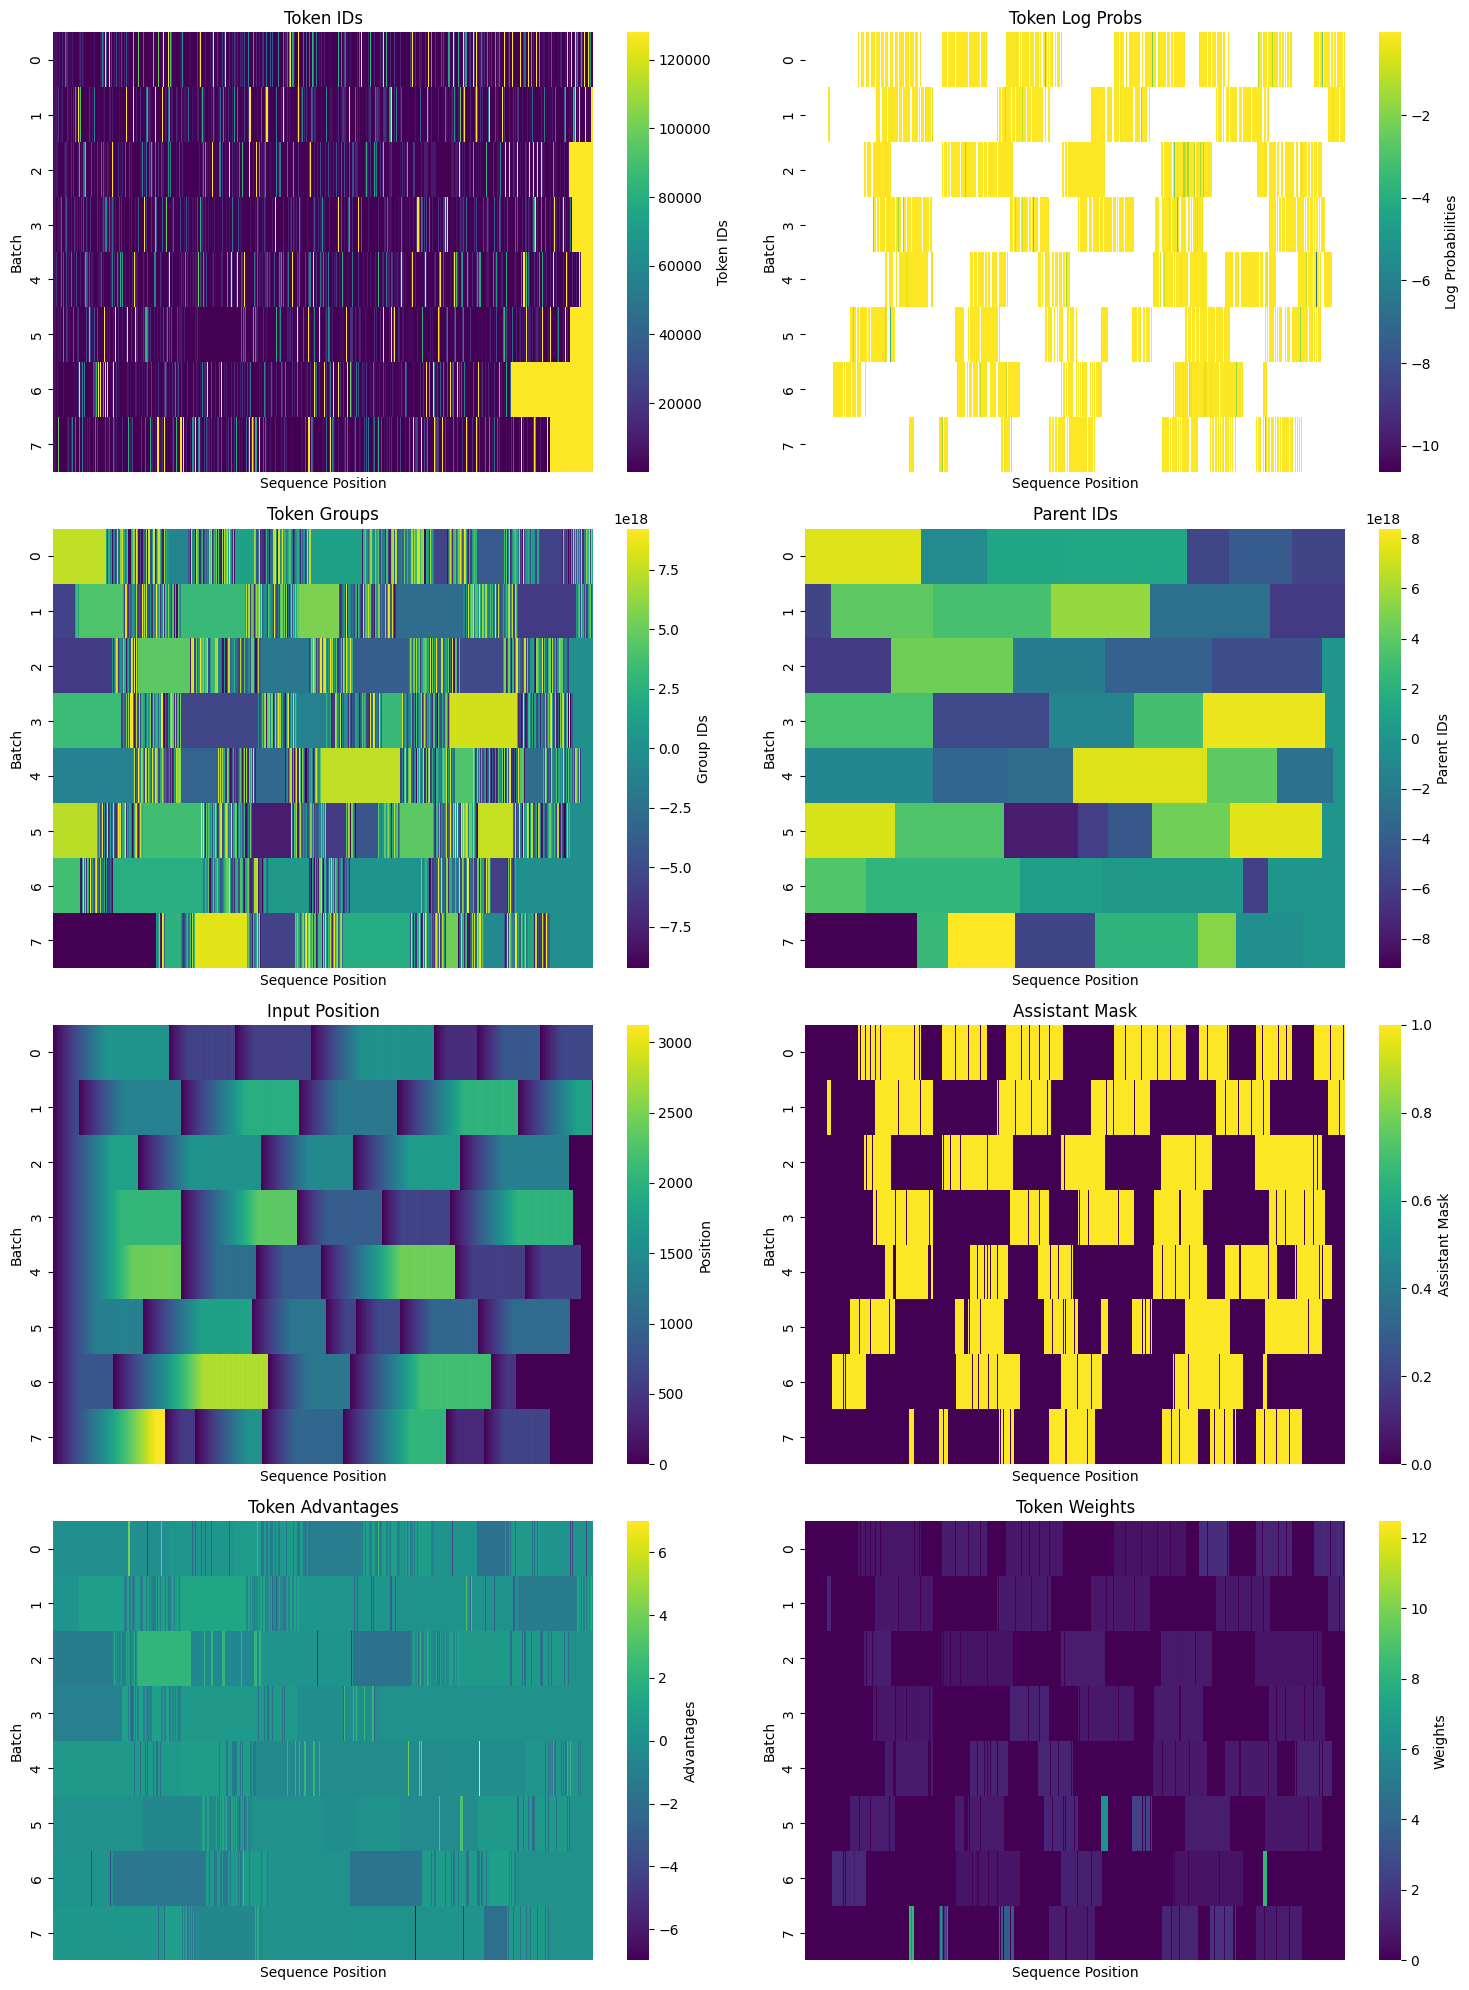

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0019
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 8
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740118104.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 25.48 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: -0.0007: 100%|██████████| 4/4 [01:48<00:00, 25.96s/it, entropy=0.196, kl_div=nan, loss=-0.000737, policy=-0.000737]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 8.92 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB save

Saved iteration #20 model files to ./models/026/0020
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0020 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0020 --port=8000 --api-key=default
INFO 02-21 06:11:20 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:11:21 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:11:21 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0020', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:04,  2.40s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.66s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.74s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.55s/it]



INFO 02-21 06:11:43 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:11:44 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 06:11:44 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:11:44 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:11:44 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:11:44 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:12:32 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.44 seconds
INFO 02-21 06:12:33 api_server.py:756] Using supplied chat template:
INFO 02-21 06:12:33 api_server.py:756] None
INFO 02-21 06:12:33 launcher.py:21] Available routes are:
INFO 02-21 06:12:33 launcher.py:29] Route: /

INFO:     Started server process [50915]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:12:36 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO:     127.0.0.1:46254 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:14<00:00, 42.91it/s, completion_tokens=35, prompt_tokens=1198, reward=0.445, token_logprobs=111549]
Deleted iteration directory ./models/026/0019
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

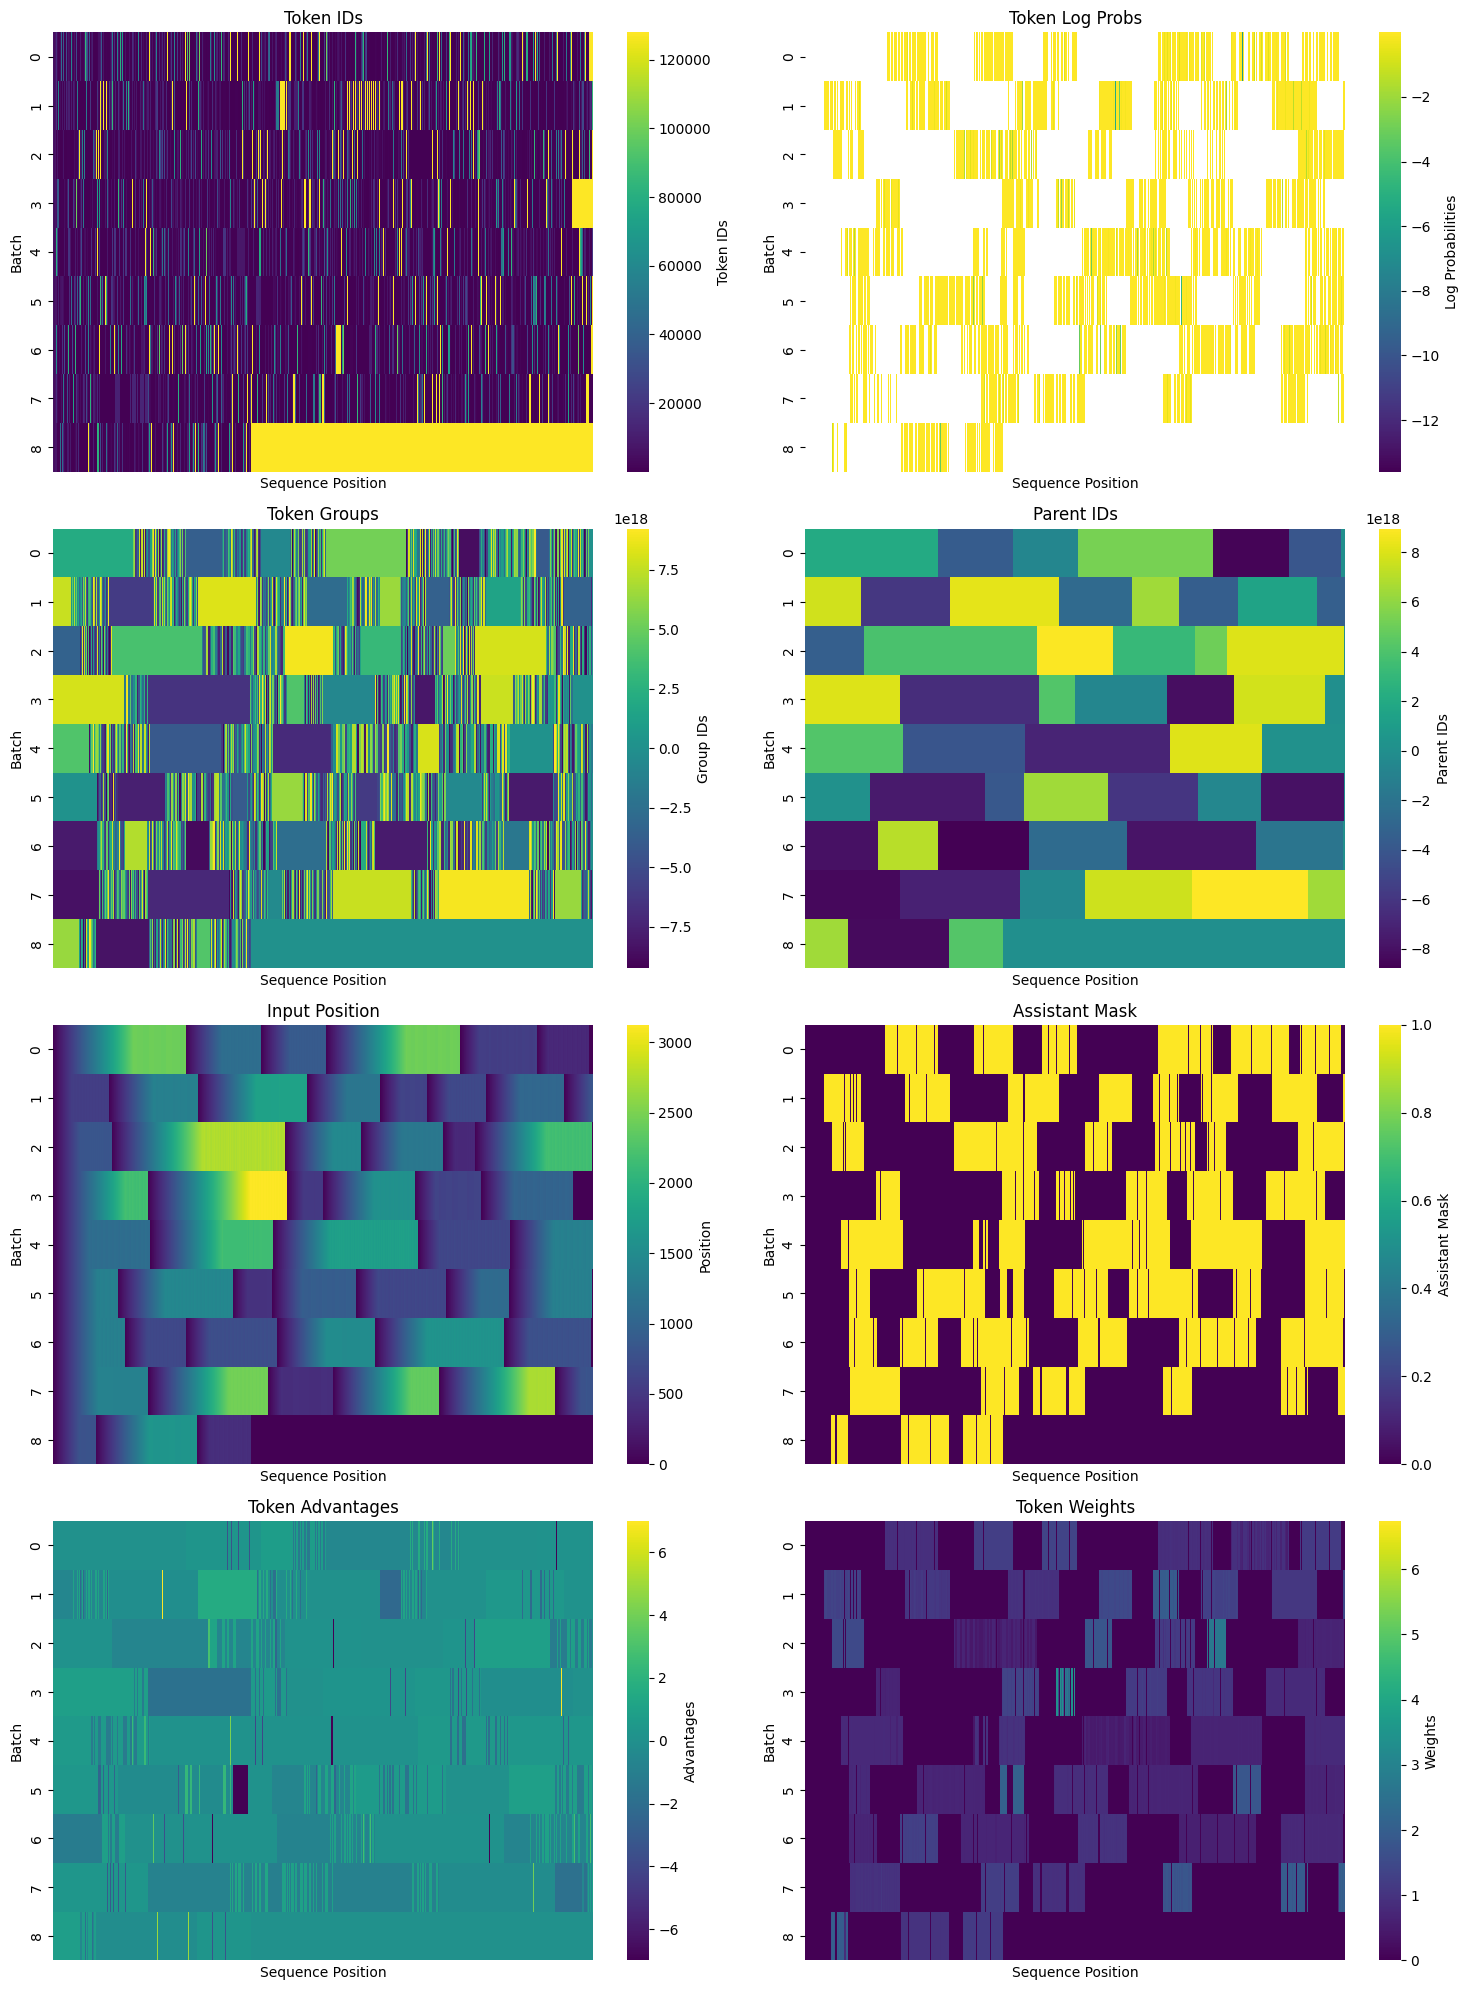

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0020
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740118517.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 21.86 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: 0.0051: 100%|██████████| 4/4 [01:48<00:00, 25.98s/it, entropy=0.138, kl_div=nan, loss=0.00511, policy=0.00511]   INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 11.12 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved

Saved iteration #21 model files to ./models/026/0021
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0021 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0021 --port=8000 --api-key=default
INFO 02-21 06:18:10 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:18:12 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:18:12 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0021', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:05,  2.56s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:03,  3.25s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  3.13s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:11<00:00,  2.92s/it]



INFO 02-21 06:18:34 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:18:35 worker.py:267] Memory profiling takes 0.86 seconds
INFO 02-21 06:18:35 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:18:35 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:18:35 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:18:35 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:19:23 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.21 seconds
INFO 02-21 06:19:24 api_server.py:756] Using supplied chat template:
INFO 02-21 06:19:24 api_server.py:756] None
INFO 02-21 06:19:24 launcher.py:21] Available routes are:
INFO 02-21 06:19:24 launcher.py:29] Route: /

INFO:     Started server process [52854]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:19:29 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:19:29 metrics.py:455] Avg prompt throughput: 1.7 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:19:29 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:41078 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:12<00:00, 25.12it/s, completion_tokens=37, prompt_tokens=1146, reward=0.401, token_logprobs=117511]
Deleted iteration directory ./models/026/0020
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

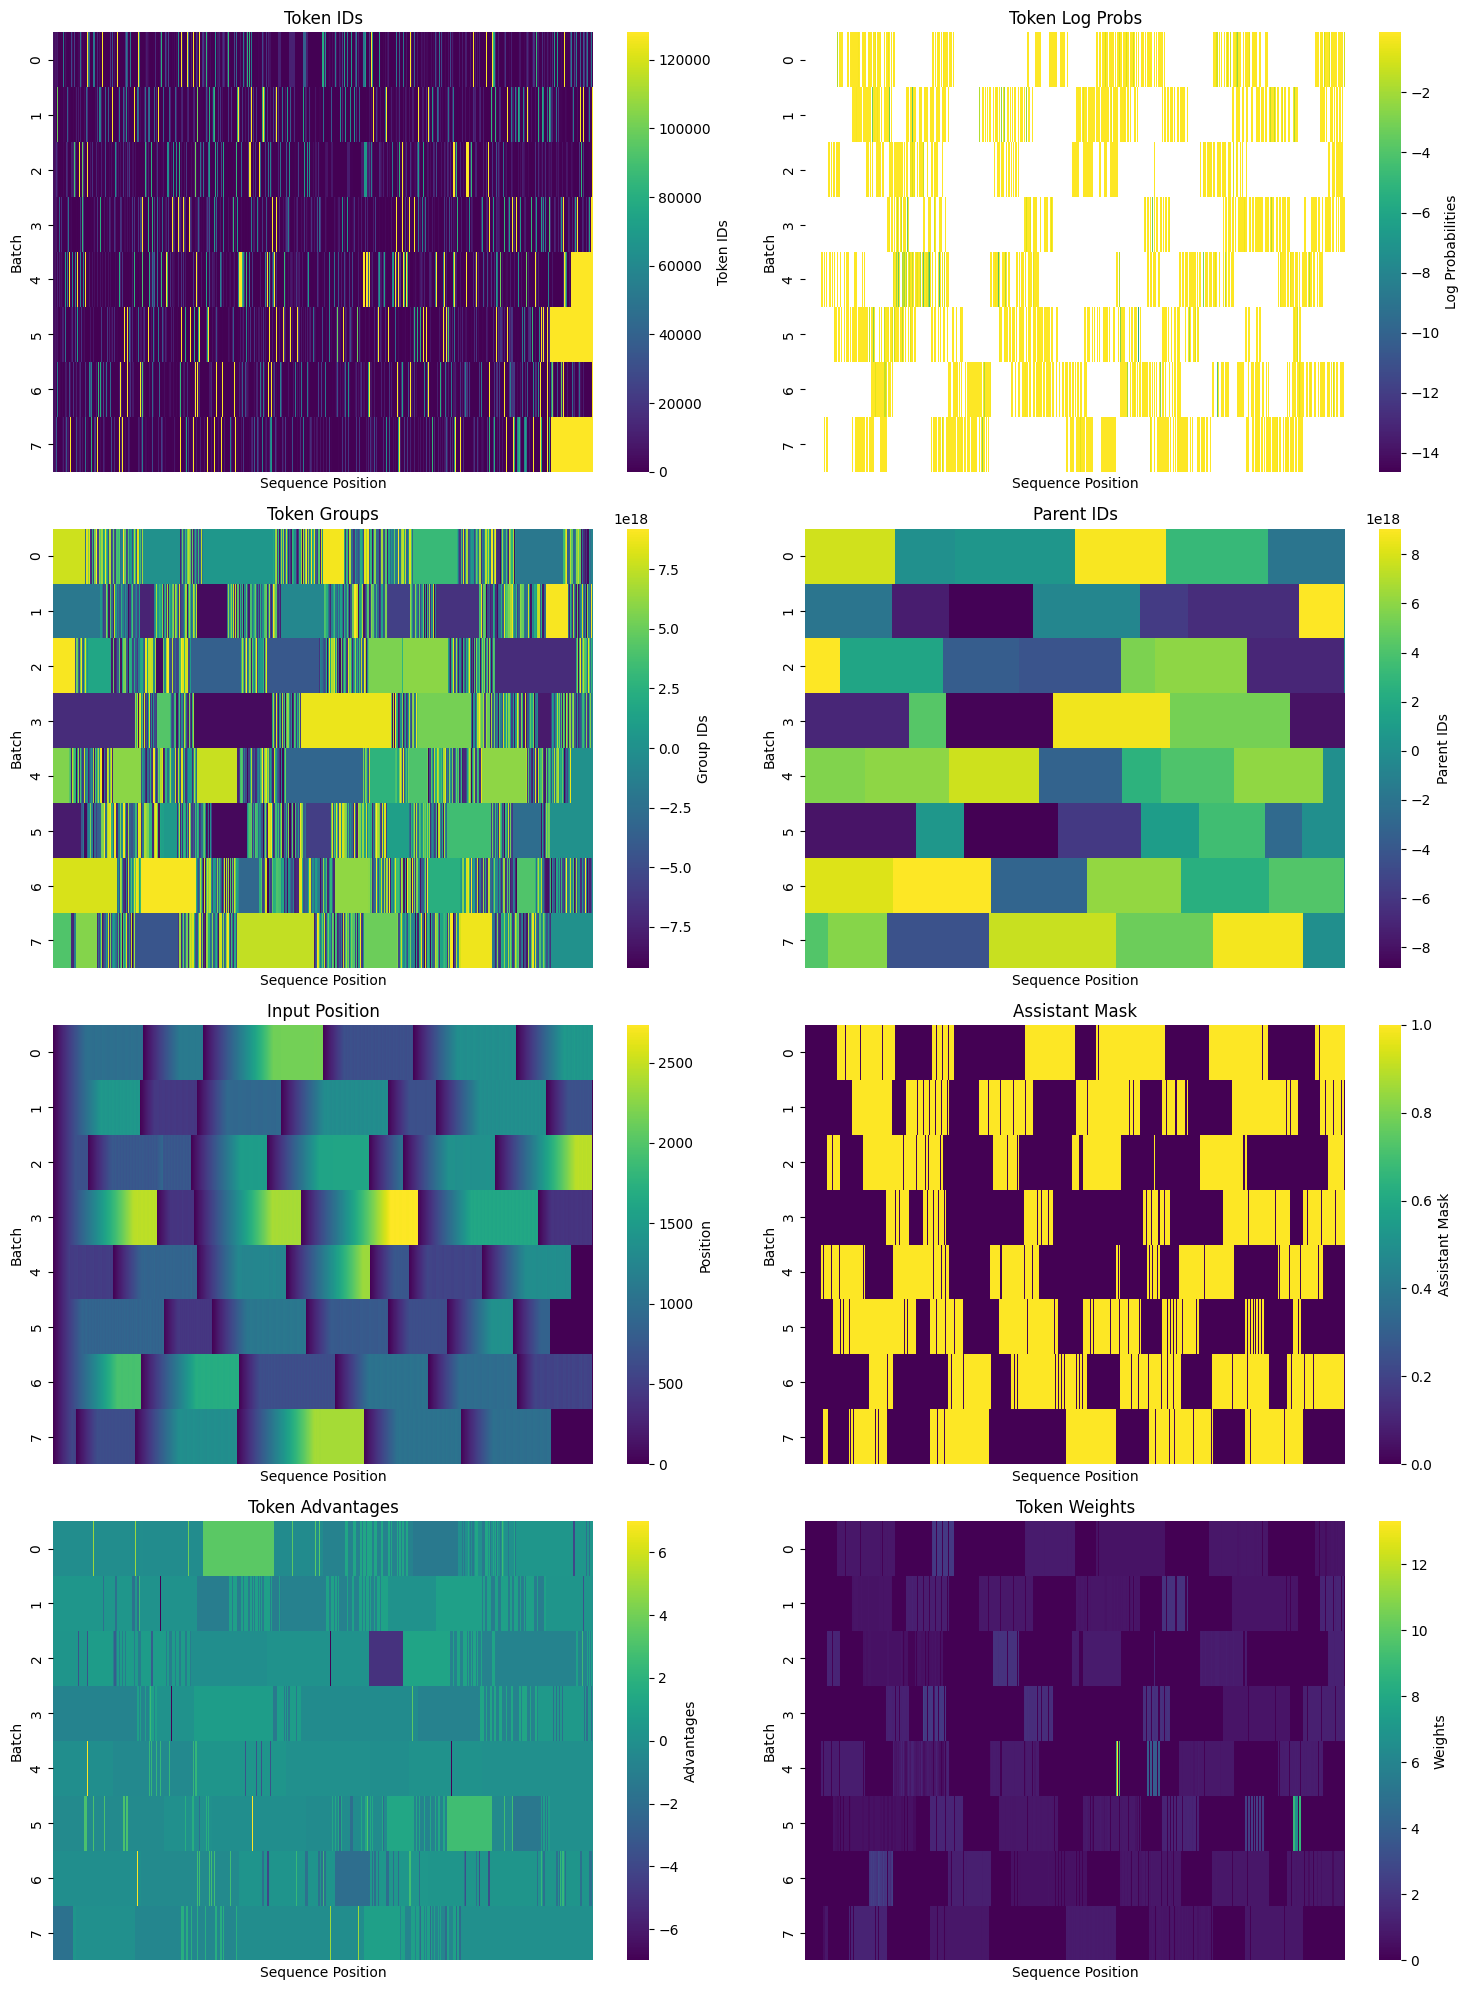

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0021
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 8
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740118932.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 20.23 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: -0.0005: 100%|██████████| 4/4 [01:49<00:00, 26.09s/it, entropy=0.233, kl_div=nan, loss=-0.000527, policy=-0.000527]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 12.29 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB sav

Saved iteration #22 model files to ./models/026/0022
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0022 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0022 --port=8000 --api-key=default
INFO 02-21 06:25:05 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:25:06 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:25:06 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0022', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.08it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:05,  2.53s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.71s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.76s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.59s/it]



INFO 02-21 06:25:29 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:25:30 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 06:25:30 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:25:30 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:25:30 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:25:30 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:26:13 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 43.96 seconds
INFO 02-21 06:26:14 api_server.py:756] Using supplied chat template:
INFO 02-21 06:26:14 api_server.py:756] None
INFO 02-21 06:26:14 launcher.py:21] Available routes are:
INFO 02-21 06:26:14 launcher.py:29] Route: /

INFO:     Started server process [54891]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:26:19 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:26:19 metrics.py:455] Avg prompt throughput: 1.8 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:26:19 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:34928 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:04<00:00, 68.72it/s, completion_tokens=35, prompt_tokens=1086, reward=0.412, token_logprobs=112114]
Deleted iteration directory ./models/026/0021
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

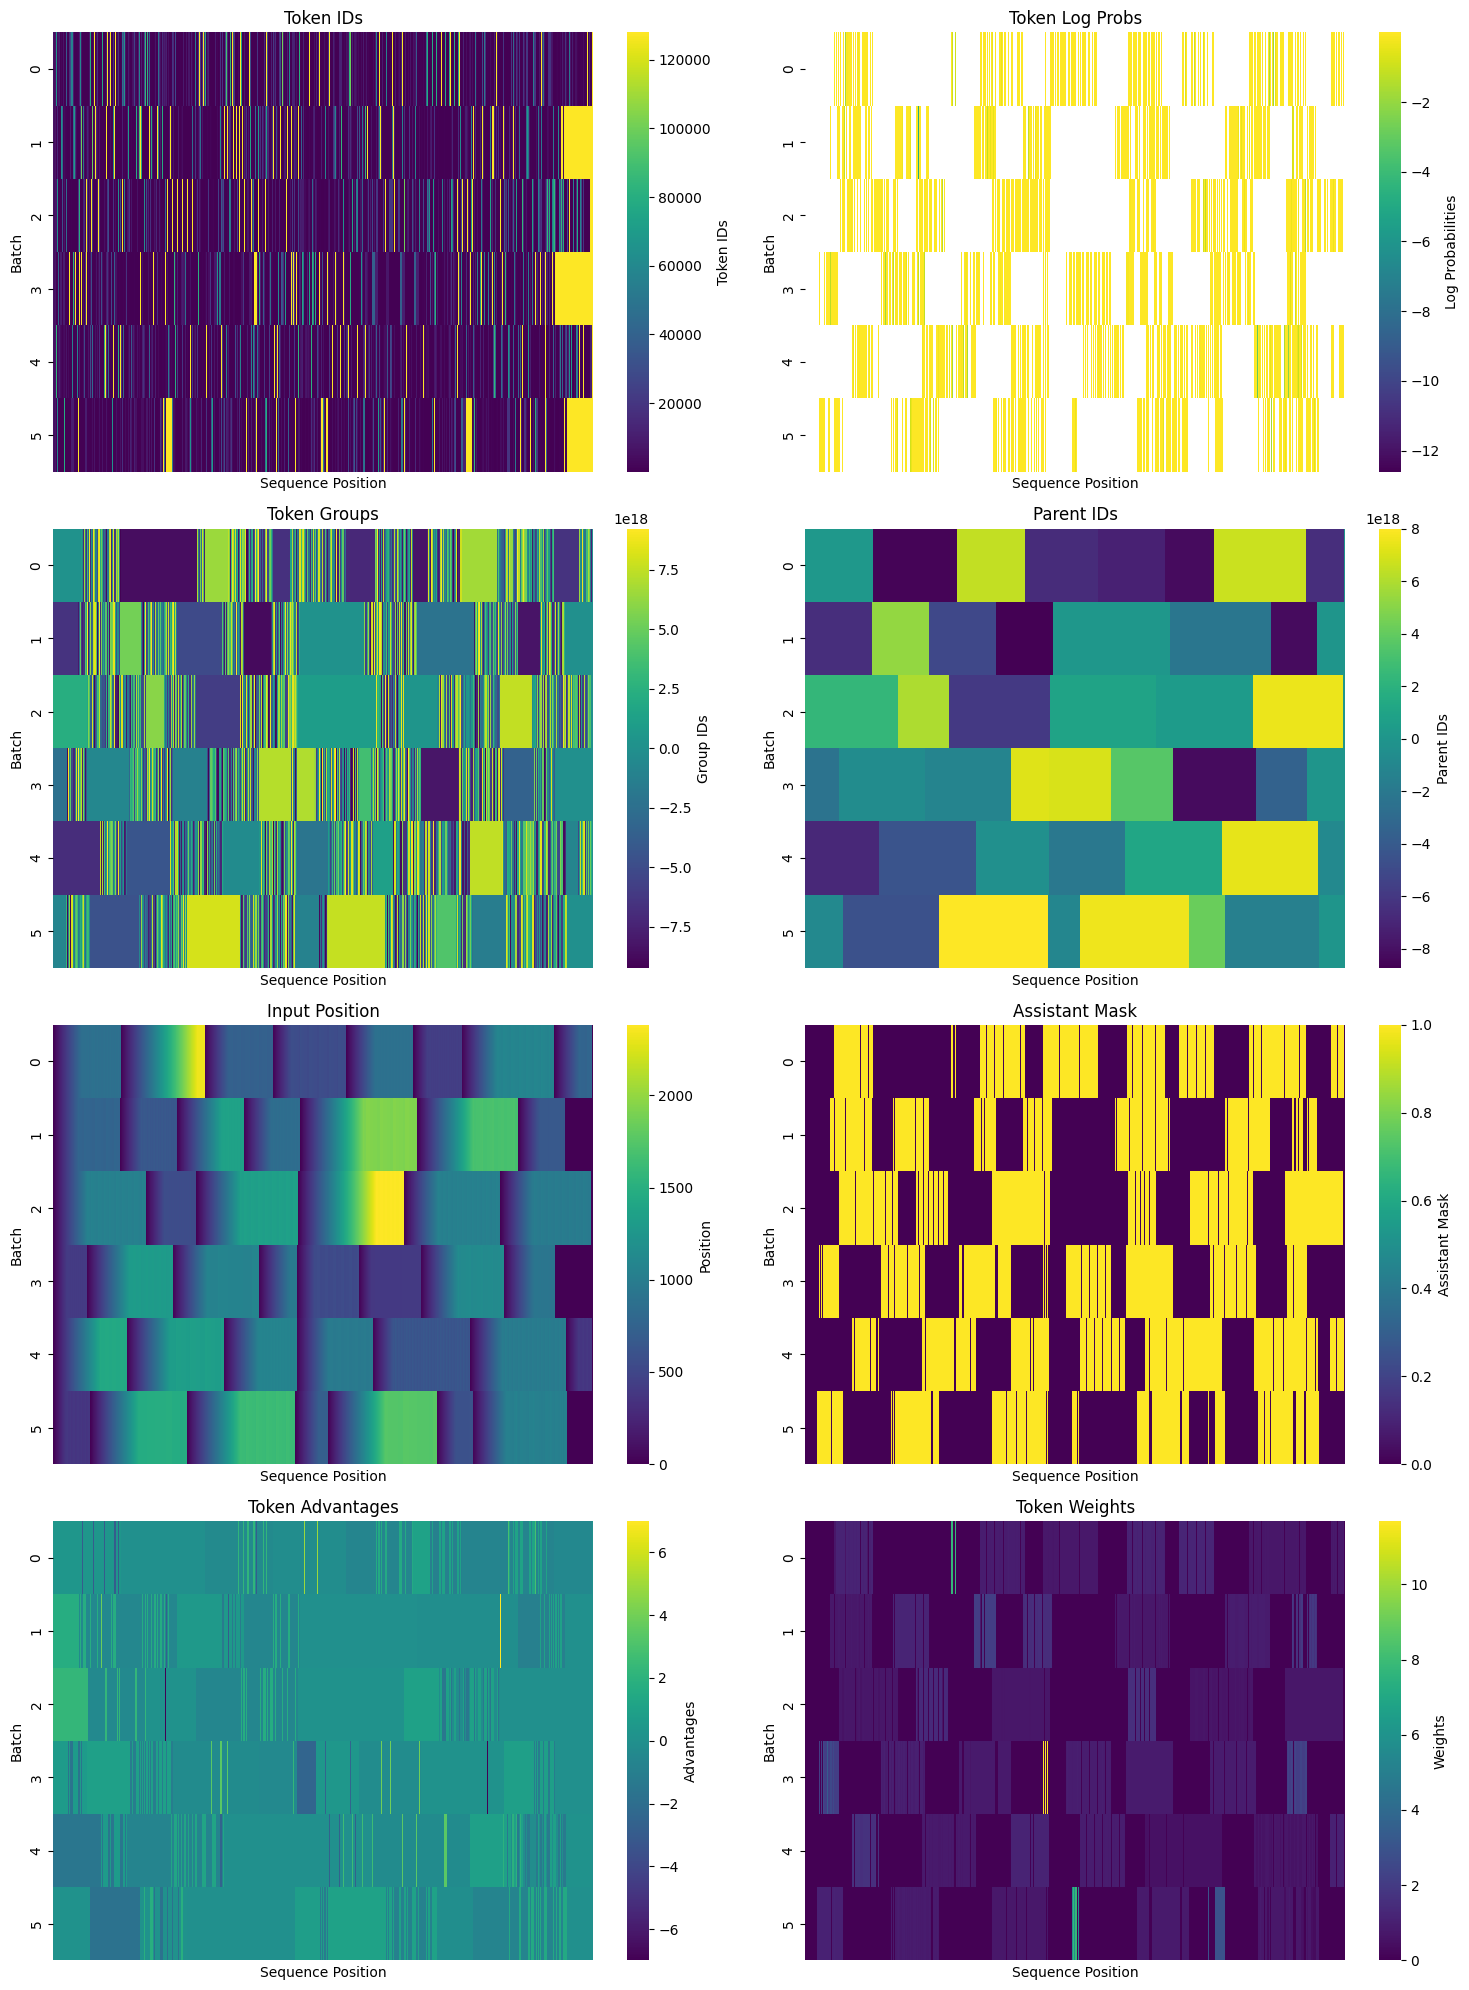

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0022
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 6
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740119393.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.09 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|3|Loss: 0.0008: 100%|██████████| 3/3 [01:25<00:00, 27.09s/it, entropy=0.265, kl_div=nan, loss=0.000761, policy=0.000761]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.74 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved t

Saved iteration #23 model files to ./models/026/0023
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0023 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0023 --port=8000 --api-key=default
INFO 02-21 06:32:24 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:32:25 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:32:25 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0023', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.07it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:04<00:04,  2.40s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:07<00:02,  2.65s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.73s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.54s/it]



INFO 02-21 06:32:46 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:32:47 worker.py:267] Memory profiling takes 0.90 seconds
INFO 02-21 06:32:47 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:32:47 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:32:47 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:32:47 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:33:34 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 48.20 seconds
INFO 02-21 06:33:35 api_server.py:756] Using supplied chat template:
INFO 02-21 06:33:35 api_server.py:756] None
INFO 02-21 06:33:35 launcher.py:21] Available routes are:
INFO 02-21 06:33:35 launcher.py:29] Route: /

INFO:     Started server process [56820]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:33:42 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:33:42 metrics.py:455] Avg prompt throughput: 1.4 tokens/s, Avg generation throughput: 0.1 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:33:42 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:58646 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:01<00:00, 73.36it/s, completion_tokens=34, prompt_tokens=1205, reward=0.422, token_logprobs=109252]
Deleted iteration directory ./models/026/0022
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

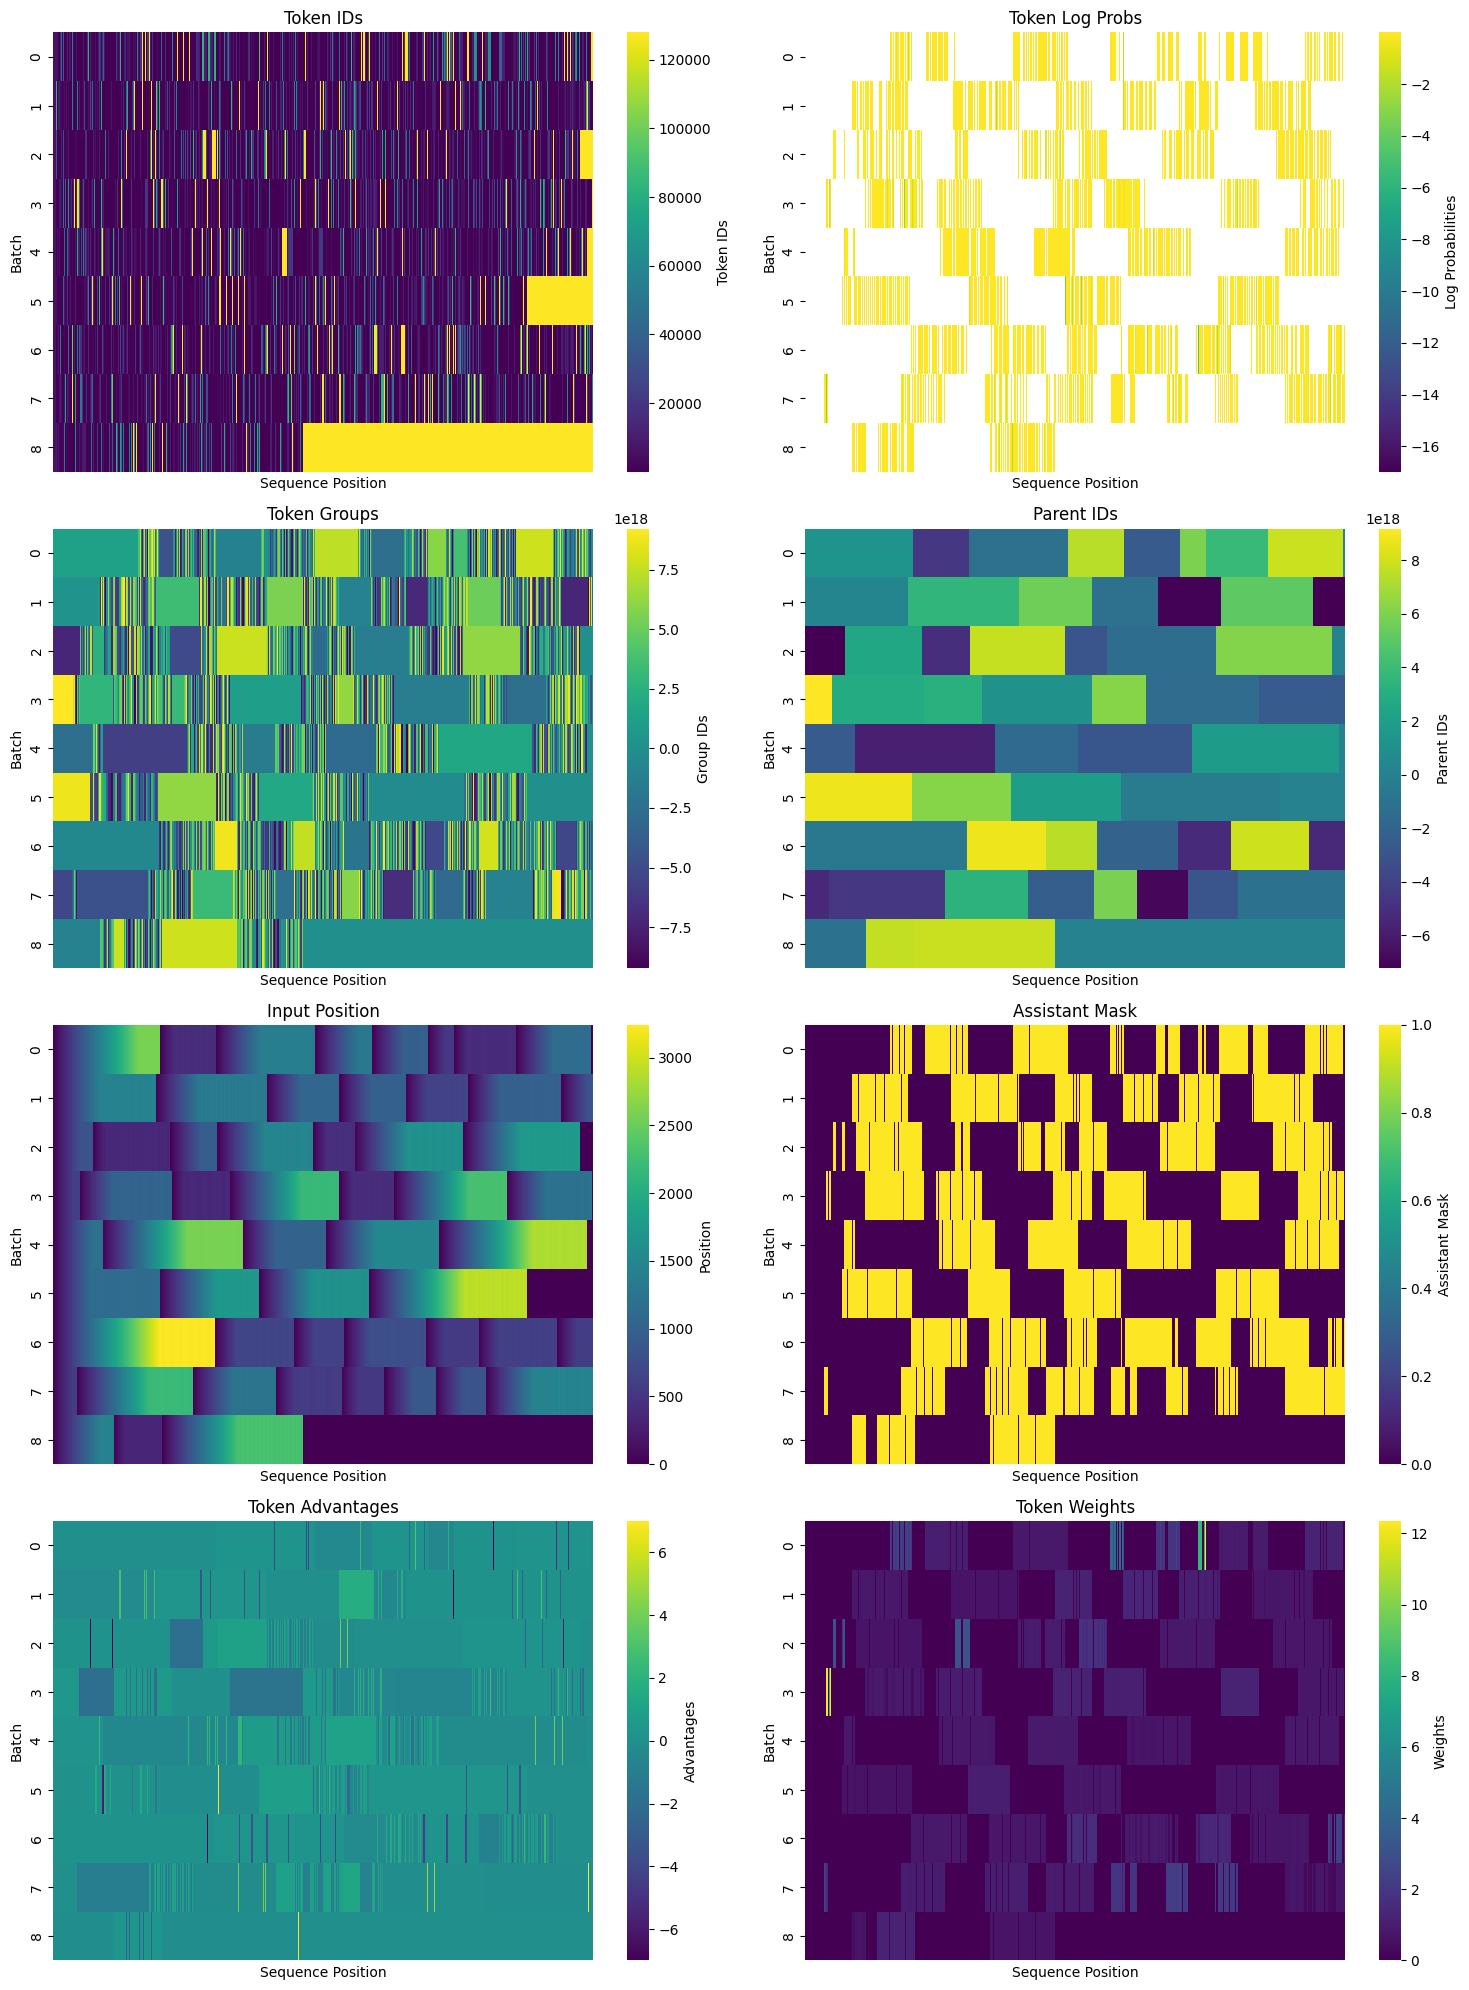

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0023
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740119833.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 24.05 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: 0.0112: 100%|██████████| 4/4 [01:49<00:00, 25.97s/it, entropy=0.425, kl_div=nan, loss=0.0112, policy=0.0112]    INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.69 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved t

Saved iteration #24 model files to ./models/026/0024
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0024 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0024 --port=8000 --api-key=default
INFO 02-21 06:40:15 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:40:17 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:40:17 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0024', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.45it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:03<00:04,  2.02s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:06<00:02,  2.44s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.60s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:09<00:00,  2.36s/it]



INFO 02-21 06:40:39 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:40:40 worker.py:267] Memory profiling takes 0.85 seconds
INFO 02-21 06:40:40 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:40:40 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:40:40 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:40:40 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:41:27 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 47.99 seconds
INFO 02-21 06:41:29 api_server.py:756] Using supplied chat template:
INFO 02-21 06:41:29 api_server.py:756] None
INFO 02-21 06:41:29 launcher.py:21] Available routes are:
INFO 02-21 06:41:29 launcher.py:29] Route: /

INFO:     Started server process [58759]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:41:35 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:41:35 metrics.py:455] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:41:35 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:34366 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [03:04<00:00, 16.71it/s, completion_tokens=33, prompt_tokens=1281, reward=0.418, token_logprobs=105247]
Deleted iteration directory ./models/026/0023
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

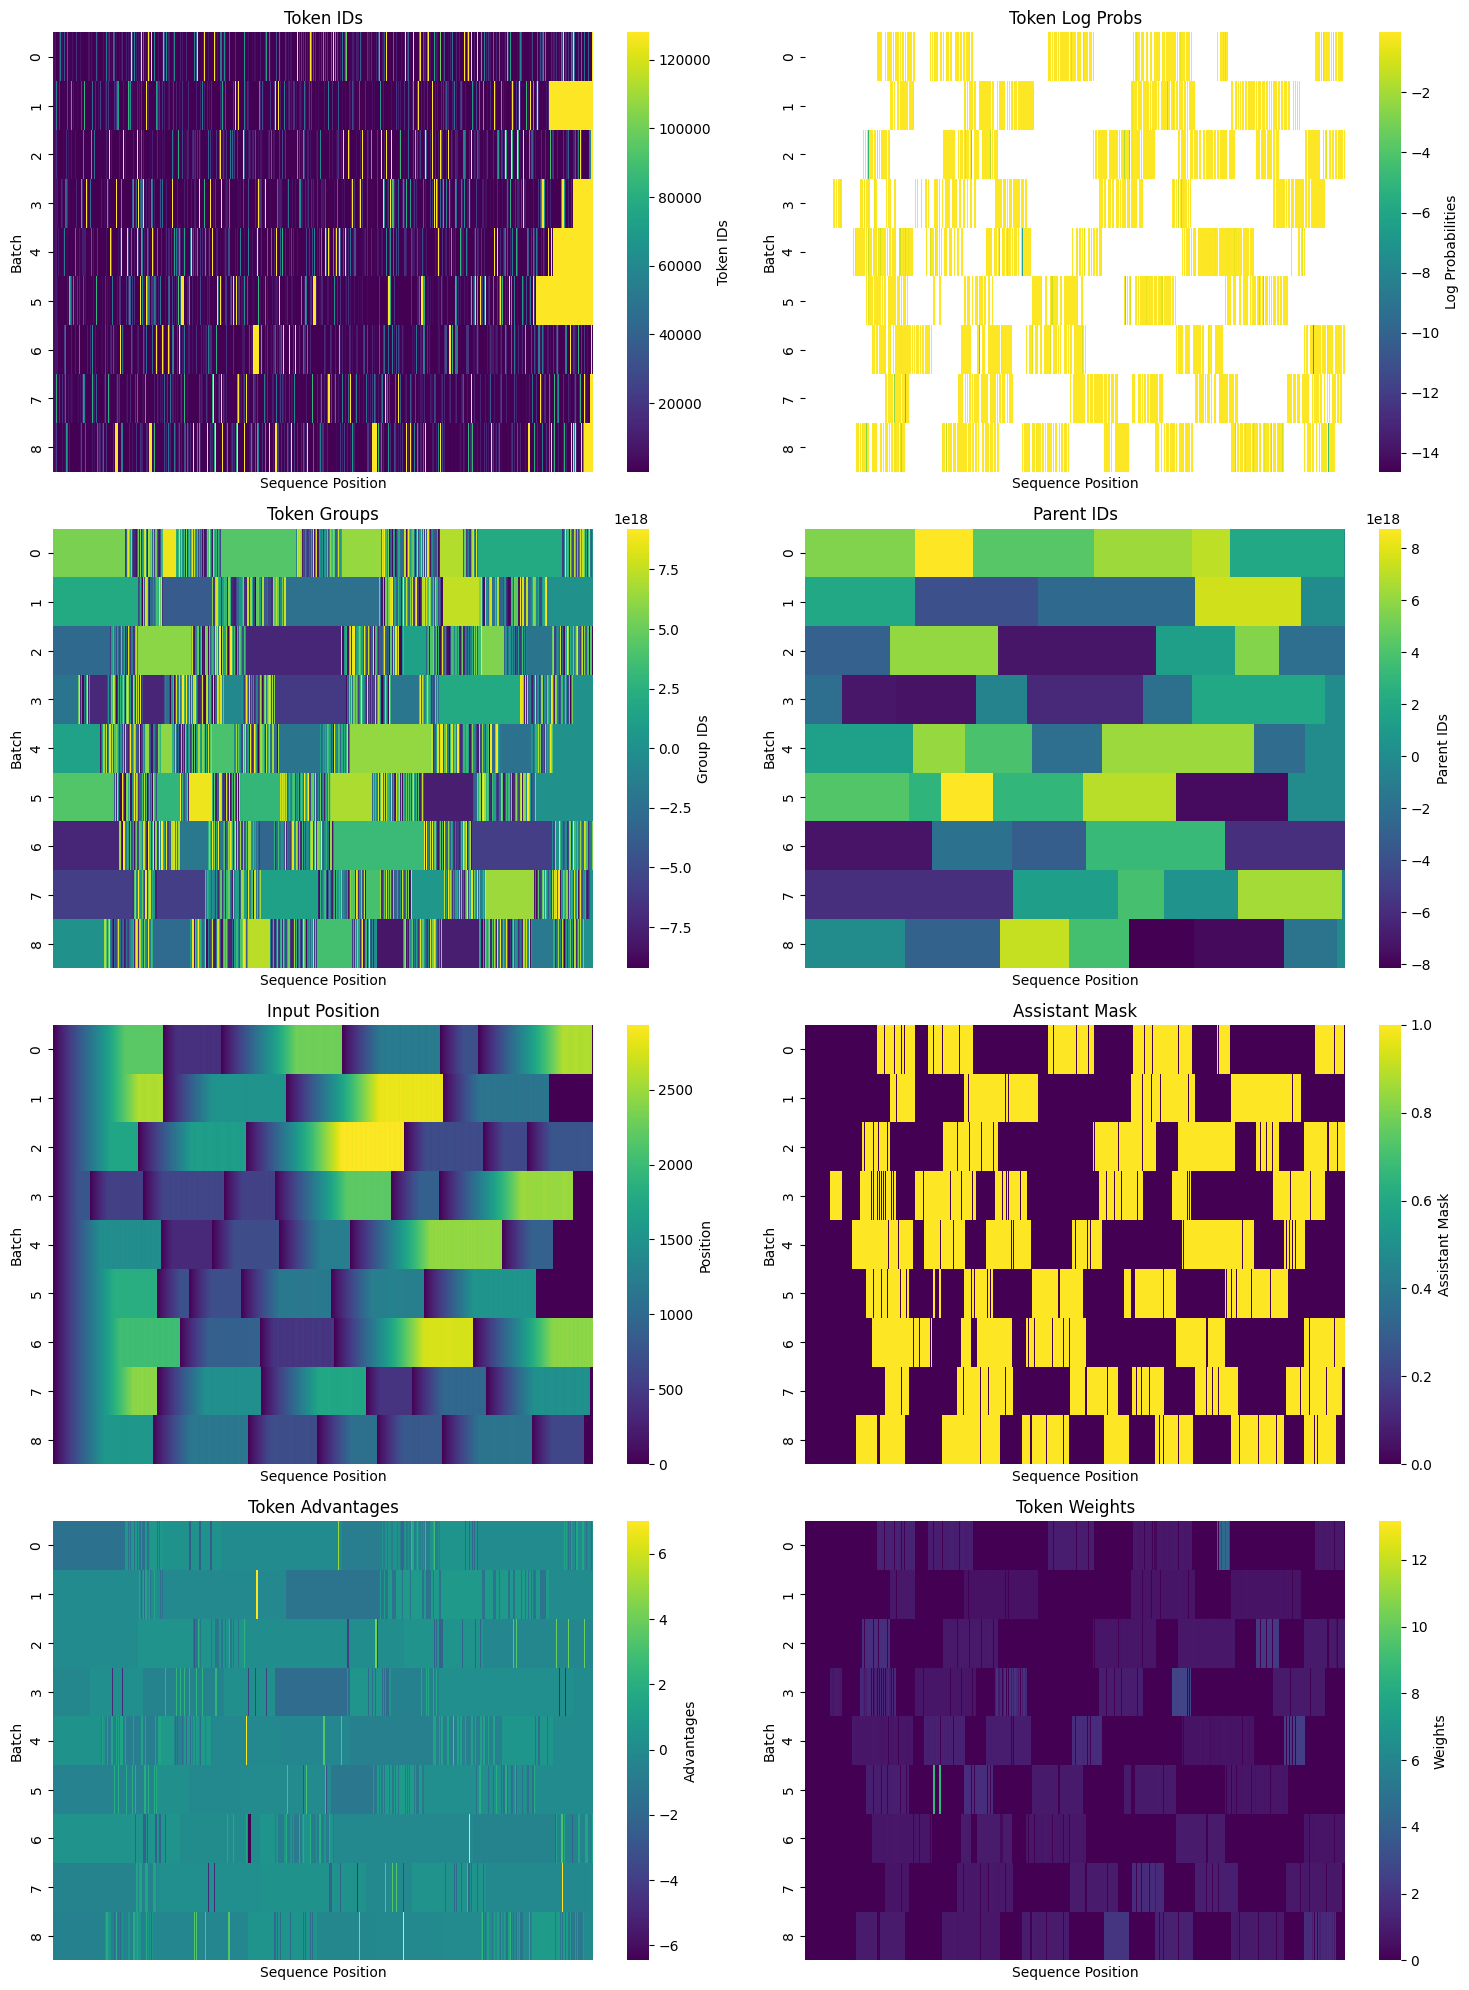

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0024
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 9
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740120306.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 23.15 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
1|4|Loss: -0.0072: 100%|██████████| 4/4 [01:50<00:00, 26.24s/it, entropy=0.194, kl_div=nan, loss=-0.00716, policy=-0.00716]INFO:torchtune.utils._logging:Saving checkpoint. This may take some time. Retrieving full model state dict...
INFO:torchtune.utils._logging:Getting full model state dict took 9.80 secs
INFO:torchtune.utils._logging:Model checkpoint of size 4.98 GB saved 

Saved iteration #25 model files to ./models/026/0025
$ vllm serve /home/ubuntu/sky_workdir/experiments/models/026/0025 --block-size=32 --disable-log-requests --enable-prefix-caching --enforce-eager --gpu-memory-utilization=0.95 --max-model-len=16384 --max-num-seqs=1024 --max-num-batched-tokens=16384 --num-scheduler-steps=8 --preemption-mode=swap --return-tokens-as-token-ids --swap-space=80 --tensor-parallel-size=1 --served-model-name=./models/026/0025 --port=8000 --api-key=default
INFO 02-21 06:48:00 __init__.py:190] Automatically detected platform cuda.
INFO 02-21 06:48:01 api_server.py:840] vLLM API server version 0.7.2
INFO 02-21 06:48:01 api_server.py:841] args: Namespace(subparser='serve', model_tag='/home/ubuntu/sky_workdir/experiments/models/026/0025', config='', host=None, port=8000, uvicorn_log_level='info', allow_credentials=False, allowed_origins=['*'], allowed_methods=['*'], allowed_headers=['*'], api_key='default', lora_modules=None, prompt_adapters=None, chat_template=Non

Loading pt checkpoint shards:   0% Completed | 0/4 [00:00<?, ?it/s]
Loading pt checkpoint shards:  25% Completed | 1/4 [00:00<00:02,  1.03it/s]
Loading pt checkpoint shards:  50% Completed | 2/4 [00:05<00:05,  2.87s/it]
Loading pt checkpoint shards:  75% Completed | 3/4 [00:08<00:02,  2.91s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.88s/it]
Loading pt checkpoint shards: 100% Completed | 4/4 [00:10<00:00,  2.74s/it]



INFO 02-21 06:48:25 model_runner.py:1115] Loading model weights took 14.9595 GB
INFO 02-21 06:48:26 worker.py:267] Memory profiling takes 0.84 seconds
INFO 02-21 06:48:26 worker.py:267] the current vLLM instance can use total_gpu_memory (79.10GiB) x gpu_memory_utilization (0.95) = 75.14GiB
INFO 02-21 06:48:26 worker.py:267] model weights take 14.96GiB; non_torch_memory takes 0.14GiB; PyTorch activation peak memory takes 4.81GiB; the rest of the memory reserved for KV Cache is 55.24GiB.
INFO 02-21 06:48:26 executor_base.py:110] # CUDA blocks: 14140, # CPU blocks: 20480
INFO 02-21 06:48:26 executor_base.py:115] Maximum concurrency for 16384 tokens per request: 27.62x
INFO 02-21 06:49:09 llm_engine.py:431] init engine (profile, create kv cache, warmup model) took 44.04 seconds
INFO 02-21 06:49:10 api_server.py:756] Using supplied chat template:
INFO 02-21 06:49:10 api_server.py:756] None
INFO 02-21 06:49:10 launcher.py:21] Available routes are:
INFO 02-21 06:49:10 launcher.py:29] Route: /

INFO:     Started server process [60676]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:8000 (Press CTRL+C to quit)


INFO 02-21 06:49:16 chat_utils.py:332] Detected the chat template content format to be 'string'. You can set `--chat-template-content-format` to override this.
INFO 02-21 06:49:16 metrics.py:455] Avg prompt throughput: 1.6 tokens/s, Avg generation throughput: 0.2 tokens/s, Running: 0 reqs, Swapped: 0 reqs, Pending: 0 reqs, GPU KV cache usage: 0.0%, CPU KV cache usage: 0.0%.
INFO 02-21 06:49:16 metrics.py:471] Prefix cache hit rate: GPU: 0.00%, CPU: 0.00%
INFO:     127.0.0.1:38858 - "POST /v1/chat/completions HTTP/1.1" 200 OK
vLLM server started succesfully. Logs can be found at ./logs/vllm.log


val:   0%|          | 0/64 [00:00<?, ?it/s]

train:   0%|          | 0/3200 [00:00<?, ?it/s]

train: 100%|██████████| 3200/3200 [02:02<00:00, 74.98it/s, completion_tokens=33, prompt_tokens=1154, reward=0.428, token_logprobs=105498]
Deleted iteration directory ./models/026/0024
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion tokens, skipping
Result has no unique completion 

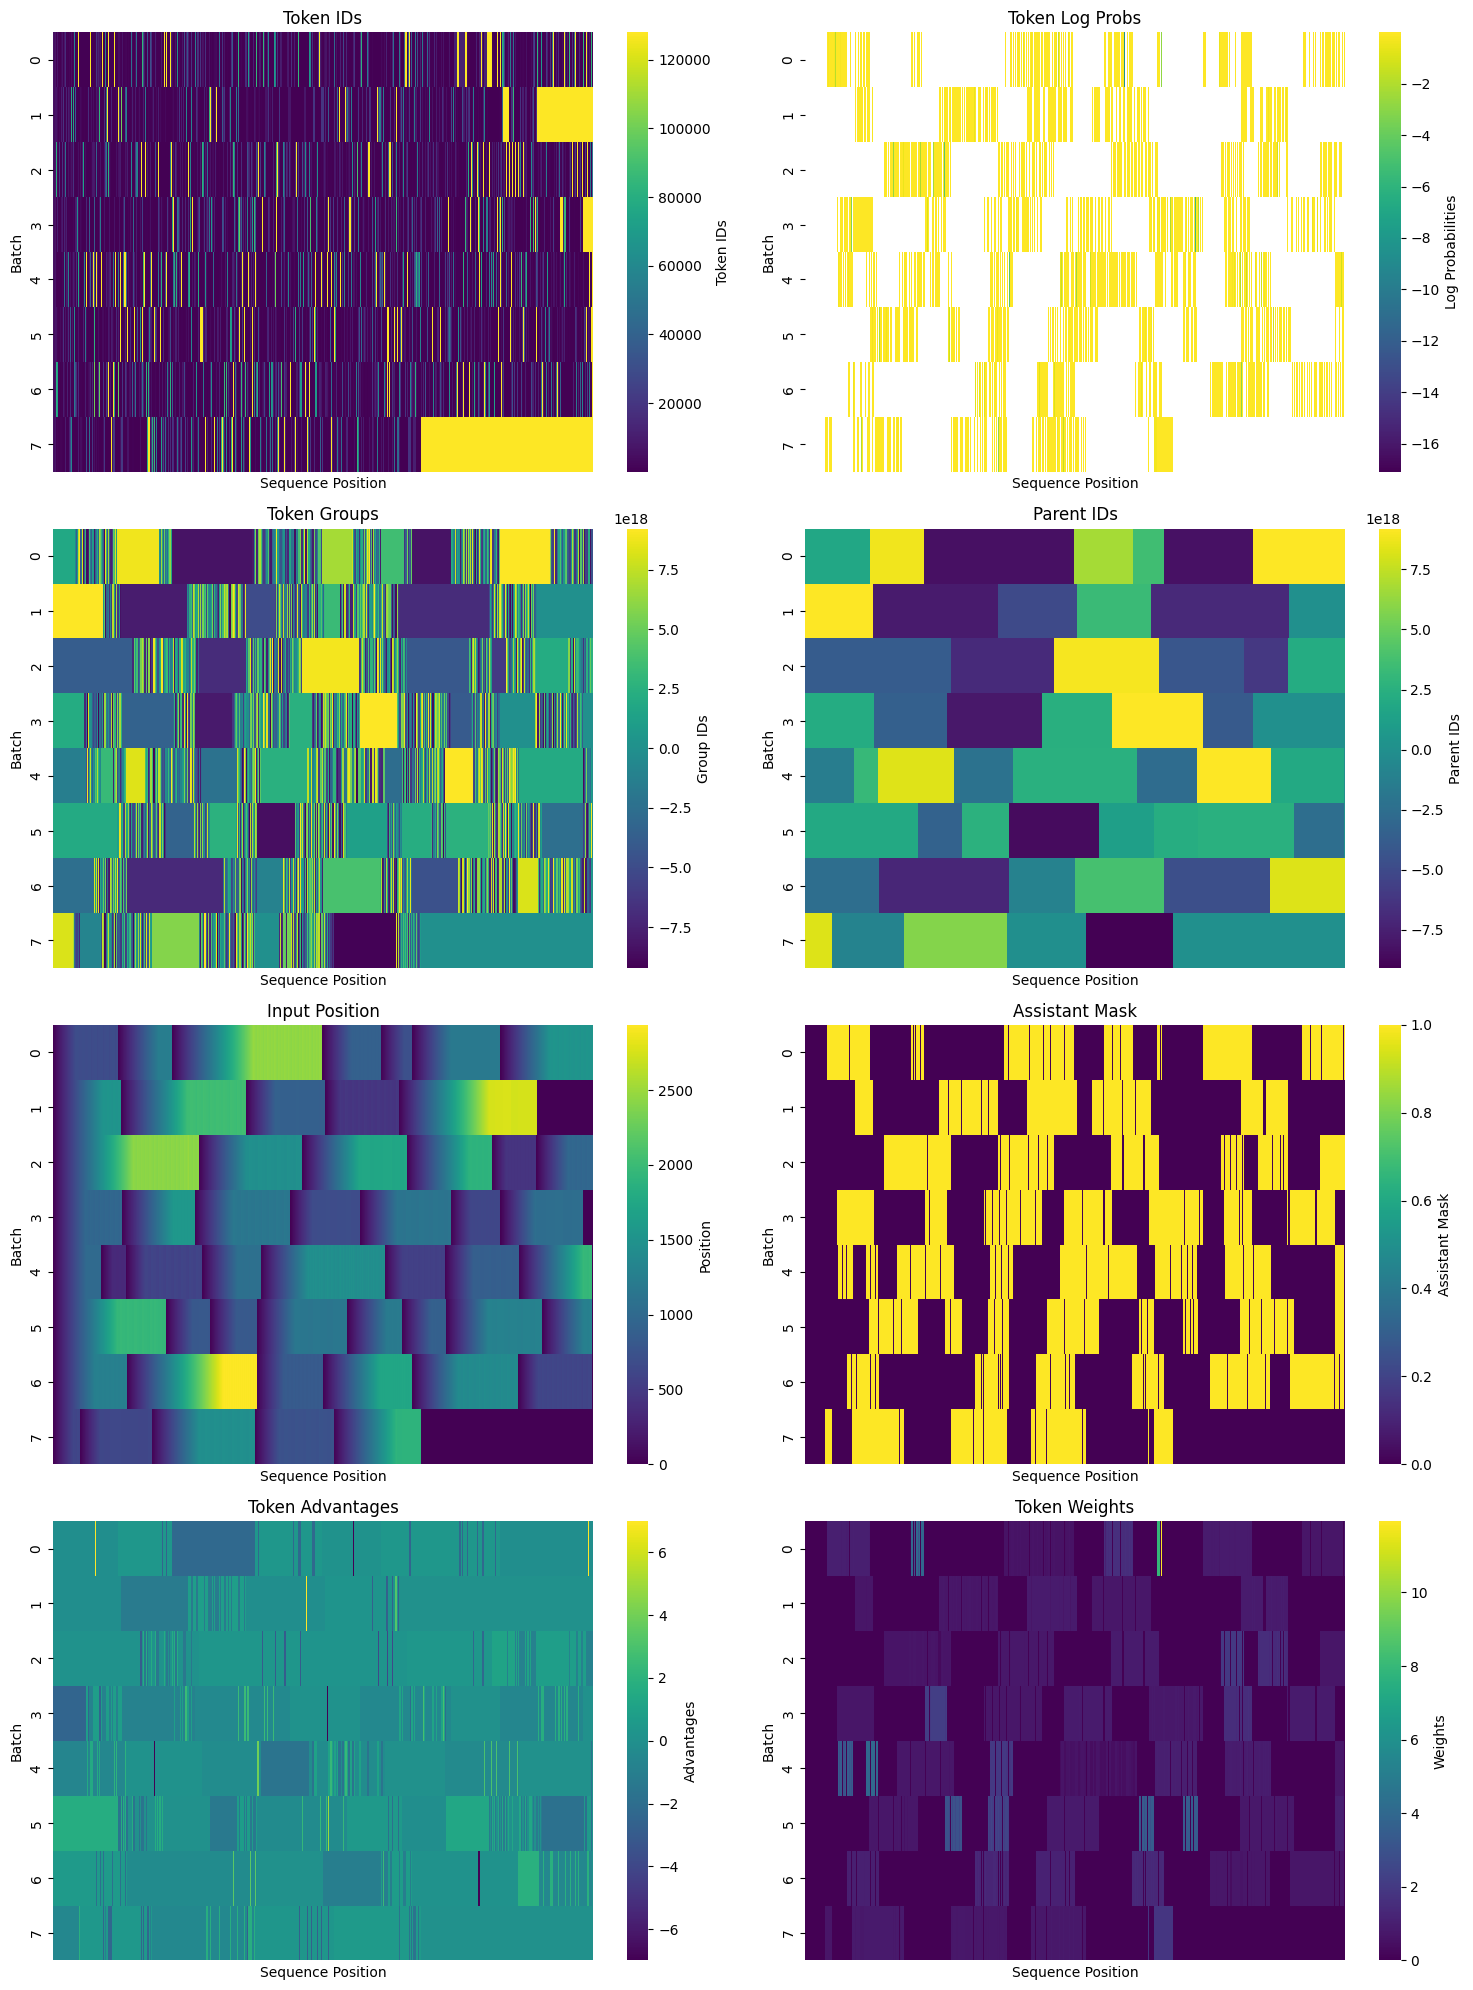

rsyncing /home/ubuntu/sky_workdir/experiments/models/026 to gs://atreides/openpipe/models/026
$ tune run --nproc-per-node=1 lib.recipe.TuneRecipe --config ./models/026/config.yaml
Running with torchrun...


INFO:torchtune.utils._logging:Set intra op parallelism no. of threads to 26
INFO:torchtune.utils._logging:Running FullFinetuneRecipe with resolved config:

batch_size: 2
checkpointer:
  _component_: torchtune.training.checkpointing._checkpointer.FullModelHFCheckpointer
  checkpoint_dir: ./models/026/0025
  checkpoint_files:
  - hf_model_0004.pt
  - hf_model_0003.pt
  - hf_model_0002.pt
  - hf_model_0001.pt
  model_type: LLAMA3
  output_dir: ./models/026
  recipe_checkpoint: null
custom_sharded_layers:
- tok_embeddings
- output
dataset:
  _component_: lib.pack.PackedDataset
  dir: ./models/026/tensors
  num_sequences: 8
  sequence_length: 16384
device: cuda
dtype: bf16
enable_activation_checkpointing: true
enable_activation_offloading: true
epochs: 1
fsdp_cpu_offload: true
gradient_accumulation_steps: 1
loss:
  _component_: lib.grpo.GRPO
  clip_epsilon: 0.2
  entropy_coef: 0.0
  kl_coef: 0.0
  tanh: true
max_steps_per_epoch: null
metric_logger:
  _component_: torchtune.training.metric_l

Writing logs to models/026/logs/log_1740120708.txt


INFO:torchtune.utils._logging:FSDP is enabled. Instantiating model and loading checkpoint on Rank 0 ...
INFO:torchtune.utils._logging:Instantiating model and loading checkpoint took 22.93 secs
INFO:torchtune.utils._logging:Memory stats after model init:
	GPU peak memory allocation: 2.02 GiB
	GPU peak memory reserved: 2.12 GiB
	GPU peak memory active: 2.02 GiB
INFO:torchtune.utils._logging:Optimizer is initialized.
INFO:torchtune.utils._logging:Loss is initialized.
INFO:torchtune.utils._logging:Dataset and Sampler are initialized.
INFO:torchtune.utils._logging: Profiler config after instantiation: {'enabled': False}
  0%|          | 0/4 [00:00<?, ?it/s]

AssertionError: No model checkpoint files found to save in output directory ./models/026

In [5]:
model_name = get_last_iteration_dir(output_dir) or model.base_model
for i in range(get_iteration(output_dir), num_iterations):
    vllm = await start_vllm(
        model_name,
        max_concurrent_requests=1024,
        env={"VLLM_ALLOW_LONG_MAX_MODEL_LEN": "1"},
        named_arguments=dict(
            block_size=32,
            disable_log_requests=True,
            enable_prefix_caching=True,
            enforce_eager=True,
            gpu_memory_utilization=0.95,
            max_model_len=16384,
            max_num_seqs=1024,
            max_num_batched_tokens=16384,
            num_scheduler_steps=8,
            preemption_mode="swap",
            return_tokens_as_token_ids=True,
            swap_space=80,
            tensor_parallel_size=torch.cuda.device_count(),
        ),
        timeout=180 + 15 * torch.cuda.device_count(),
        verbosity=verbosity,
    )
    semaphore = asyncio.Semaphore(
        int(1.33 * vllm.max_concurrent_tokens / expected_tokens)
    )
    offset = i * stride
    val_results, train_results = await asyncio.gather(
        get_task_results(
            tasks=val_tasks,
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=8,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="val",
            semaphore=semaphore,
        ),
        get_task_results(
            tasks=list(islice(cycle(train_tasks), offset, offset + tasks_per_iter)),
            client=vllm.client,
            model=vllm.model,
            cache=False,
            log_results=False,
            n=samples_per_task,
            params=ChatCompletionParams(
                stream_options={
                    "include_usage": True,
                },
                max_tokens=8192,
            ),
            pbar_desc="train",
            semaphore=semaphore,
            transform=TaskResultTokenizer(tokenizer),
        ),
    )
    vllm.process.terminate()
    kill_vllm_workers()
    val_stats = val_results.stats
    assert val_stats.grades > 0
    assert val_stats.usages > 0
    wandb_data = {
        "iteration": i,
        "exceptions": val_stats.exceptions + train_results.stats.exceptions,
        "reward": val_stats.total_reward / val_stats.grades,
        "tokens": round(val_stats.completion_tokens / val_stats.usages),
    }
    try:
        wandb_data.update(
            pl.DataFrame(last_tune_log(output_dir)).drop("step").mean().to_dicts()[0]
        )
    except Exception:
        pass
    wandb.log(wandb_data)
    expected_tokens = wandb_data["tokens"]
    try:
        best_iteration = (
            wandb.Api()
            .run(f"{run.entity}/{run.project}/{run.id}")
            .history()
            .sort_values(by="reward")["iteration"]
            .iloc[-1]
        )
        clear_iteration_dirs(output_dir, [best_iteration, i])
    except Exception:
        pass
    # see ./logs/rsync.log for output
    asyncio.create_task(rsync_dir(sync_dir, "gs://atreides/openpipe/"))
    tokenized_results = [
        result
        for results in train_results
        for result in results
        if result.advantage != 0
    ]
    packed_tensors = packed_tensors_from_tokenized_results(
        tokenized_results,
        seq_len=seq_len,
        pad_token_id=tokenizer.pad_token_id,  # type: ignore
    )
    if verbosity == 2:
        plot_packed_tensors(packed_tensors)
    else:
        print(f"Packed tensors into {packed_tensors["tokens"].size()} shape")
    batch_size = model.tune_max_batch_tokens // seq_len
    optimizer_config = ComponentConfig(
        model.tune_optimizer,
        lr=lr / max(packed_tensors["tokens"].shape[0] / batch_size, 25),
        betas=betas,
        weight_decay=weight_decay,
    )
    if model.tune_optimizer == "torch.optim.AdamW":
        optimizer_config.fused = True
    model_name = await tune(
        base_model=model.base_model,
        output_dir=output_dir,
        packed_tensors=packed_tensors,
        model=model.tune_model,
        model_type=model.tune_model_type,
        config=TuneRecipeConfig(
            optimizer=optimizer_config,
            loss=ComponentConfig(
                GRPO,
                clip_epsilon=clip_epsilon,
                entropy_coef=entropy_coef,
                kl_coef=kl_coef,
                tanh=tanh,
            ),
            shuffle=True,
            batch_size=batch_size,
            fsdp_cpu_offload=model.tune_fsdp_cpu_offload,
            enable_activation_checkpointing=True,
            enable_activation_offloading=True,
            custom_sharded_layers=["tok_embeddings", "output"],
            num_output_chunks=2,
        ),
        verbosity=verbosity,
    )
wandb.finish()